In [6]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import torch
import torch.optim as optim
import torch.nn as nn
import random
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np

seed = 1 # random.randint(1, 10000)
random.seed(seed)
torch.manual_seed(seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Downloading Images

In [2]:
IMAGE_URLS_FILE = "urls.txt"
IMAGE_FOLDER = "../training_images/"
IMAGE_CLASS = "sunset"

In [ ]:
from download_images import download_images
download_images(IMAGE_URLS_FILE, os.path.join(IMAGE_FOLDER, IMAGE_CLASS))

## Setting up dataloader

In [3]:
BATCH_SIZE = 128
DLOADER_WORKERS = 2

In [4]:
from dataloader import create_dataloader
dataloader = create_dataloader(IMAGE_FOLDER, BATCH_SIZE, DLOADER_WORKERS)

Example data visualisation

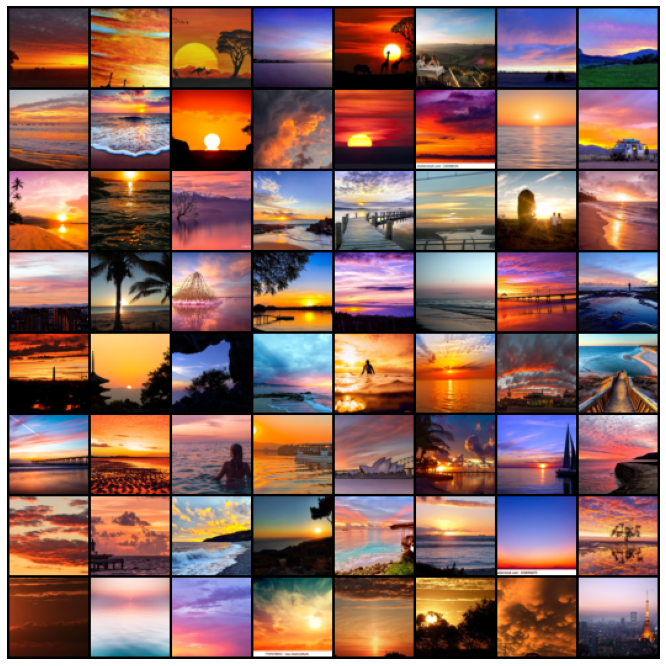

In [7]:
batch = next(iter(dataloader))
plt.figure(figsize=(12,12))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

## Setting up model

In [8]:
NZ = 128  # Size of z latent vector (i.e. size of generator input)
NGF = 64  # Size of generator feature maps
NDF = 64 # Size of discriminator feature maps
EPOCHS = 100
LR = 0.0002
BETA1 = 0.5 # Beta1 hyperparam for Adam

In [9]:
import model
# Initialising Generator
netG = model.Generator(NZ, NGF).to(device)
netG.apply(model.weights_init)
# Initialising Discriminator
netD = model.Discriminator(NDF).to(device)
netD.apply(model.weights_init)
# Initialise optimisers
optimizerD = optim.Adam(netD.parameters(), lr=LR, betas=(BETA1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=LR, betas=(BETA1, 0.999))

loss_criterion = nn.BCELoss()

**Load saved state if available**

In [14]:
checkpoint = torch.load("4000_save.pt")
model.load_states([
    (netG,checkpoint['netG']),
    (netD,checkpoint['netD']),
    (optimizerG,checkpoint['optimizerG']),
    (optimizerD,checkpoint['optimizerD'])
])
netG.train()
netD.train()

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

## Training model

In [17]:
from train import train
EPOCHS = 5000
G_losses = []
D_losses = []

In [18]:
train(EPOCHS, dataloader, netG, netD, optimizerG, optimizerD, loss_criterion, NZ, G_losses, D_losses, save_interval=100)

[0/5000][0/4]	Loss_D: 0.8296	Loss_G: 2.1712	D(x): 0.6084	D(G(z)): 0.1743 / 0.1522
[0/5000][1/4]	Loss_D: 0.8363	Loss_G: 1.6079	D(x): 0.6306	D(G(z)): 0.2396 / 0.2555
[0/5000][2/4]	Loss_D: 0.6588	Loss_G: 1.7425	D(x): 0.7688	D(G(z)): 0.2838 / 0.2215
[0/5000][3/4]	Loss_D: 1.5279	Loss_G: 5.0840	D(x): 0.8257	D(G(z)): 0.7107 / 0.0069
[1/5000][0/4]	Loss_D: 0.9767	Loss_G: 2.3415	D(x): 0.4822	D(G(z)): 0.1288 / 0.1433
[1/5000][1/4]	Loss_D: 0.8074	Loss_G: 1.6107	D(x): 0.5907	D(G(z)): 0.1721 / 0.2614
[1/5000][2/4]	Loss_D: 1.0107	Loss_G: 1.4957	D(x): 0.7901	D(G(z)): 0.4820 / 0.2715
[1/5000][3/4]	Loss_D: 0.3934	Loss_G: 2.8362	D(x): 0.7616	D(G(z)): 0.1133 / 0.0591
[2/5000][0/4]	Loss_D: 0.8506	Loss_G: 1.8175	D(x): 0.7765	D(G(z)): 0.4005 / 0.2073
[2/5000][1/4]	Loss_D: 0.8455	Loss_G: 1.9583	D(x): 0.7172	D(G(z)): 0.3513 / 0.1828
[2/5000][2/4]	Loss_D: 0.8296	Loss_G: 1.9030	D(x): 0.6309	D(G(z)): 0.2462 / 0.1895
[2/5000][3/4]	Loss_D: 0.8359	Loss_G: 2.7476	D(x): 0.6296	D(G(z)): 0.2689 / 0.0652
[3/5000][0/4]	Lo

[25/5000][0/4]	Loss_D: 1.1481	Loss_G: 2.1868	D(x): 0.9047	D(G(z)): 0.6025 / 0.1414
[25/5000][1/4]	Loss_D: 0.6817	Loss_G: 2.7839	D(x): 0.7266	D(G(z)): 0.2594 / 0.0828
[25/5000][2/4]	Loss_D: 0.4727	Loss_G: 2.6441	D(x): 0.7457	D(G(z)): 0.1312 / 0.0897
[25/5000][3/4]	Loss_D: 0.4577	Loss_G: 2.4740	D(x): 0.7493	D(G(z)): 0.1430 / 0.0856
[26/5000][0/4]	Loss_D: 0.6376	Loss_G: 2.1790	D(x): 0.8522	D(G(z)): 0.3453 / 0.1402
[26/5000][1/4]	Loss_D: 0.6888	Loss_G: 2.3625	D(x): 0.7207	D(G(z)): 0.2530 / 0.1167
[26/5000][2/4]	Loss_D: 0.7412	Loss_G: 1.9912	D(x): 0.6483	D(G(z)): 0.1950 / 0.1576
[26/5000][3/4]	Loss_D: 0.2865	Loss_G: 2.7699	D(x): 0.8529	D(G(z)): 0.1136 / 0.0651
[27/5000][0/4]	Loss_D: 0.8710	Loss_G: 2.2923	D(x): 0.8596	D(G(z)): 0.4779 / 0.1214
[27/5000][1/4]	Loss_D: 0.7905	Loss_G: 2.2695	D(x): 0.6035	D(G(z)): 0.1937 / 0.1229
[27/5000][2/4]	Loss_D: 0.7766	Loss_G: 1.9029	D(x): 0.6864	D(G(z)): 0.2918 / 0.1776
[27/5000][3/4]	Loss_D: 1.6005	Loss_G: 3.0082	D(x): 0.4952	D(G(z)): 0.4903 / 0.0952
[28/

[50/5000][0/4]	Loss_D: 1.8706	Loss_G: 2.6583	D(x): 0.7856	D(G(z)): 0.7066 / 0.1288
[50/5000][1/4]	Loss_D: 1.0073	Loss_G: 3.2401	D(x): 0.6256	D(G(z)): 0.2967 / 0.0664
[50/5000][2/4]	Loss_D: 1.3591	Loss_G: 1.8517	D(x): 0.4181	D(G(z)): 0.1532 / 0.2225
[50/5000][3/4]	Loss_D: 1.0146	Loss_G: 1.9345	D(x): 0.4768	D(G(z)): 0.1473 / 0.1994
[51/5000][0/4]	Loss_D: 1.9482	Loss_G: 2.4161	D(x): 0.9120	D(G(z)): 0.7727 / 0.1528
[51/5000][1/4]	Loss_D: 0.6604	Loss_G: 3.5207	D(x): 0.8153	D(G(z)): 0.3011 / 0.0558
[51/5000][2/4]	Loss_D: 0.6914	Loss_G: 2.6532	D(x): 0.6228	D(G(z)): 0.1211 / 0.1055
[51/5000][3/4]	Loss_D: 1.8067	Loss_G: 1.7950	D(x): 0.3642	D(G(z)): 0.3261 / 0.2016
[52/5000][0/4]	Loss_D: 1.7059	Loss_G: 2.6170	D(x): 0.8452	D(G(z)): 0.7144 / 0.1160
[52/5000][1/4]	Loss_D: 1.1770	Loss_G: 3.0643	D(x): 0.5580	D(G(z)): 0.3291 / 0.0785
[52/5000][2/4]	Loss_D: 1.0164	Loss_G: 2.6573	D(x): 0.5295	D(G(z)): 0.1531 / 0.1193
[52/5000][3/4]	Loss_D: 1.0874	Loss_G: 4.2062	D(x): 0.5343	D(G(z)): 0.3324 / 0.0149
[53/

[75/5000][0/4]	Loss_D: 1.7413	Loss_G: 3.6670	D(x): 0.8613	D(G(z)): 0.7432 / 0.0363
[75/5000][1/4]	Loss_D: 1.0572	Loss_G: 2.4765	D(x): 0.4747	D(G(z)): 0.1443 / 0.1199
[75/5000][2/4]	Loss_D: 0.9301	Loss_G: 1.5839	D(x): 0.5806	D(G(z)): 0.2508 / 0.2609
[75/5000][3/4]	Loss_D: 1.2451	Loss_G: 3.5725	D(x): 0.5086	D(G(z)): 0.4244 / 0.0459
[76/5000][0/4]	Loss_D: 0.6520	Loss_G: 2.7322	D(x): 0.7977	D(G(z)): 0.3097 / 0.0860
[76/5000][1/4]	Loss_D: 0.4639	Loss_G: 2.9264	D(x): 0.7744	D(G(z)): 0.1554 / 0.0843
[76/5000][2/4]	Loss_D: 0.5224	Loss_G: 2.5228	D(x): 0.7952	D(G(z)): 0.2176 / 0.1142
[76/5000][3/4]	Loss_D: 2.3089	Loss_G: 3.7954	D(x): 0.3910	D(G(z)): 0.6648 / 0.0370
[77/5000][0/4]	Loss_D: 0.7961	Loss_G: 2.0729	D(x): 0.7105	D(G(z)): 0.2827 / 0.1954
[77/5000][1/4]	Loss_D: 0.7922	Loss_G: 2.4799	D(x): 0.7911	D(G(z)): 0.3627 / 0.1301
[77/5000][2/4]	Loss_D: 0.7779	Loss_G: 2.5843	D(x): 0.6535	D(G(z)): 0.2091 / 0.1264
[77/5000][3/4]	Loss_D: 1.0217	Loss_G: 2.0606	D(x): 0.4037	D(G(z)): 0.0316 / 0.1317
[78/

[100/5000][0/4]	Loss_D: 2.2878	Loss_G: 2.2455	D(x): 0.9538	D(G(z)): 0.8305 / 0.1660
[100/5000][1/4]	Loss_D: 0.7371	Loss_G: 4.1470	D(x): 0.7678	D(G(z)): 0.2912 / 0.0347
[100/5000][2/4]	Loss_D: 0.6665	Loss_G: 3.5065	D(x): 0.6295	D(G(z)): 0.0674 / 0.0610
[100/5000][3/4]	Loss_D: 0.8927	Loss_G: 1.9190	D(x): 0.5022	D(G(z)): 0.0352 / 0.2189
[101/5000][0/4]	Loss_D: 1.4867	Loss_G: 1.7628	D(x): 0.8694	D(G(z)): 0.6294 / 0.2654
[101/5000][1/4]	Loss_D: 0.7803	Loss_G: 3.2296	D(x): 0.8660	D(G(z)): 0.3970 / 0.0646
[101/5000][2/4]	Loss_D: 0.6107	Loss_G: 3.1466	D(x): 0.6840	D(G(z)): 0.1348 / 0.0653
[101/5000][3/4]	Loss_D: 0.7738	Loss_G: 2.5734	D(x): 0.5798	D(G(z)): 0.1496 / 0.1030
[102/5000][0/4]	Loss_D: 0.5274	Loss_G: 1.9832	D(x): 0.7979	D(G(z)): 0.2150 / 0.1795
[102/5000][1/4]	Loss_D: 0.5041	Loss_G: 2.2803	D(x): 0.8585	D(G(z)): 0.2555 / 0.1383
[102/5000][2/4]	Loss_D: 0.6626	Loss_G: 2.3479	D(x): 0.7724	D(G(z)): 0.2788 / 0.1267
[102/5000][3/4]	Loss_D: 0.6064	Loss_G: 4.2008	D(x): 0.8156	D(G(z)): 0.2932 /

[124/5000][2/4]	Loss_D: 0.8646	Loss_G: 2.4585	D(x): 0.7139	D(G(z)): 0.3462 / 0.1103
[124/5000][3/4]	Loss_D: 2.1038	Loss_G: 3.5601	D(x): 0.2347	D(G(z)): 0.3713 / 0.0473
[125/5000][0/4]	Loss_D: 0.8483	Loss_G: 2.3817	D(x): 0.8666	D(G(z)): 0.4490 / 0.1420
[125/5000][1/4]	Loss_D: 0.4976	Loss_G: 3.0546	D(x): 0.8202	D(G(z)): 0.2096 / 0.0824
[125/5000][2/4]	Loss_D: 0.5265	Loss_G: 2.6441	D(x): 0.7998	D(G(z)): 0.2149 / 0.1051
[125/5000][3/4]	Loss_D: 1.1478	Loss_G: 0.6020	D(x): 0.4202	D(G(z)): 0.1545 / 0.5587
[126/5000][0/4]	Loss_D: 1.7305	Loss_G: 2.1808	D(x): 0.9427	D(G(z)): 0.7373 / 0.1580
[126/5000][1/4]	Loss_D: 0.6424	Loss_G: 3.3648	D(x): 0.8073	D(G(z)): 0.3037 / 0.0510
[126/5000][2/4]	Loss_D: 0.7295	Loss_G: 2.5438	D(x): 0.5930	D(G(z)): 0.1205 / 0.1066
[126/5000][3/4]	Loss_D: 1.6680	Loss_G: 2.8839	D(x): 0.3639	D(G(z)): 0.3661 / 0.0605
[127/5000][0/4]	Loss_D: 1.0121	Loss_G: 2.0006	D(x): 0.8017	D(G(z)): 0.4818 / 0.1904
[127/5000][1/4]	Loss_D: 0.9323	Loss_G: 2.1128	D(x): 0.5996	D(G(z)): 0.2501 /

[149/5000][0/4]	Loss_D: 1.7073	Loss_G: 1.9707	D(x): 0.9117	D(G(z)): 0.7431 / 0.1868
[149/5000][1/4]	Loss_D: 0.5251	Loss_G: 3.0695	D(x): 0.8663	D(G(z)): 0.2771 / 0.0695
[149/5000][2/4]	Loss_D: 0.5597	Loss_G: 2.9198	D(x): 0.6820	D(G(z)): 0.0915 / 0.0775
[149/5000][3/4]	Loss_D: 0.5095	Loss_G: 2.5869	D(x): 0.6185	D(G(z)): 0.0250 / 0.0844
[150/5000][0/4]	Loss_D: 1.2111	Loss_G: 1.6947	D(x): 0.8108	D(G(z)): 0.5601 / 0.2361
[150/5000][1/4]	Loss_D: 0.8164	Loss_G: 2.3927	D(x): 0.7162	D(G(z)): 0.3254 / 0.1161
[150/5000][2/4]	Loss_D: 0.4768	Loss_G: 2.7668	D(x): 0.8409	D(G(z)): 0.2241 / 0.0852
[150/5000][3/4]	Loss_D: 0.6706	Loss_G: 3.1182	D(x): 0.5630	D(G(z)): 0.0776 / 0.0477
[151/5000][0/4]	Loss_D: 0.7658	Loss_G: 2.0947	D(x): 0.8373	D(G(z)): 0.4054 / 0.1604
[151/5000][1/4]	Loss_D: 0.6799	Loss_G: 2.7711	D(x): 0.7956	D(G(z)): 0.3281 / 0.0803
[151/5000][2/4]	Loss_D: 0.5868	Loss_G: 2.6937	D(x): 0.7168	D(G(z)): 0.1770 / 0.0975
[151/5000][3/4]	Loss_D: 0.9274	Loss_G: 3.0433	D(x): 0.5437	D(G(z)): 0.2437 /

[173/5000][2/4]	Loss_D: 0.6325	Loss_G: 2.7598	D(x): 0.7150	D(G(z)): 0.2016 / 0.0998
[173/5000][3/4]	Loss_D: 1.2451	Loss_G: 1.8611	D(x): 0.4463	D(G(z)): 0.2763 / 0.1640
[174/5000][0/4]	Loss_D: 0.7162	Loss_G: 1.6344	D(x): 0.7814	D(G(z)): 0.3301 / 0.2299
[174/5000][1/4]	Loss_D: 0.7789	Loss_G: 1.8717	D(x): 0.7252	D(G(z)): 0.3138 / 0.1862
[174/5000][2/4]	Loss_D: 0.7775	Loss_G: 1.8955	D(x): 0.7168	D(G(z)): 0.3081 / 0.1862
[174/5000][3/4]	Loss_D: 0.7192	Loss_G: 3.7881	D(x): 0.7590	D(G(z)): 0.3278 / 0.0243
[175/5000][0/4]	Loss_D: 0.9706	Loss_G: 1.7916	D(x): 0.5332	D(G(z)): 0.1859 / 0.2171
[175/5000][1/4]	Loss_D: 0.8887	Loss_G: 1.5333	D(x): 0.7125	D(G(z)): 0.3438 / 0.2755
[175/5000][2/4]	Loss_D: 0.8932	Loss_G: 1.7044	D(x): 0.7143	D(G(z)): 0.3673 / 0.2205
[175/5000][3/4]	Loss_D: 0.9177	Loss_G: 2.1436	D(x): 0.4429	D(G(z)): 0.0782 / 0.1260
[176/5000][0/4]	Loss_D: 1.2426	Loss_G: 1.1937	D(x): 0.8235	D(G(z)): 0.5987 / 0.3497
[176/5000][1/4]	Loss_D: 1.0535	Loss_G: 2.0435	D(x): 0.7742	D(G(z)): 0.4895 /

[198/5000][0/4]	Loss_D: 0.8991	Loss_G: 2.1011	D(x): 0.8350	D(G(z)): 0.4547 / 0.1635
[198/5000][1/4]	Loss_D: 0.8329	Loss_G: 2.6088	D(x): 0.7858	D(G(z)): 0.3785 / 0.1076
[198/5000][2/4]	Loss_D: 0.6141	Loss_G: 2.7879	D(x): 0.7694	D(G(z)): 0.2436 / 0.0884
[198/5000][3/4]	Loss_D: 2.1627	Loss_G: 3.4237	D(x): 0.3862	D(G(z)): 0.4604 / 0.0402
[199/5000][0/4]	Loss_D: 0.8733	Loss_G: 1.8573	D(x): 0.8597	D(G(z)): 0.4567 / 0.2021
[199/5000][1/4]	Loss_D: 0.6960	Loss_G: 2.7430	D(x): 0.8264	D(G(z)): 0.3370 / 0.0912
[199/5000][2/4]	Loss_D: 0.7182	Loss_G: 2.4769	D(x): 0.6708	D(G(z)): 0.1937 / 0.1161
[199/5000][3/4]	Loss_D: 0.9968	Loss_G: 2.6431	D(x): 0.6436	D(G(z)): 0.2693 / 0.1102
[200/5000][0/4]	Loss_D: 1.0966	Loss_G: 1.9023	D(x): 0.7424	D(G(z)): 0.4562 / 0.2149
[200/5000][1/4]	Loss_D: 0.9474	Loss_G: 2.3289	D(x): 0.6908	D(G(z)): 0.3430 / 0.1397
[200/5000][2/4]	Loss_D: 0.9668	Loss_G: 2.0954	D(x): 0.6079	D(G(z)): 0.2712 / 0.1589
[200/5000][3/4]	Loss_D: 0.8862	Loss_G: 1.7731	D(x): 0.4950	D(G(z)): 0.0668 /

[222/5000][2/4]	Loss_D: 0.6475	Loss_G: 2.2646	D(x): 0.7038	D(G(z)): 0.2018 / 0.1539
[222/5000][3/4]	Loss_D: 0.7279	Loss_G: 3.0310	D(x): 0.7240	D(G(z)): 0.2680 / 0.0593
[223/5000][0/4]	Loss_D: 0.5936	Loss_G: 2.0920	D(x): 0.8375	D(G(z)): 0.2975 / 0.1731
[223/5000][1/4]	Loss_D: 0.6915	Loss_G: 2.2383	D(x): 0.8263	D(G(z)): 0.3518 / 0.1374
[223/5000][2/4]	Loss_D: 0.8802	Loss_G: 1.9418	D(x): 0.6204	D(G(z)): 0.2542 / 0.1860
[223/5000][3/4]	Loss_D: 0.8599	Loss_G: 2.5891	D(x): 0.4732	D(G(z)): 0.1000 / 0.0825
[224/5000][0/4]	Loss_D: 1.3373	Loss_G: 1.5727	D(x): 0.7881	D(G(z)): 0.5925 / 0.2713
[224/5000][1/4]	Loss_D: 0.8584	Loss_G: 2.4242	D(x): 0.7401	D(G(z)): 0.3535 / 0.1259
[224/5000][2/4]	Loss_D: 0.7455	Loss_G: 2.3495	D(x): 0.6446	D(G(z)): 0.1900 / 0.1342
[224/5000][3/4]	Loss_D: 1.0455	Loss_G: 2.6337	D(x): 0.4881	D(G(z)): 0.2175 / 0.0831
[225/5000][0/4]	Loss_D: 0.8969	Loss_G: 1.6796	D(x): 0.8101	D(G(z)): 0.4353 / 0.2486
[225/5000][1/4]	Loss_D: 1.0123	Loss_G: 1.9926	D(x): 0.7490	D(G(z)): 0.4137 /

[247/5000][0/4]	Loss_D: 0.9771	Loss_G: 1.6891	D(x): 0.5603	D(G(z)): 0.2317 / 0.2426
[247/5000][1/4]	Loss_D: 0.7726	Loss_G: 1.8267	D(x): 0.7283	D(G(z)): 0.2999 / 0.2212
[247/5000][2/4]	Loss_D: 0.6958	Loss_G: 2.1025	D(x): 0.7625	D(G(z)): 0.2898 / 0.1647
[247/5000][3/4]	Loss_D: 0.8512	Loss_G: 2.6989	D(x): 0.5022	D(G(z)): 0.0929 / 0.0849
[248/5000][0/4]	Loss_D: 1.0005	Loss_G: 1.7428	D(x): 0.8293	D(G(z)): 0.4961 / 0.2229
[248/5000][1/4]	Loss_D: 0.7023	Loss_G: 2.5048	D(x): 0.7526	D(G(z)): 0.2917 / 0.1170
[248/5000][2/4]	Loss_D: 0.7151	Loss_G: 2.2381	D(x): 0.6730	D(G(z)): 0.2264 / 0.1441
[248/5000][3/4]	Loss_D: 0.6621	Loss_G: 4.2136	D(x): 0.8706	D(G(z)): 0.3713 / 0.0188
[249/5000][0/4]	Loss_D: 0.7999	Loss_G: 2.4836	D(x): 0.5727	D(G(z)): 0.1128 / 0.1153
[249/5000][1/4]	Loss_D: 0.7661	Loss_G: 1.7023	D(x): 0.6409	D(G(z)): 0.2120 / 0.2433
[249/5000][2/4]	Loss_D: 0.7535	Loss_G: 1.6782	D(x): 0.7605	D(G(z)): 0.3325 / 0.2306
[249/5000][3/4]	Loss_D: 3.4966	Loss_G: 1.5410	D(x): 0.0807	D(G(z)): 0.3241 /

[271/5000][2/4]	Loss_D: 0.6239	Loss_G: 2.3001	D(x): 0.7457	D(G(z)): 0.2416 / 0.1266
[271/5000][3/4]	Loss_D: 0.8851	Loss_G: 1.6098	D(x): 0.4593	D(G(z)): 0.0667 / 0.2194
[272/5000][0/4]	Loss_D: 1.3829	Loss_G: 1.9233	D(x): 0.9224	D(G(z)): 0.6798 / 0.1805
[272/5000][1/4]	Loss_D: 0.8375	Loss_G: 2.9622	D(x): 0.7968	D(G(z)): 0.4156 / 0.0708
[272/5000][2/4]	Loss_D: 0.8947	Loss_G: 2.4042	D(x): 0.5358	D(G(z)): 0.1406 / 0.1101
[272/5000][3/4]	Loss_D: 2.0184	Loss_G: 5.1460	D(x): 0.5037	D(G(z)): 0.5587 / 0.0205
[273/5000][0/4]	Loss_D: 0.8451	Loss_G: 2.3633	D(x): 0.6870	D(G(z)): 0.2690 / 0.1638
[273/5000][1/4]	Loss_D: 0.9376	Loss_G: 2.1236	D(x): 0.6403	D(G(z)): 0.2799 / 0.1869
[273/5000][2/4]	Loss_D: 1.0261	Loss_G: 2.2127	D(x): 0.6858	D(G(z)): 0.3664 / 0.1628
[273/5000][3/4]	Loss_D: 0.7027	Loss_G: 2.6990	D(x): 0.5606	D(G(z)): 0.1068 / 0.0678
[274/5000][0/4]	Loss_D: 1.0328	Loss_G: 2.3350	D(x): 0.7948	D(G(z)): 0.4698 / 0.1404
[274/5000][1/4]	Loss_D: 0.6205	Loss_G: 2.7855	D(x): 0.7360	D(G(z)): 0.2227 /

[296/5000][0/4]	Loss_D: 0.6385	Loss_G: 1.9710	D(x): 0.8018	D(G(z)): 0.2944 / 0.1864
[296/5000][1/4]	Loss_D: 0.8210	Loss_G: 1.8530	D(x): 0.6698	D(G(z)): 0.2760 / 0.2049
[296/5000][2/4]	Loss_D: 0.6345	Loss_G: 1.9720	D(x): 0.7928	D(G(z)): 0.2900 / 0.1727
[296/5000][3/4]	Loss_D: 1.1259	Loss_G: 1.9763	D(x): 0.4200	D(G(z)): 0.2166 / 0.1391
[297/5000][0/4]	Loss_D: 1.2361	Loss_G: 1.4329	D(x): 0.8496	D(G(z)): 0.5923 / 0.2988
[297/5000][1/4]	Loss_D: 0.7380	Loss_G: 2.4936	D(x): 0.8504	D(G(z)): 0.3882 / 0.1214
[297/5000][2/4]	Loss_D: 0.6636	Loss_G: 2.5339	D(x): 0.7033	D(G(z)): 0.2003 / 0.1173
[297/5000][3/4]	Loss_D: 1.2401	Loss_G: 4.1374	D(x): 0.6712	D(G(z)): 0.4585 / 0.0227
[298/5000][0/4]	Loss_D: 0.8314	Loss_G: 2.0361	D(x): 0.6091	D(G(z)): 0.1995 / 0.1956
[298/5000][1/4]	Loss_D: 0.9114	Loss_G: 1.6354	D(x): 0.6165	D(G(z)): 0.2380 / 0.2664
[298/5000][2/4]	Loss_D: 0.7204	Loss_G: 1.7136	D(x): 0.7649	D(G(z)): 0.3044 / 0.2282
[298/5000][3/4]	Loss_D: 1.3642	Loss_G: 1.4208	D(x): 0.3412	D(G(z)): 0.2146 /

[320/5000][2/4]	Loss_D: 0.6670	Loss_G: 2.3966	D(x): 0.6783	D(G(z)): 0.2020 / 0.1172
[320/5000][3/4]	Loss_D: 2.1637	Loss_G: 1.5937	D(x): 0.1608	D(G(z)): 0.1904 / 0.2330
[321/5000][0/4]	Loss_D: 1.8059	Loss_G: 1.7924	D(x): 0.9361	D(G(z)): 0.7688 / 0.2255
[321/5000][1/4]	Loss_D: 0.8080	Loss_G: 3.1655	D(x): 0.7703	D(G(z)): 0.3659 / 0.0635
[321/5000][2/4]	Loss_D: 0.7960	Loss_G: 2.7733	D(x): 0.5473	D(G(z)): 0.0887 / 0.0895
[321/5000][3/4]	Loss_D: 2.6930	Loss_G: 1.5714	D(x): 0.0991	D(G(z)): 0.1648 / 0.2164
[322/5000][0/4]	Loss_D: 1.7325	Loss_G: 1.2049	D(x): 0.9488	D(G(z)): 0.7481 / 0.3636
[322/5000][1/4]	Loss_D: 0.8156	Loss_G: 3.0406	D(x): 0.9235	D(G(z)): 0.4730 / 0.0644
[322/5000][2/4]	Loss_D: 0.5405	Loss_G: 3.2379	D(x): 0.6922	D(G(z)): 0.1131 / 0.0562
[322/5000][3/4]	Loss_D: 1.2294	Loss_G: 1.8001	D(x): 0.4031	D(G(z)): 0.1089 / 0.1675
[323/5000][0/4]	Loss_D: 0.6796	Loss_G: 1.6424	D(x): 0.8468	D(G(z)): 0.3459 / 0.2640
[323/5000][1/4]	Loss_D: 0.7502	Loss_G: 2.1174	D(x): 0.8176	D(G(z)): 0.3566 /

[345/5000][0/4]	Loss_D: 0.9371	Loss_G: 1.6432	D(x): 0.6953	D(G(z)): 0.3798 / 0.2350
[345/5000][1/4]	Loss_D: 1.0057	Loss_G: 1.8572	D(x): 0.7124	D(G(z)): 0.4362 / 0.1795
[345/5000][2/4]	Loss_D: 1.1272	Loss_G: 1.6720	D(x): 0.5206	D(G(z)): 0.2990 / 0.2272
[345/5000][3/4]	Loss_D: 0.8019	Loss_G: 1.4598	D(x): 0.4978	D(G(z)): 0.0389 / 0.2393
[346/5000][0/4]	Loss_D: 1.8637	Loss_G: 1.5725	D(x): 0.9387	D(G(z)): 0.7857 / 0.2564
[346/5000][1/4]	Loss_D: 0.9818	Loss_G: 2.6753	D(x): 0.6952	D(G(z)): 0.3851 / 0.1019
[346/5000][2/4]	Loss_D: 0.8197	Loss_G: 2.3329	D(x): 0.5877	D(G(z)): 0.1799 / 0.1270
[346/5000][3/4]	Loss_D: 0.9285	Loss_G: 2.0093	D(x): 0.5083	D(G(z)): 0.2005 / 0.1386
[347/5000][0/4]	Loss_D: 1.0263	Loss_G: 1.5077	D(x): 0.7834	D(G(z)): 0.4768 / 0.2785
[347/5000][1/4]	Loss_D: 0.7021	Loss_G: 2.2620	D(x): 0.8146	D(G(z)): 0.3519 / 0.1338
[347/5000][2/4]	Loss_D: 0.8427	Loss_G: 2.0232	D(x): 0.5829	D(G(z)): 0.2057 / 0.1719
[347/5000][3/4]	Loss_D: 0.2544	Loss_G: 2.9655	D(x): 0.8747	D(G(z)): 0.1098 /

[369/5000][2/4]	Loss_D: 0.7572	Loss_G: 1.7378	D(x): 0.6467	D(G(z)): 0.2166 / 0.2105
[369/5000][3/4]	Loss_D: 1.3214	Loss_G: 4.1495	D(x): 0.5570	D(G(z)): 0.4919 / 0.0295
[370/5000][0/4]	Loss_D: 0.7694	Loss_G: 1.7648	D(x): 0.6794	D(G(z)): 0.2467 / 0.2449
[370/5000][1/4]	Loss_D: 0.9726	Loss_G: 1.7976	D(x): 0.7119	D(G(z)): 0.3836 / 0.2154
[370/5000][2/4]	Loss_D: 0.7907	Loss_G: 2.1875	D(x): 0.7269	D(G(z)): 0.3202 / 0.1506
[370/5000][3/4]	Loss_D: 0.5658	Loss_G: 2.7541	D(x): 0.6694	D(G(z)): 0.1208 / 0.0718
[371/5000][0/4]	Loss_D: 0.9483	Loss_G: 1.9742	D(x): 0.7901	D(G(z)): 0.4452 / 0.1882
[371/5000][1/4]	Loss_D: 0.9487	Loss_G: 1.8785	D(x): 0.5876	D(G(z)): 0.2462 / 0.1902
[371/5000][2/4]	Loss_D: 0.7555	Loss_G: 1.9104	D(x): 0.7138	D(G(z)): 0.2971 / 0.1984
[371/5000][3/4]	Loss_D: 0.9826	Loss_G: 4.8449	D(x): 0.6339	D(G(z)): 0.3796 / 0.0135
[372/5000][0/4]	Loss_D: 0.8157	Loss_G: 1.9063	D(x): 0.6992	D(G(z)): 0.3129 / 0.2028
[372/5000][1/4]	Loss_D: 0.8197	Loss_G: 1.9073	D(x): 0.6899	D(G(z)): 0.3033 /

[394/5000][0/4]	Loss_D: 1.0213	Loss_G: 1.7023	D(x): 0.9082	D(G(z)): 0.5419 / 0.2347
[394/5000][1/4]	Loss_D: 0.7783	Loss_G: 2.7495	D(x): 0.8264	D(G(z)): 0.3986 / 0.0923
[394/5000][2/4]	Loss_D: 0.7384	Loss_G: 2.3497	D(x): 0.6475	D(G(z)): 0.1962 / 0.1304
[394/5000][3/4]	Loss_D: 0.9684	Loss_G: 0.8064	D(x): 0.5011	D(G(z)): 0.1178 / 0.4805
[395/5000][0/4]	Loss_D: 1.2119	Loss_G: 1.8998	D(x): 0.9152	D(G(z)): 0.6023 / 0.2026
[395/5000][1/4]	Loss_D: 0.8090	Loss_G: 2.7458	D(x): 0.7246	D(G(z)): 0.3126 / 0.0886
[395/5000][2/4]	Loss_D: 0.9642	Loss_G: 2.0058	D(x): 0.5312	D(G(z)): 0.1686 / 0.1813
[395/5000][3/4]	Loss_D: 1.5485	Loss_G: 2.5082	D(x): 0.4270	D(G(z)): 0.3479 / 0.0913
[396/5000][0/4]	Loss_D: 1.1310	Loss_G: 2.1175	D(x): 0.8862	D(G(z)): 0.5646 / 0.1787
[396/5000][1/4]	Loss_D: 0.8493	Loss_G: 2.4506	D(x): 0.6404	D(G(z)): 0.2511 / 0.1296
[396/5000][2/4]	Loss_D: 0.6598	Loss_G: 2.1032	D(x): 0.6902	D(G(z)): 0.1955 / 0.1592
[396/5000][3/4]	Loss_D: 1.2434	Loss_G: 5.5765	D(x): 0.8401	D(G(z)): 0.5514 /

[418/5000][2/4]	Loss_D: 0.8380	Loss_G: 2.3124	D(x): 0.6075	D(G(z)): 0.1995 / 0.1384
[418/5000][3/4]	Loss_D: 1.4772	Loss_G: 4.4724	D(x): 0.5200	D(G(z)): 0.4726 / 0.0188
[419/5000][0/4]	Loss_D: 0.8823	Loss_G: 2.0198	D(x): 0.7402	D(G(z)): 0.3634 / 0.2022
[419/5000][1/4]	Loss_D: 1.0948	Loss_G: 2.0026	D(x): 0.6781	D(G(z)): 0.3845 / 0.2061
[419/5000][2/4]	Loss_D: 1.0221	Loss_G: 2.0914	D(x): 0.6718	D(G(z)): 0.3670 / 0.1763
[419/5000][3/4]	Loss_D: 0.5215	Loss_G: 3.2241	D(x): 0.7458	D(G(z)): 0.1816 / 0.0514
[420/5000][0/4]	Loss_D: 1.0448	Loss_G: 1.9895	D(x): 0.6680	D(G(z)): 0.3735 / 0.2052
[420/5000][1/4]	Loss_D: 0.7880	Loss_G: 2.2488	D(x): 0.7284	D(G(z)): 0.3067 / 0.1463
[420/5000][2/4]	Loss_D: 0.9054	Loss_G: 2.0699	D(x): 0.6211	D(G(z)): 0.2575 / 0.1737
[420/5000][3/4]	Loss_D: 0.8924	Loss_G: 2.7674	D(x): 0.5678	D(G(z)): 0.1929 / 0.0959
[421/5000][0/4]	Loss_D: 1.2071	Loss_G: 2.1426	D(x): 0.8605	D(G(z)): 0.5842 / 0.1671
[421/5000][1/4]	Loss_D: 0.8051	Loss_G: 2.6696	D(x): 0.7155	D(G(z)): 0.3149 /

[443/5000][0/4]	Loss_D: 1.8462	Loss_G: 1.2987	D(x): 0.9547	D(G(z)): 0.7788 / 0.3302
[443/5000][1/4]	Loss_D: 0.8814	Loss_G: 2.9458	D(x): 0.8607	D(G(z)): 0.4724 / 0.0725
[443/5000][2/4]	Loss_D: 0.8471	Loss_G: 2.7942	D(x): 0.5359	D(G(z)): 0.1015 / 0.0955
[443/5000][3/4]	Loss_D: 1.8576	Loss_G: 1.3670	D(x): 0.3442	D(G(z)): 0.0456 / 0.3025
[444/5000][0/4]	Loss_D: 1.6232	Loss_G: 1.2193	D(x): 0.9316	D(G(z)): 0.6885 / 0.4089
[444/5000][1/4]	Loss_D: 1.1429	Loss_G: 2.6578	D(x): 0.8762	D(G(z)): 0.5384 / 0.1052
[444/5000][2/4]	Loss_D: 0.9109	Loss_G: 2.5282	D(x): 0.5313	D(G(z)): 0.1419 / 0.1156
[444/5000][3/4]	Loss_D: 0.8217	Loss_G: 2.1524	D(x): 0.5923	D(G(z)): 0.2207 / 0.1225
[445/5000][0/4]	Loss_D: 1.0059	Loss_G: 1.5258	D(x): 0.7407	D(G(z)): 0.4290 / 0.2873
[445/5000][1/4]	Loss_D: 0.9876	Loss_G: 2.0652	D(x): 0.7706	D(G(z)): 0.4325 / 0.1734
[445/5000][2/4]	Loss_D: 0.8649	Loss_G: 2.0103	D(x): 0.6061	D(G(z)): 0.2391 / 0.1803
[445/5000][3/4]	Loss_D: 0.9908	Loss_G: 1.7607	D(x): 0.4975	D(G(z)): 0.1630 /

[467/5000][2/4]	Loss_D: 1.1983	Loss_G: 1.8672	D(x): 0.4649	D(G(z)): 0.1680 / 0.2057
[467/5000][3/4]	Loss_D: 1.5405	Loss_G: 2.8248	D(x): 0.4331	D(G(z)): 0.2730 / 0.1013
[468/5000][0/4]	Loss_D: 1.1457	Loss_G: 2.0466	D(x): 0.8751	D(G(z)): 0.5450 / 0.2164
[468/5000][1/4]	Loss_D: 0.9589	Loss_G: 2.5898	D(x): 0.7341	D(G(z)): 0.3665 / 0.1333
[468/5000][2/4]	Loss_D: 0.8943	Loss_G: 2.1298	D(x): 0.6036	D(G(z)): 0.2108 / 0.1697
[468/5000][3/4]	Loss_D: 0.7548	Loss_G: 2.6663	D(x): 0.5305	D(G(z)): 0.0664 / 0.0902
[469/5000][0/4]	Loss_D: 1.5039	Loss_G: 1.6437	D(x): 0.9365	D(G(z)): 0.6794 / 0.2703
[469/5000][1/4]	Loss_D: 0.6210	Loss_G: 2.9547	D(x): 0.8463	D(G(z)): 0.3128 / 0.0798
[469/5000][2/4]	Loss_D: 0.6994	Loss_G: 2.6909	D(x): 0.6802	D(G(z)): 0.1820 / 0.1084
[469/5000][3/4]	Loss_D: 1.3207	Loss_G: 3.1925	D(x): 0.5822	D(G(z)): 0.3872 / 0.0488
[470/5000][0/4]	Loss_D: 0.6456	Loss_G: 2.1623	D(x): 0.7459	D(G(z)): 0.2326 / 0.1743
[470/5000][1/4]	Loss_D: 0.6920	Loss_G: 2.1604	D(x): 0.7618	D(G(z)): 0.2653 /

[492/5000][0/4]	Loss_D: 1.4988	Loss_G: 1.7202	D(x): 0.9297	D(G(z)): 0.6833 / 0.2503
[492/5000][1/4]	Loss_D: 0.7752	Loss_G: 2.9142	D(x): 0.7814	D(G(z)): 0.3464 / 0.0853
[492/5000][2/4]	Loss_D: 1.0047	Loss_G: 2.0957	D(x): 0.5485	D(G(z)): 0.2235 / 0.1742
[492/5000][3/4]	Loss_D: 0.8673	Loss_G: 2.5883	D(x): 0.5882	D(G(z)): 0.2749 / 0.0757
[493/5000][0/4]	Loss_D: 0.9545	Loss_G: 1.9112	D(x): 0.7608	D(G(z)): 0.4261 / 0.1873
[493/5000][1/4]	Loss_D: 0.7770	Loss_G: 2.1008	D(x): 0.6587	D(G(z)): 0.2385 / 0.1609
[493/5000][2/4]	Loss_D: 1.0303	Loss_G: 1.7228	D(x): 0.6296	D(G(z)): 0.3474 / 0.2224
[493/5000][3/4]	Loss_D: 0.7940	Loss_G: 2.1403	D(x): 0.5513	D(G(z)): 0.1731 / 0.1194
[494/5000][0/4]	Loss_D: 1.0139	Loss_G: 1.9938	D(x): 0.8410	D(G(z)): 0.5096 / 0.1800
[494/5000][1/4]	Loss_D: 0.7899	Loss_G: 2.2965	D(x): 0.6701	D(G(z)): 0.2532 / 0.1351
[494/5000][2/4]	Loss_D: 0.7871	Loss_G: 1.8399	D(x): 0.6374	D(G(z)): 0.2171 / 0.2049
[494/5000][3/4]	Loss_D: 0.2885	Loss_G: 3.1878	D(x): 0.9032	D(G(z)): 0.1646 /

[516/5000][2/4]	Loss_D: 0.7527	Loss_G: 2.4682	D(x): 0.6487	D(G(z)): 0.1863 / 0.1209
[516/5000][3/4]	Loss_D: 0.9361	Loss_G: 2.0457	D(x): 0.5397	D(G(z)): 0.1502 / 0.1421
[517/5000][0/4]	Loss_D: 1.1038	Loss_G: 1.4782	D(x): 0.7367	D(G(z)): 0.4500 / 0.3214
[517/5000][1/4]	Loss_D: 1.0257	Loss_G: 2.0591	D(x): 0.7308	D(G(z)): 0.4019 / 0.1939
[517/5000][2/4]	Loss_D: 0.8484	Loss_G: 1.9839	D(x): 0.6787	D(G(z)): 0.2831 / 0.1863
[517/5000][3/4]	Loss_D: 0.6931	Loss_G: 2.6543	D(x): 0.6576	D(G(z)): 0.1457 / 0.0797
[518/5000][0/4]	Loss_D: 0.9397	Loss_G: 1.8106	D(x): 0.8084	D(G(z)): 0.4503 / 0.2236
[518/5000][1/4]	Loss_D: 1.0171	Loss_G: 2.0650	D(x): 0.6900	D(G(z)): 0.4062 / 0.1730
[518/5000][2/4]	Loss_D: 1.0836	Loss_G: 1.8099	D(x): 0.5714	D(G(z)): 0.3130 / 0.2133
[518/5000][3/4]	Loss_D: 2.3228	Loss_G: 2.0913	D(x): 0.1562	D(G(z)): 0.2598 / 0.1302
[519/5000][0/4]	Loss_D: 1.1603	Loss_G: 1.6407	D(x): 0.8798	D(G(z)): 0.5844 / 0.2604
[519/5000][1/4]	Loss_D: 0.8165	Loss_G: 2.6107	D(x): 0.8099	D(G(z)): 0.4018 /

[541/5000][0/4]	Loss_D: 0.6955	Loss_G: 2.2050	D(x): 0.8975	D(G(z)): 0.4058 / 0.1448
[541/5000][1/4]	Loss_D: 0.6737	Loss_G: 2.3585	D(x): 0.7030	D(G(z)): 0.2312 / 0.1285
[541/5000][2/4]	Loss_D: 0.7438	Loss_G: 1.7781	D(x): 0.6452	D(G(z)): 0.2057 / 0.2101
[541/5000][3/4]	Loss_D: 2.2615	Loss_G: 1.2676	D(x): 0.1838	D(G(z)): 0.3418 / 0.2962
[542/5000][0/4]	Loss_D: 1.3898	Loss_G: 1.8018	D(x): 0.9136	D(G(z)): 0.6708 / 0.2121
[542/5000][1/4]	Loss_D: 0.7861	Loss_G: 2.8049	D(x): 0.7718	D(G(z)): 0.3542 / 0.0853
[542/5000][2/4]	Loss_D: 0.6712	Loss_G: 2.3686	D(x): 0.6370	D(G(z)): 0.1411 / 0.1279
[542/5000][3/4]	Loss_D: 1.3567	Loss_G: 1.8589	D(x): 0.3845	D(G(z)): 0.2239 / 0.2357
[543/5000][0/4]	Loss_D: 1.0673	Loss_G: 1.5808	D(x): 0.8640	D(G(z)): 0.5335 / 0.2768
[543/5000][1/4]	Loss_D: 0.9996	Loss_G: 2.1024	D(x): 0.7636	D(G(z)): 0.4196 / 0.1768
[543/5000][2/4]	Loss_D: 0.9074	Loss_G: 2.0821	D(x): 0.6982	D(G(z)): 0.3343 / 0.1719
[543/5000][3/4]	Loss_D: 1.3672	Loss_G: 2.2217	D(x): 0.4009	D(G(z)): 0.0390 /

[565/5000][2/4]	Loss_D: 0.7385	Loss_G: 1.9123	D(x): 0.7657	D(G(z)): 0.3361 / 0.1827
[565/5000][3/4]	Loss_D: 1.3330	Loss_G: 1.7396	D(x): 0.3473	D(G(z)): 0.1864 / 0.1960
[566/5000][0/4]	Loss_D: 1.2252	Loss_G: 1.6881	D(x): 0.8881	D(G(z)): 0.5973 / 0.2478
[566/5000][1/4]	Loss_D: 0.6565	Loss_G: 2.7748	D(x): 0.8413	D(G(z)): 0.3391 / 0.0863
[566/5000][2/4]	Loss_D: 0.7568	Loss_G: 2.4452	D(x): 0.6264	D(G(z)): 0.1637 / 0.1241
[566/5000][3/4]	Loss_D: 1.2835	Loss_G: 0.7783	D(x): 0.3123	D(G(z)): 0.1114 / 0.4964
[567/5000][0/4]	Loss_D: 1.2317	Loss_G: 1.4524	D(x): 0.9429	D(G(z)): 0.6245 / 0.2988
[567/5000][1/4]	Loss_D: 0.8414	Loss_G: 2.9816	D(x): 0.8559	D(G(z)): 0.4210 / 0.0826
[567/5000][2/4]	Loss_D: 0.6355	Loss_G: 2.9646	D(x): 0.6574	D(G(z)): 0.1228 / 0.0813
[567/5000][3/4]	Loss_D: 0.9838	Loss_G: 1.9158	D(x): 0.5078	D(G(z)): 0.0766 / 0.1510
[568/5000][0/4]	Loss_D: 0.8351	Loss_G: 1.8468	D(x): 0.9333	D(G(z)): 0.4748 / 0.2206
[568/5000][1/4]	Loss_D: 0.7398	Loss_G: 2.8634	D(x): 0.8577	D(G(z)): 0.3752 /

[590/5000][0/4]	Loss_D: 0.8353	Loss_G: 1.8979	D(x): 0.7465	D(G(z)): 0.3648 / 0.2007
[590/5000][1/4]	Loss_D: 0.6426	Loss_G: 2.1845	D(x): 0.7456	D(G(z)): 0.2478 / 0.1482
[590/5000][2/4]	Loss_D: 0.8977	Loss_G: 1.6179	D(x): 0.5926	D(G(z)): 0.2470 / 0.2473
[590/5000][3/4]	Loss_D: 1.3943	Loss_G: 6.4276	D(x): 0.8812	D(G(z)): 0.6723 / 0.0022
[591/5000][0/4]	Loss_D: 0.7542	Loss_G: 3.0067	D(x): 0.5405	D(G(z)): 0.0567 / 0.0686
[591/5000][1/4]	Loss_D: 0.5842	Loss_G: 1.7970	D(x): 0.6503	D(G(z)): 0.1012 / 0.2137
[591/5000][2/4]	Loss_D: 0.5799	Loss_G: 1.6748	D(x): 0.8429	D(G(z)): 0.3048 / 0.2282
[591/5000][3/4]	Loss_D: 0.5276	Loss_G: 4.8763	D(x): 0.9654	D(G(z)): 0.3762 / 0.0094
[592/5000][0/4]	Loss_D: 0.5740	Loss_G: 2.6651	D(x): 0.6928	D(G(z)): 0.1416 / 0.0977
[592/5000][1/4]	Loss_D: 0.5193	Loss_G: 2.2604	D(x): 0.7221	D(G(z)): 0.1339 / 0.1460
[592/5000][2/4]	Loss_D: 0.6251	Loss_G: 1.7641	D(x): 0.7411	D(G(z)): 0.2340 / 0.2156
[592/5000][3/4]	Loss_D: 0.3956	Loss_G: 3.6348	D(x): 0.8991	D(G(z)): 0.2489 /

[614/5000][2/4]	Loss_D: 0.6420	Loss_G: 2.4353	D(x): 0.6597	D(G(z)): 0.1384 / 0.1190
[614/5000][3/4]	Loss_D: 0.9964	Loss_G: 3.2826	D(x): 0.5637	D(G(z)): 0.3363 / 0.0559
[615/5000][0/4]	Loss_D: 0.7770	Loss_G: 2.3510	D(x): 0.8471	D(G(z)): 0.4024 / 0.1389
[615/5000][1/4]	Loss_D: 0.6184	Loss_G: 2.7392	D(x): 0.7405	D(G(z)): 0.2189 / 0.1018
[615/5000][2/4]	Loss_D: 0.5749	Loss_G: 2.2951	D(x): 0.7181	D(G(z)): 0.1737 / 0.1323
[615/5000][3/4]	Loss_D: 1.0750	Loss_G: 1.5543	D(x): 0.4317	D(G(z)): 0.1470 / 0.2122
[616/5000][0/4]	Loss_D: 1.2686	Loss_G: 2.4290	D(x): 0.9337	D(G(z)): 0.6392 / 0.1167
[616/5000][1/4]	Loss_D: 0.5141	Loss_G: 3.1643	D(x): 0.7479	D(G(z)): 0.1615 / 0.0554
[616/5000][2/4]	Loss_D: 0.5979	Loss_G: 2.4462	D(x): 0.6611	D(G(z)): 0.1207 / 0.1287
[616/5000][3/4]	Loss_D: 0.3464	Loss_G: 3.4527	D(x): 0.8379	D(G(z)): 0.1345 / 0.0332
[617/5000][0/4]	Loss_D: 0.6078	Loss_G: 2.1916	D(x): 0.8069	D(G(z)): 0.2869 / 0.1515
[617/5000][1/4]	Loss_D: 0.5073	Loss_G: 2.3115	D(x): 0.7551	D(G(z)): 0.1702 /

[639/5000][0/4]	Loss_D: 0.5864	Loss_G: 2.4541	D(x): 0.8321	D(G(z)): 0.2919 / 0.1169
[639/5000][1/4]	Loss_D: 0.8460	Loss_G: 2.0356	D(x): 0.6590	D(G(z)): 0.2832 / 0.1562
[639/5000][2/4]	Loss_D: 0.8945	Loss_G: 1.8243	D(x): 0.5979	D(G(z)): 0.2288 / 0.2031
[639/5000][3/4]	Loss_D: 1.1832	Loss_G: 3.1923	D(x): 0.4600	D(G(z)): 0.2430 / 0.0586
[640/5000][0/4]	Loss_D: 0.7675	Loss_G: 2.3919	D(x): 0.8850	D(G(z)): 0.3993 / 0.1556
[640/5000][1/4]	Loss_D: 0.5841	Loss_G: 3.0243	D(x): 0.8510	D(G(z)): 0.2916 / 0.0797
[640/5000][2/4]	Loss_D: 0.5975	Loss_G: 2.5643	D(x): 0.7218	D(G(z)): 0.1800 / 0.1127
[640/5000][3/4]	Loss_D: 1.1307	Loss_G: 6.6647	D(x): 0.8670	D(G(z)): 0.4963 / 0.0019
[641/5000][0/4]	Loss_D: 1.2332	Loss_G: 2.3521	D(x): 0.3917	D(G(z)): 0.0422 / 0.1339
[641/5000][1/4]	Loss_D: 0.7740	Loss_G: 1.2814	D(x): 0.7004	D(G(z)): 0.2713 / 0.3501
[641/5000][2/4]	Loss_D: 0.9332	Loss_G: 2.1745	D(x): 0.8045	D(G(z)): 0.4599 / 0.1474
[641/5000][3/4]	Loss_D: 0.8399	Loss_G: 5.7030	D(x): 0.8227	D(G(z)): 0.3843 /

[663/5000][2/4]	Loss_D: 0.7467	Loss_G: 2.0004	D(x): 0.6657	D(G(z)): 0.1974 / 0.1822
[663/5000][3/4]	Loss_D: 3.3178	Loss_G: 3.0308	D(x): 0.2531	D(G(z)): 0.3643 / 0.2373
[664/5000][0/4]	Loss_D: 0.9566	Loss_G: 2.2210	D(x): 0.9252	D(G(z)): 0.4871 / 0.1865
[664/5000][1/4]	Loss_D: 0.6937	Loss_G: 2.8286	D(x): 0.7738	D(G(z)): 0.2659 / 0.1060
[664/5000][2/4]	Loss_D: 0.8583	Loss_G: 1.8967	D(x): 0.5760	D(G(z)): 0.1388 / 0.2072
[664/5000][3/4]	Loss_D: 0.2100	Loss_G: 3.7953	D(x): 0.9029	D(G(z)): 0.0961 / 0.0265
[665/5000][0/4]	Loss_D: 1.0020	Loss_G: 2.7425	D(x): 0.8507	D(G(z)): 0.4911 / 0.1053
[665/5000][1/4]	Loss_D: 0.6350	Loss_G: 2.8545	D(x): 0.6808	D(G(z)): 0.1627 / 0.0948
[665/5000][2/4]	Loss_D: 0.7945	Loss_G: 1.7170	D(x): 0.6160	D(G(z)): 0.1789 / 0.2363
[665/5000][3/4]	Loss_D: 1.8001	Loss_G: 2.6006	D(x): 0.3806	D(G(z)): 0.4194 / 0.0931
[666/5000][0/4]	Loss_D: 1.7678	Loss_G: 3.1588	D(x): 0.9595	D(G(z)): 0.7540 / 0.0776
[666/5000][1/4]	Loss_D: 0.7224	Loss_G: 3.3952	D(x): 0.6176	D(G(z)): 0.0885 /

[688/5000][0/4]	Loss_D: 2.3207	Loss_G: 2.8212	D(x): 0.9668	D(G(z)): 0.8496 / 0.0963
[688/5000][1/4]	Loss_D: 0.5484	Loss_G: 3.6536	D(x): 0.6969	D(G(z)): 0.1099 / 0.0464
[688/5000][2/4]	Loss_D: 0.3362	Loss_G: 2.9158	D(x): 0.7929	D(G(z)): 0.0766 / 0.0827
[688/5000][3/4]	Loss_D: 0.1221	Loss_G: 4.1619	D(x): 0.9068	D(G(z)): 0.0216 / 0.0178
[689/5000][0/4]	Loss_D: 0.6990	Loss_G: 2.3620	D(x): 0.8295	D(G(z)): 0.3539 / 0.1284
[689/5000][1/4]	Loss_D: 0.6224	Loss_G: 2.7558	D(x): 0.7689	D(G(z)): 0.2563 / 0.0930
[689/5000][2/4]	Loss_D: 0.6904	Loss_G: 2.1691	D(x): 0.6365	D(G(z)): 0.1460 / 0.1512
[689/5000][3/4]	Loss_D: 0.8083	Loss_G: 2.2104	D(x): 0.6547	D(G(z)): 0.1806 / 0.1283
[690/5000][0/4]	Loss_D: 1.6158	Loss_G: 3.3587	D(x): 0.9043	D(G(z)): 0.6912 / 0.0690
[690/5000][1/4]	Loss_D: 0.5483	Loss_G: 3.6194	D(x): 0.6998	D(G(z)): 0.1072 / 0.0424
[690/5000][2/4]	Loss_D: 0.6614	Loss_G: 2.1661	D(x): 0.6084	D(G(z)): 0.0670 / 0.1491
[690/5000][3/4]	Loss_D: 1.8603	Loss_G: 3.7357	D(x): 0.3828	D(G(z)): 0.3969 /

[712/5000][2/4]	Loss_D: 0.5206	Loss_G: 2.7048	D(x): 0.7395	D(G(z)): 0.1516 / 0.1070
[712/5000][3/4]	Loss_D: 0.5958	Loss_G: 2.8123	D(x): 0.6594	D(G(z)): 0.0987 / 0.0651
[713/5000][0/4]	Loss_D: 0.8441	Loss_G: 2.3199	D(x): 0.8550	D(G(z)): 0.4285 / 0.1541
[713/5000][1/4]	Loss_D: 0.5280	Loss_G: 3.0871	D(x): 0.8257	D(G(z)): 0.2388 / 0.0752
[713/5000][2/4]	Loss_D: 0.5682	Loss_G: 2.5114	D(x): 0.6920	D(G(z)): 0.1104 / 0.1182
[713/5000][3/4]	Loss_D: 0.7348	Loss_G: 4.0485	D(x): 0.7261	D(G(z)): 0.2970 / 0.0229
[714/5000][0/4]	Loss_D: 0.4986	Loss_G: 2.2740	D(x): 0.8242	D(G(z)): 0.2280 / 0.1498
[714/5000][1/4]	Loss_D: 0.4652	Loss_G: 2.3882	D(x): 0.8262	D(G(z)): 0.2081 / 0.1212
[714/5000][2/4]	Loss_D: 0.3994	Loss_G: 2.5441	D(x): 0.8378	D(G(z)): 0.1679 / 0.1093
[714/5000][3/4]	Loss_D: 0.8664	Loss_G: 1.4983	D(x): 0.5256	D(G(z)): 0.0826 / 0.2811
[715/5000][0/4]	Loss_D: 1.1062	Loss_G: 2.4276	D(x): 0.9404	D(G(z)): 0.5830 / 0.1277
[715/5000][1/4]	Loss_D: 0.4440	Loss_G: 3.0743	D(x): 0.8099	D(G(z)): 0.1717 /

[737/5000][0/4]	Loss_D: 0.9135	Loss_G: 2.2580	D(x): 0.9445	D(G(z)): 0.5214 / 0.1486
[737/5000][1/4]	Loss_D: 0.5852	Loss_G: 2.6412	D(x): 0.7680	D(G(z)): 0.2315 / 0.1019
[737/5000][2/4]	Loss_D: 0.4623	Loss_G: 2.5148	D(x): 0.7808	D(G(z)): 0.1627 / 0.1143
[737/5000][3/4]	Loss_D: 1.2531	Loss_G: 0.3529	D(x): 0.2992	D(G(z)): 0.0414 / 0.7195
[738/5000][0/4]	Loss_D: 3.0658	Loss_G: 1.9392	D(x): 0.9820	D(G(z)): 0.9303 / 0.1953
[738/5000][1/4]	Loss_D: 0.5587	Loss_G: 3.1288	D(x): 0.8004	D(G(z)): 0.2465 / 0.0650
[738/5000][2/4]	Loss_D: 0.6810	Loss_G: 2.0017	D(x): 0.6162	D(G(z)): 0.1155 / 0.1815
[738/5000][3/4]	Loss_D: 0.6131	Loss_G: 2.1892	D(x): 0.5935	D(G(z)): 0.0599 / 0.1132
[739/5000][0/4]	Loss_D: 1.2464	Loss_G: 2.6644	D(x): 0.9211	D(G(z)): 0.6261 / 0.1008
[739/5000][1/4]	Loss_D: 0.5444	Loss_G: 2.9428	D(x): 0.7677	D(G(z)): 0.1801 / 0.0866
[739/5000][2/4]	Loss_D: 0.9300	Loss_G: 1.7169	D(x): 0.5297	D(G(z)): 0.1252 / 0.2378
[739/5000][3/4]	Loss_D: 1.1160	Loss_G: 3.2206	D(x): 0.5237	D(G(z)): 0.2657 /

[761/5000][2/4]	Loss_D: 0.3935	Loss_G: 2.9692	D(x): 0.7825	D(G(z)): 0.1072 / 0.0732
[761/5000][3/4]	Loss_D: 0.8245	Loss_G: 6.5522	D(x): 0.8005	D(G(z)): 0.4319 / 0.0031
[762/5000][0/4]	Loss_D: 0.7033	Loss_G: 2.4520	D(x): 0.6097	D(G(z)): 0.0531 / 0.1461
[762/5000][1/4]	Loss_D: 0.4796	Loss_G: 2.0572	D(x): 0.8199	D(G(z)): 0.1933 / 0.1825
[762/5000][2/4]	Loss_D: 0.6497	Loss_G: 2.5277	D(x): 0.8000	D(G(z)): 0.2979 / 0.1080
[762/5000][3/4]	Loss_D: 0.3725	Loss_G: 3.9166	D(x): 0.7975	D(G(z)): 0.1164 / 0.0199
[763/5000][0/4]	Loss_D: 0.5068	Loss_G: 2.1562	D(x): 0.7580	D(G(z)): 0.1654 / 0.1612
[763/5000][1/4]	Loss_D: 0.5522	Loss_G: 2.2004	D(x): 0.8402	D(G(z)): 0.2657 / 0.1557
[763/5000][2/4]	Loss_D: 0.5736	Loss_G: 2.5545	D(x): 0.8499	D(G(z)): 0.2965 / 0.1103
[763/5000][3/4]	Loss_D: 0.3177	Loss_G: 5.0471	D(x): 0.8629	D(G(z)): 0.1447 / 0.0087
[764/5000][0/4]	Loss_D: 0.6980	Loss_G: 2.0349	D(x): 0.6299	D(G(z)): 0.1327 / 0.1795
[764/5000][1/4]	Loss_D: 0.8097	Loss_G: 1.6861	D(x): 0.7066	D(G(z)): 0.3083 /

[786/5000][0/4]	Loss_D: 0.6755	Loss_G: 2.2872	D(x): 0.7431	D(G(z)): 0.2321 / 0.1736
[786/5000][1/4]	Loss_D: 0.3884	Loss_G: 2.6943	D(x): 0.8932	D(G(z)): 0.2090 / 0.1048
[786/5000][2/4]	Loss_D: 0.4269	Loss_G: 2.8003	D(x): 0.8218	D(G(z)): 0.1670 / 0.0953
[786/5000][3/4]	Loss_D: 0.8686	Loss_G: 4.0302	D(x): 0.6137	D(G(z)): 0.2769 / 0.0389
[787/5000][0/4]	Loss_D: 0.4779	Loss_G: 2.4846	D(x): 0.8600	D(G(z)): 0.2347 / 0.1348
[787/5000][1/4]	Loss_D: 0.4437	Loss_G: 2.8485	D(x): 0.8395	D(G(z)): 0.1977 / 0.0910
[787/5000][2/4]	Loss_D: 0.5707	Loss_G: 2.7228	D(x): 0.8041	D(G(z)): 0.2228 / 0.1031
[787/5000][3/4]	Loss_D: 1.2746	Loss_G: 1.6665	D(x): 0.3320	D(G(z)): 0.0200 / 0.2653
[788/5000][0/4]	Loss_D: 2.2466	Loss_G: 2.2117	D(x): 0.9708	D(G(z)): 0.8279 / 0.1643
[788/5000][1/4]	Loss_D: 0.4735	Loss_G: 4.0007	D(x): 0.8994	D(G(z)): 0.2699 / 0.0287
[788/5000][2/4]	Loss_D: 0.9385	Loss_G: 2.7961	D(x): 0.4914	D(G(z)): 0.0555 / 0.0975
[788/5000][3/4]	Loss_D: 0.5507	Loss_G: 1.9301	D(x): 0.6517	D(G(z)): 0.0979 /

[810/5000][2/4]	Loss_D: 0.6847	Loss_G: 2.3611	D(x): 0.6505	D(G(z)): 0.1668 / 0.1281
[810/5000][3/4]	Loss_D: 1.3044	Loss_G: 2.3155	D(x): 0.3876	D(G(z)): 0.2103 / 0.1191
[811/5000][0/4]	Loss_D: 0.8945	Loss_G: 2.1962	D(x): 0.9484	D(G(z)): 0.5130 / 0.1541
[811/5000][1/4]	Loss_D: 0.5991	Loss_G: 3.2169	D(x): 0.8564	D(G(z)): 0.3005 / 0.0690
[811/5000][2/4]	Loss_D: 0.7147	Loss_G: 2.3696	D(x): 0.6079	D(G(z)): 0.1177 / 0.1281
[811/5000][3/4]	Loss_D: 2.1768	Loss_G: 0.4523	D(x): 0.1502	D(G(z)): 0.1606 / 0.6649
[812/5000][0/4]	Loss_D: 2.7537	Loss_G: 1.7799	D(x): 0.9949	D(G(z)): 0.8938 / 0.2399
[812/5000][1/4]	Loss_D: 0.6568	Loss_G: 4.4349	D(x): 0.9355	D(G(z)): 0.3888 / 0.0240
[812/5000][2/4]	Loss_D: 0.6835	Loss_G: 3.8217	D(x): 0.6139	D(G(z)): 0.0658 / 0.0464
[812/5000][3/4]	Loss_D: 0.6819	Loss_G: 1.8544	D(x): 0.5851	D(G(z)): 0.0470 / 0.1613
[813/5000][0/4]	Loss_D: 1.0255	Loss_G: 2.1237	D(x): 0.8941	D(G(z)): 0.5221 / 0.1770
[813/5000][1/4]	Loss_D: 0.6362	Loss_G: 3.1343	D(x): 0.7833	D(G(z)): 0.2683 /

[835/5000][0/4]	Loss_D: 1.5322	Loss_G: 2.3842	D(x): 0.9463	D(G(z)): 0.6921 / 0.1446
[835/5000][1/4]	Loss_D: 0.6048	Loss_G: 3.5644	D(x): 0.8042	D(G(z)): 0.2611 / 0.0499
[835/5000][2/4]	Loss_D: 0.5411	Loss_G: 3.0012	D(x): 0.6870	D(G(z)): 0.0864 / 0.0722
[835/5000][3/4]	Loss_D: 0.1655	Loss_G: 3.7828	D(x): 0.8724	D(G(z)): 0.0269 / 0.0355
[836/5000][0/4]	Loss_D: 0.6445	Loss_G: 2.2645	D(x): 0.8519	D(G(z)): 0.3407 / 0.1362
[836/5000][1/4]	Loss_D: 0.5994	Loss_G: 2.5276	D(x): 0.7502	D(G(z)): 0.2319 / 0.0989
[836/5000][2/4]	Loss_D: 0.5268	Loss_G: 2.4475	D(x): 0.7543	D(G(z)): 0.1839 / 0.1154
[836/5000][3/4]	Loss_D: 0.6771	Loss_G: 2.1502	D(x): 0.6146	D(G(z)): 0.0942 / 0.1293
[837/5000][0/4]	Loss_D: 1.0387	Loss_G: 2.6067	D(x): 0.9150	D(G(z)): 0.5370 / 0.1158
[837/5000][1/4]	Loss_D: 0.5121	Loss_G: 3.4128	D(x): 0.7884	D(G(z)): 0.1947 / 0.0537
[837/5000][2/4]	Loss_D: 0.7105	Loss_G: 2.4373	D(x): 0.6077	D(G(z)): 0.1109 / 0.1258
[837/5000][3/4]	Loss_D: 0.3931	Loss_G: 3.7657	D(x): 0.8517	D(G(z)): 0.2002 /

[859/5000][2/4]	Loss_D: 0.4316	Loss_G: 3.1934	D(x): 0.7166	D(G(z)): 0.0594 / 0.0622
[859/5000][3/4]	Loss_D: 0.8803	Loss_G: 0.3299	D(x): 0.4602	D(G(z)): 0.0572 / 0.7251
[860/5000][0/4]	Loss_D: 1.7537	Loss_G: 2.1760	D(x): 0.9824	D(G(z)): 0.7660 / 0.1634
[860/5000][1/4]	Loss_D: 0.4521	Loss_G: 3.7362	D(x): 0.8823	D(G(z)): 0.2451 / 0.0388
[860/5000][2/4]	Loss_D: 0.6403	Loss_G: 2.8491	D(x): 0.6252	D(G(z)): 0.0776 / 0.0868
[860/5000][3/4]	Loss_D: 0.1059	Loss_G: 3.3513	D(x): 0.9483	D(G(z)): 0.0499 / 0.0367
[861/5000][0/4]	Loss_D: 0.7725	Loss_G: 1.8576	D(x): 0.7153	D(G(z)): 0.2821 / 0.2077
[861/5000][1/4]	Loss_D: 0.6434	Loss_G: 2.0048	D(x): 0.7288	D(G(z)): 0.2377 / 0.1678
[861/5000][2/4]	Loss_D: 0.7078	Loss_G: 2.4006	D(x): 0.8304	D(G(z)): 0.3507 / 0.1253
[861/5000][3/4]	Loss_D: 0.4543	Loss_G: 3.6544	D(x): 0.7853	D(G(z)): 0.1828 / 0.0275
[862/5000][0/4]	Loss_D: 0.7940	Loss_G: 1.7285	D(x): 0.5866	D(G(z)): 0.1486 / 0.2286
[862/5000][1/4]	Loss_D: 0.5521	Loss_G: 2.1481	D(x): 0.8689	D(G(z)): 0.3030 /

[884/5000][0/4]	Loss_D: 0.8240	Loss_G: 1.9499	D(x): 0.9184	D(G(z)): 0.4590 / 0.2041
[884/5000][1/4]	Loss_D: 0.5533	Loss_G: 2.8540	D(x): 0.8507	D(G(z)): 0.2790 / 0.0897
[884/5000][2/4]	Loss_D: 0.4372	Loss_G: 2.8624	D(x): 0.8145	D(G(z)): 0.1682 / 0.0882
[884/5000][3/4]	Loss_D: 0.9185	Loss_G: 2.2236	D(x): 0.5225	D(G(z)): 0.1147 / 0.1105
[885/5000][0/4]	Loss_D: 0.6018	Loss_G: 2.0299	D(x): 0.8669	D(G(z)): 0.2774 / 0.2069
[885/5000][1/4]	Loss_D: 0.6859	Loss_G: 2.3290	D(x): 0.8144	D(G(z)): 0.3084 / 0.1474
[885/5000][2/4]	Loss_D: 0.4781	Loss_G: 2.5522	D(x): 0.8290	D(G(z)): 0.2159 / 0.1144
[885/5000][3/4]	Loss_D: 0.6791	Loss_G: 5.3649	D(x): 0.8152	D(G(z)): 0.3386 / 0.0069
[886/5000][0/4]	Loss_D: 0.6117	Loss_G: 2.7271	D(x): 0.6494	D(G(z)): 0.0818 / 0.1059
[886/5000][1/4]	Loss_D: 0.6325	Loss_G: 1.8021	D(x): 0.6748	D(G(z)): 0.1504 / 0.2293
[886/5000][2/4]	Loss_D: 0.5884	Loss_G: 2.1566	D(x): 0.8757	D(G(z)): 0.3119 / 0.1712
[886/5000][3/4]	Loss_D: 0.2071	Loss_G: 3.7884	D(x): 0.8556	D(G(z)): 0.0427 /

[908/5000][2/4]	Loss_D: 0.6809	Loss_G: 3.0927	D(x): 0.6450	D(G(z)): 0.0937 / 0.0842
[908/5000][3/4]	Loss_D: 0.4171	Loss_G: 4.3903	D(x): 0.8895	D(G(z)): 0.2530 / 0.0127
[909/5000][0/4]	Loss_D: 0.6008	Loss_G: 2.3217	D(x): 0.6909	D(G(z)): 0.1396 / 0.1506
[909/5000][1/4]	Loss_D: 0.7952	Loss_G: 1.9232	D(x): 0.7359	D(G(z)): 0.2938 / 0.2131
[909/5000][2/4]	Loss_D: 0.7103	Loss_G: 2.5311	D(x): 0.8132	D(G(z)): 0.3337 / 0.1197
[909/5000][3/4]	Loss_D: 2.2547	Loss_G: 2.7276	D(x): 0.2451	D(G(z)): 0.1939 / 0.0891
[910/5000][0/4]	Loss_D: 0.8830	Loss_G: 2.1765	D(x): 0.9135	D(G(z)): 0.4550 / 0.1875
[910/5000][1/4]	Loss_D: 0.5753	Loss_G: 2.9462	D(x): 0.8166	D(G(z)): 0.2460 / 0.0914
[910/5000][2/4]	Loss_D: 0.6308	Loss_G: 2.3629	D(x): 0.7216	D(G(z)): 0.1945 / 0.1443
[910/5000][3/4]	Loss_D: 0.7293	Loss_G: 4.2015	D(x): 0.6951	D(G(z)): 0.2676 / 0.0174
[911/5000][0/4]	Loss_D: 0.5141	Loss_G: 2.4278	D(x): 0.8247	D(G(z)): 0.2263 / 0.1331
[911/5000][1/4]	Loss_D: 0.6419	Loss_G: 2.2647	D(x): 0.7690	D(G(z)): 0.2620 /

[933/5000][0/4]	Loss_D: 0.6273	Loss_G: 2.2492	D(x): 0.9298	D(G(z)): 0.3556 / 0.1720
[933/5000][1/4]	Loss_D: 0.4289	Loss_G: 3.2270	D(x): 0.9331	D(G(z)): 0.2695 / 0.0603
[933/5000][2/4]	Loss_D: 0.5105	Loss_G: 2.9257	D(x): 0.7094	D(G(z)): 0.1059 / 0.0855
[933/5000][3/4]	Loss_D: 2.2087	Loss_G: 0.3151	D(x): 0.1158	D(G(z)): 0.0298 / 0.7303
[934/5000][0/4]	Loss_D: 3.4000	Loss_G: 1.2571	D(x): 0.9937	D(G(z)): 0.9390 / 0.3670
[934/5000][1/4]	Loss_D: 0.9547	Loss_G: 4.6872	D(x): 0.9404	D(G(z)): 0.5035 / 0.0220
[934/5000][2/4]	Loss_D: 0.7971	Loss_G: 4.3101	D(x): 0.5498	D(G(z)): 0.0366 / 0.0293
[934/5000][3/4]	Loss_D: 0.5035	Loss_G: 2.6002	D(x): 0.6594	D(G(z)): 0.0732 / 0.0893
[935/5000][0/4]	Loss_D: 0.7386	Loss_G: 1.3964	D(x): 0.7008	D(G(z)): 0.2205 / 0.3379
[935/5000][1/4]	Loss_D: 1.0014	Loss_G: 2.2356	D(x): 0.8778	D(G(z)): 0.4776 / 0.1646
[935/5000][2/4]	Loss_D: 0.8705	Loss_G: 2.5322	D(x): 0.6641	D(G(z)): 0.2653 / 0.1175
[935/5000][3/4]	Loss_D: 0.3121	Loss_G: 4.0649	D(x): 0.8306	D(G(z)): 0.1128 /

[957/5000][2/4]	Loss_D: 0.7703	Loss_G: 2.2130	D(x): 0.6553	D(G(z)): 0.2143 / 0.1601
[957/5000][3/4]	Loss_D: 0.5291	Loss_G: 4.0973	D(x): 0.7913	D(G(z)): 0.2404 / 0.0228
[958/5000][0/4]	Loss_D: 0.7744	Loss_G: 2.1068	D(x): 0.6821	D(G(z)): 0.2467 / 0.1745
[958/5000][1/4]	Loss_D: 0.4309	Loss_G: 2.4646	D(x): 0.8252	D(G(z)): 0.1864 / 0.1136
[958/5000][2/4]	Loss_D: 0.5329	Loss_G: 2.2579	D(x): 0.7727	D(G(z)): 0.2094 / 0.1355
[958/5000][3/4]	Loss_D: 0.8495	Loss_G: 2.4342	D(x): 0.5241	D(G(z)): 0.1644 / 0.0942
[959/5000][0/4]	Loss_D: 0.7222	Loss_G: 2.0830	D(x): 0.9231	D(G(z)): 0.4184 / 0.1785
[959/5000][1/4]	Loss_D: 0.4814	Loss_G: 2.9909	D(x): 0.8669	D(G(z)): 0.2418 / 0.0877
[959/5000][2/4]	Loss_D: 0.4048	Loss_G: 3.0248	D(x): 0.8184	D(G(z)): 0.1453 / 0.0790
[959/5000][3/4]	Loss_D: 0.9931	Loss_G: 2.1095	D(x): 0.4671	D(G(z)): 0.1574 / 0.1452
[960/5000][0/4]	Loss_D: 0.6100	Loss_G: 2.1019	D(x): 0.9304	D(G(z)): 0.3668 / 0.1777
[960/5000][1/4]	Loss_D: 0.4018	Loss_G: 3.0008	D(x): 0.8915	D(G(z)): 0.2215 /

[982/5000][0/4]	Loss_D: 0.8535	Loss_G: 2.1274	D(x): 0.9245	D(G(z)): 0.4760 / 0.1850
[982/5000][1/4]	Loss_D: 0.4674	Loss_G: 3.2239	D(x): 0.8538	D(G(z)): 0.2175 / 0.0681
[982/5000][2/4]	Loss_D: 0.4345	Loss_G: 3.0414	D(x): 0.7967	D(G(z)): 0.1473 / 0.0815
[982/5000][3/4]	Loss_D: 0.1866	Loss_G: 4.1590	D(x): 0.8581	D(G(z)): 0.0210 / 0.0183
[983/5000][0/4]	Loss_D: 0.4118	Loss_G: 2.1831	D(x): 0.8402	D(G(z)): 0.1780 / 0.1585
[983/5000][1/4]	Loss_D: 0.5495	Loss_G: 2.3823	D(x): 0.8479	D(G(z)): 0.2862 / 0.1255
[983/5000][2/4]	Loss_D: 0.4532	Loss_G: 2.6073	D(x): 0.7886	D(G(z)): 0.1659 / 0.1025
[983/5000][3/4]	Loss_D: 0.2921	Loss_G: 3.1038	D(x): 0.7980	D(G(z)): 0.0616 / 0.0459
[984/5000][0/4]	Loss_D: 0.5302	Loss_G: 2.1751	D(x): 0.8379	D(G(z)): 0.2490 / 0.1639
[984/5000][1/4]	Loss_D: 0.3452	Loss_G: 2.8293	D(x): 0.9240	D(G(z)): 0.2166 / 0.0780
[984/5000][2/4]	Loss_D: 0.4860	Loss_G: 2.6182	D(x): 0.7481	D(G(z)): 0.1360 / 0.1055
[984/5000][3/4]	Loss_D: 0.6956	Loss_G: 4.1836	D(x): 0.7567	D(G(z)): 0.2795 /

[1006/5000][2/4]	Loss_D: 0.5164	Loss_G: 2.9303	D(x): 0.7815	D(G(z)): 0.1845 / 0.0841
[1006/5000][3/4]	Loss_D: 0.4927	Loss_G: 2.9366	D(x): 0.6795	D(G(z)): 0.0662 / 0.0535
[1007/5000][0/4]	Loss_D: 0.7806	Loss_G: 2.5333	D(x): 0.9248	D(G(z)): 0.4407 / 0.1204
[1007/5000][1/4]	Loss_D: 0.4416	Loss_G: 3.4175	D(x): 0.8434	D(G(z)): 0.2019 / 0.0491
[1007/5000][2/4]	Loss_D: 0.4502	Loss_G: 2.9447	D(x): 0.7811	D(G(z)): 0.1381 / 0.0814
[1007/5000][3/4]	Loss_D: 0.8554	Loss_G: 3.4424	D(x): 0.6190	D(G(z)): 0.1865 / 0.0511
[1008/5000][0/4]	Loss_D: 0.5551	Loss_G: 2.6219	D(x): 0.9081	D(G(z)): 0.3161 / 0.1284
[1008/5000][1/4]	Loss_D: 0.4862	Loss_G: 3.4263	D(x): 0.8957	D(G(z)): 0.2674 / 0.0576
[1008/5000][2/4]	Loss_D: 0.6324	Loss_G: 2.7552	D(x): 0.6781	D(G(z)): 0.1281 / 0.1007
[1008/5000][3/4]	Loss_D: 1.0177	Loss_G: 3.0974	D(x): 0.5800	D(G(z)): 0.1980 / 0.0461
[1009/5000][0/4]	Loss_D: 0.7333	Loss_G: 2.8864	D(x): 0.9293	D(G(z)): 0.3936 / 0.1160
[1009/5000][1/4]	Loss_D: 0.7190	Loss_G: 3.1146	D(x): 0.7527	D(G(z

[1031/5000][0/4]	Loss_D: 0.6880	Loss_G: 2.6837	D(x): 0.6067	D(G(z)): 0.0900 / 0.1201
[1031/5000][1/4]	Loss_D: 0.8271	Loss_G: 1.5918	D(x): 0.5920	D(G(z)): 0.1789 / 0.2762
[1031/5000][2/4]	Loss_D: 0.6920	Loss_G: 2.0576	D(x): 0.8827	D(G(z)): 0.3708 / 0.1898
[1031/5000][3/4]	Loss_D: 0.4038	Loss_G: 4.8610	D(x): 0.8929	D(G(z)): 0.2427 / 0.0094
[1032/5000][0/4]	Loss_D: 0.5994	Loss_G: 2.5763	D(x): 0.7364	D(G(z)): 0.1975 / 0.1118
[1032/5000][1/4]	Loss_D: 0.4443	Loss_G: 2.5377	D(x): 0.8296	D(G(z)): 0.1964 / 0.1149
[1032/5000][2/4]	Loss_D: 0.4914	Loss_G: 2.5607	D(x): 0.7746	D(G(z)): 0.1658 / 0.1180
[1032/5000][3/4]	Loss_D: 1.3330	Loss_G: 1.4445	D(x): 0.3063	D(G(z)): 0.0238 / 0.2470
[1033/5000][0/4]	Loss_D: 1.8076	Loss_G: 1.5683	D(x): 0.9783	D(G(z)): 0.7634 / 0.2854
[1033/5000][1/4]	Loss_D: 0.5827	Loss_G: 3.4527	D(x): 0.8908	D(G(z)): 0.3191 / 0.0521
[1033/5000][2/4]	Loss_D: 0.3804	Loss_G: 3.4082	D(x): 0.7985	D(G(z)): 0.1085 / 0.0502
[1033/5000][3/4]	Loss_D: 1.4482	Loss_G: 3.4189	D(x): 0.2912	D(G(z

[1055/5000][1/4]	Loss_D: 0.5225	Loss_G: 2.5279	D(x): 0.8492	D(G(z)): 0.2602 / 0.1115
[1055/5000][2/4]	Loss_D: 0.5319	Loss_G: 2.7268	D(x): 0.8264	D(G(z)): 0.2389 / 0.1039
[1055/5000][3/4]	Loss_D: 0.1828	Loss_G: 4.0654	D(x): 0.8894	D(G(z)): 0.0582 / 0.0219
[1056/5000][0/4]	Loss_D: 0.5372	Loss_G: 2.1250	D(x): 0.7274	D(G(z)): 0.1459 / 0.1590
[1056/5000][1/4]	Loss_D: 0.3979	Loss_G: 2.2966	D(x): 0.8738	D(G(z)): 0.2089 / 0.1268
[1056/5000][2/4]	Loss_D: 0.4754	Loss_G: 2.4094	D(x): 0.7850	D(G(z)): 0.1792 / 0.1255
[1056/5000][3/4]	Loss_D: 0.1679	Loss_G: 4.0932	D(x): 0.9958	D(G(z)): 0.1506 / 0.0168
[1057/5000][0/4]	Loss_D: 0.3684	Loss_G: 2.8182	D(x): 0.8018	D(G(z)): 0.1148 / 0.0860
[1057/5000][1/4]	Loss_D: 0.4153	Loss_G: 2.3731	D(x): 0.7607	D(G(z)): 0.1068 / 0.1254
[1057/5000][2/4]	Loss_D: 0.4724	Loss_G: 2.2035	D(x): 0.8467	D(G(z)): 0.2354 / 0.1429
[1057/5000][3/4]	Loss_D: 0.5206	Loss_G: 2.6174	D(x): 0.6359	D(G(z)): 0.0518 / 0.1062
[1058/5000][0/4]	Loss_D: 0.8506	Loss_G: 2.1245	D(x): 0.9284	D(G(z

[1079/5000][2/4]	Loss_D: 0.6487	Loss_G: 2.1395	D(x): 0.7271	D(G(z)): 0.1936 / 0.1683
[1079/5000][3/4]	Loss_D: 2.0374	Loss_G: 1.0129	D(x): 0.1590	D(G(z)): 0.0765 / 0.4107
[1080/5000][0/4]	Loss_D: 2.0555	Loss_G: 2.4940	D(x): 0.9509	D(G(z)): 0.7999 / 0.1341
[1080/5000][1/4]	Loss_D: 0.3461	Loss_G: 4.2434	D(x): 0.8857	D(G(z)): 0.1709 / 0.0245
[1080/5000][2/4]	Loss_D: 0.8611	Loss_G: 2.2830	D(x): 0.5488	D(G(z)): 0.0970 / 0.1559
[1080/5000][3/4]	Loss_D: 0.2657	Loss_G: 4.1655	D(x): 0.9526	D(G(z)): 0.1880 / 0.0171
[1081/5000][0/4]	Loss_D: 0.6488	Loss_G: 2.8678	D(x): 0.7957	D(G(z)): 0.2874 / 0.0841
[1081/5000][1/4]	Loss_D: 0.6500	Loss_G: 2.3385	D(x): 0.6745	D(G(z)): 0.1496 / 0.1288
[1081/5000][2/4]	Loss_D: 0.5872	Loss_G: 2.3157	D(x): 0.8017	D(G(z)): 0.2675 / 0.1285
[1081/5000][3/4]	Loss_D: 0.8059	Loss_G: 7.8874	D(x): 0.9349	D(G(z)): 0.5015 / 0.0005
[1082/5000][0/4]	Loss_D: 0.8357	Loss_G: 3.1668	D(x): 0.5049	D(G(z)): 0.0297 / 0.0610
[1082/5000][1/4]	Loss_D: 0.6093	Loss_G: 1.4512	D(x): 0.6842	D(G(z

[1104/5000][0/4]	Loss_D: 1.1325	Loss_G: 2.2491	D(x): 0.9475	D(G(z)): 0.5771 / 0.1614
[1104/5000][1/4]	Loss_D: 0.4979	Loss_G: 3.3484	D(x): 0.8476	D(G(z)): 0.2420 / 0.0610
[1104/5000][2/4]	Loss_D: 0.5131	Loss_G: 3.2638	D(x): 0.6706	D(G(z)): 0.0542 / 0.0633
[1104/5000][3/4]	Loss_D: 2.0852	Loss_G: 1.5272	D(x): 0.1460	D(G(z)): 0.1025 / 0.2703
[1105/5000][0/4]	Loss_D: 1.8955	Loss_G: 1.3139	D(x): 0.9764	D(G(z)): 0.7799 / 0.3514
[1105/5000][1/4]	Loss_D: 0.9240	Loss_G: 3.6131	D(x): 0.9443	D(G(z)): 0.5013 / 0.0479
[1105/5000][2/4]	Loss_D: 0.7037	Loss_G: 3.6763	D(x): 0.5989	D(G(z)): 0.0641 / 0.0430
[1105/5000][3/4]	Loss_D: 2.0276	Loss_G: 2.0007	D(x): 0.2649	D(G(z)): 0.0232 / 0.1356
[1106/5000][0/4]	Loss_D: 0.8853	Loss_G: 1.4557	D(x): 0.9189	D(G(z)): 0.4514 / 0.3400
[1106/5000][1/4]	Loss_D: 0.6631	Loss_G: 2.7763	D(x): 0.9536	D(G(z)): 0.3839 / 0.1101
[1106/5000][2/4]	Loss_D: 0.5009	Loss_G: 3.1619	D(x): 0.7806	D(G(z)): 0.1691 / 0.0782
[1106/5000][3/4]	Loss_D: 0.6848	Loss_G: 5.0880	D(x): 0.7401	D(G(z

[1128/5000][1/4]	Loss_D: 0.6493	Loss_G: 3.2360	D(x): 0.9345	D(G(z)): 0.3769 / 0.0683
[1128/5000][2/4]	Loss_D: 0.6158	Loss_G: 3.0495	D(x): 0.6373	D(G(z)): 0.0823 / 0.0720
[1128/5000][3/4]	Loss_D: 1.5792	Loss_G: 4.6945	D(x): 0.3923	D(G(z)): 0.3197 / 0.0760
[1129/5000][0/4]	Loss_D: 0.7190	Loss_G: 2.0667	D(x): 0.8440	D(G(z)): 0.3140 / 0.2144
[1129/5000][1/4]	Loss_D: 0.5315	Loss_G: 2.9825	D(x): 0.9212	D(G(z)): 0.2929 / 0.0931
[1129/5000][2/4]	Loss_D: 0.4633	Loss_G: 3.2943	D(x): 0.8186	D(G(z)): 0.1696 / 0.0754
[1129/5000][3/4]	Loss_D: 0.2564	Loss_G: 4.0827	D(x): 0.8002	D(G(z)): 0.0180 / 0.0194
[1130/5000][0/4]	Loss_D: 0.6144	Loss_G: 2.0727	D(x): 0.7503	D(G(z)): 0.2098 / 0.1891
[1130/5000][1/4]	Loss_D: 0.5396	Loss_G: 2.4108	D(x): 0.8419	D(G(z)): 0.2535 / 0.1270
[1130/5000][2/4]	Loss_D: 0.4691	Loss_G: 3.0532	D(x): 0.9355	D(G(z)): 0.2948 / 0.0708
[1130/5000][3/4]	Loss_D: 1.9261	Loss_G: 2.4792	D(x): 0.1569	D(G(z)): 0.0242 / 0.0948
[1131/5000][0/4]	Loss_D: 0.6937	Loss_G: 1.7824	D(x): 0.9422	D(G(z

[1152/5000][2/4]	Loss_D: 0.4171	Loss_G: 2.7882	D(x): 0.8484	D(G(z)): 0.1990 / 0.0856
[1152/5000][3/4]	Loss_D: 1.1509	Loss_G: 4.9663	D(x): 0.5817	D(G(z)): 0.3914 / 0.0112
[1153/5000][0/4]	Loss_D: 0.6185	Loss_G: 2.2003	D(x): 0.6699	D(G(z)): 0.1309 / 0.1615
[1153/5000][1/4]	Loss_D: 0.3774	Loss_G: 2.5752	D(x): 0.9055	D(G(z)): 0.2145 / 0.1174
[1153/5000][2/4]	Loss_D: 0.5229	Loss_G: 2.5290	D(x): 0.8048	D(G(z)): 0.2148 / 0.1164
[1153/5000][3/4]	Loss_D: 1.4906	Loss_G: 2.7241	D(x): 0.4094	D(G(z)): 0.2483 / 0.0769
[1154/5000][0/4]	Loss_D: 0.6840	Loss_G: 2.3235	D(x): 0.9225	D(G(z)): 0.3906 / 0.1609
[1154/5000][1/4]	Loss_D: 0.5047	Loss_G: 3.0069	D(x): 0.8038	D(G(z)): 0.1820 / 0.0928
[1154/5000][2/4]	Loss_D: 0.5059	Loss_G: 2.6143	D(x): 0.7732	D(G(z)): 0.1623 / 0.1165
[1154/5000][3/4]	Loss_D: 0.2557	Loss_G: 4.5099	D(x): 0.9607	D(G(z)): 0.1883 / 0.0119
[1155/5000][0/4]	Loss_D: 0.6496	Loss_G: 2.4693	D(x): 0.6536	D(G(z)): 0.1068 / 0.1271
[1155/5000][1/4]	Loss_D: 0.3578	Loss_G: 2.4610	D(x): 0.9107	D(G(z

[1177/5000][0/4]	Loss_D: 0.6699	Loss_G: 2.0282	D(x): 0.9510	D(G(z)): 0.4113 / 0.1840
[1177/5000][1/4]	Loss_D: 0.4492	Loss_G: 3.1007	D(x): 0.9196	D(G(z)): 0.2719 / 0.0718
[1177/5000][2/4]	Loss_D: 0.3775	Loss_G: 3.2153	D(x): 0.7988	D(G(z)): 0.1093 / 0.0612
[1177/5000][3/4]	Loss_D: 1.6401	Loss_G: 2.1145	D(x): 0.3576	D(G(z)): 0.1513 / 0.1283
[1178/5000][0/4]	Loss_D: 0.9987	Loss_G: 1.9069	D(x): 0.9346	D(G(z)): 0.5099 / 0.2384
[1178/5000][1/4]	Loss_D: 0.6134	Loss_G: 3.0255	D(x): 0.8412	D(G(z)): 0.2660 / 0.0897
[1178/5000][2/4]	Loss_D: 0.2741	Loss_G: 3.4874	D(x): 0.9124	D(G(z)): 0.1425 / 0.0577
[1178/5000][3/4]	Loss_D: 2.2715	Loss_G: 1.6280	D(x): 0.1204	D(G(z)): 0.0919 / 0.2212
[1179/5000][0/4]	Loss_D: 1.1498	Loss_G: 1.6783	D(x): 0.9390	D(G(z)): 0.5477 / 0.3016
[1179/5000][1/4]	Loss_D: 0.7164	Loss_G: 3.1849	D(x): 0.8728	D(G(z)): 0.3589 / 0.0879
[1179/5000][2/4]	Loss_D: 0.3338	Loss_G: 3.7688	D(x): 0.9205	D(G(z)): 0.1772 / 0.0509
[1179/5000][3/4]	Loss_D: 0.4857	Loss_G: 4.9577	D(x): 0.7900	D(G(z

[1201/5000][1/4]	Loss_D: 0.4927	Loss_G: 1.9631	D(x): 0.7893	D(G(z)): 0.1820 / 0.1893
[1201/5000][2/4]	Loss_D: 0.4299	Loss_G: 2.5563	D(x): 0.9135	D(G(z)): 0.2552 / 0.1124
[1201/5000][3/4]	Loss_D: 0.7940	Loss_G: 4.3316	D(x): 0.6623	D(G(z)): 0.2625 / 0.0435
[1202/5000][0/4]	Loss_D: 0.3127	Loss_G: 2.7611	D(x): 0.9036	D(G(z)): 0.1729 / 0.1061
[1202/5000][1/4]	Loss_D: 0.4574	Loss_G: 2.7854	D(x): 0.8199	D(G(z)): 0.1709 / 0.1088
[1202/5000][2/4]	Loss_D: 0.3318	Loss_G: 2.9283	D(x): 0.8796	D(G(z)): 0.1556 / 0.0884
[1202/5000][3/4]	Loss_D: 0.2017	Loss_G: 4.0468	D(x): 0.9546	D(G(z)): 0.1418 / 0.0183
[1203/5000][0/4]	Loss_D: 0.3899	Loss_G: 2.8938	D(x): 0.7628	D(G(z)): 0.0781 / 0.0896
[1203/5000][1/4]	Loss_D: 0.4303	Loss_G: 2.2941	D(x): 0.8272	D(G(z)): 0.1758 / 0.1531
[1203/5000][2/4]	Loss_D: 0.2724	Loss_G: 2.8166	D(x): 0.9393	D(G(z)): 0.1730 / 0.0903
[1203/5000][3/4]	Loss_D: 0.6468	Loss_G: 3.4293	D(x): 0.6567	D(G(z)): 0.1566 / 0.0327
[1204/5000][0/4]	Loss_D: 0.3666	Loss_G: 2.6343	D(x): 0.9477	D(G(z

[1225/5000][2/4]	Loss_D: 0.4005	Loss_G: 3.4692	D(x): 0.8871	D(G(z)): 0.2078 / 0.0544
[1225/5000][3/4]	Loss_D: 0.5292	Loss_G: 3.6381	D(x): 0.7024	D(G(z)): 0.1545 / 0.0266
[1226/5000][0/4]	Loss_D: 0.5292	Loss_G: 2.3892	D(x): 0.7018	D(G(z)): 0.0949 / 0.1362
[1226/5000][1/4]	Loss_D: 0.6212	Loss_G: 1.9492	D(x): 0.8031	D(G(z)): 0.2632 / 0.2036
[1226/5000][2/4]	Loss_D: 0.5903	Loss_G: 2.3330	D(x): 0.7912	D(G(z)): 0.2524 / 0.1458
[1226/5000][3/4]	Loss_D: 0.4507	Loss_G: 3.5188	D(x): 0.7231	D(G(z)): 0.0950 / 0.0350
[1227/5000][0/4]	Loss_D: 0.6375	Loss_G: 2.3015	D(x): 0.9004	D(G(z)): 0.3694 / 0.1374
[1227/5000][1/4]	Loss_D: 0.6528	Loss_G: 2.4259	D(x): 0.7031	D(G(z)): 0.2056 / 0.1226
[1227/5000][2/4]	Loss_D: 0.3955	Loss_G: 2.7770	D(x): 0.8706	D(G(z)): 0.1935 / 0.0974
[1227/5000][3/4]	Loss_D: 0.5548	Loss_G: 3.0906	D(x): 0.6808	D(G(z)): 0.0641 / 0.0459
[1228/5000][0/4]	Loss_D: 0.3025	Loss_G: 2.4013	D(x): 0.9052	D(G(z)): 0.1584 / 0.1362
[1228/5000][1/4]	Loss_D: 0.4037	Loss_G: 2.4968	D(x): 0.8441	D(G(z

[1250/5000][0/4]	Loss_D: 0.4799	Loss_G: 2.3053	D(x): 0.8155	D(G(z)): 0.2011 / 0.1596
[1250/5000][1/4]	Loss_D: 0.3500	Loss_G: 2.8969	D(x): 0.8892	D(G(z)): 0.1776 / 0.0952
[1250/5000][2/4]	Loss_D: 0.4646	Loss_G: 2.7377	D(x): 0.7913	D(G(z)): 0.1552 / 0.1082
[1250/5000][3/4]	Loss_D: 0.4548	Loss_G: 3.1703	D(x): 0.7453	D(G(z)): 0.1174 / 0.0432
[1251/5000][0/4]	Loss_D: 0.3998	Loss_G: 2.6207	D(x): 0.9248	D(G(z)): 0.2460 / 0.1089
[1251/5000][1/4]	Loss_D: 0.3667	Loss_G: 3.0281	D(x): 0.8714	D(G(z)): 0.1705 / 0.0774
[1251/5000][2/4]	Loss_D: 0.3874	Loss_G: 2.9588	D(x): 0.8166	D(G(z)): 0.1380 / 0.0919
[1251/5000][3/4]	Loss_D: 0.4006	Loss_G: 2.9733	D(x): 0.7225	D(G(z)): 0.0564 / 0.0751
[1252/5000][0/4]	Loss_D: 0.4027	Loss_G: 2.2771	D(x): 0.9142	D(G(z)): 0.2437 / 0.1379
[1252/5000][1/4]	Loss_D: 0.4222	Loss_G: 3.0266	D(x): 0.8979	D(G(z)): 0.2324 / 0.0799
[1252/5000][2/4]	Loss_D: 0.3566	Loss_G: 3.0782	D(x): 0.8190	D(G(z)): 0.1176 / 0.0734
[1252/5000][3/4]	Loss_D: 0.2452	Loss_G: 3.7224	D(x): 0.8935	D(G(z

[1274/5000][1/4]	Loss_D: 0.2963	Loss_G: 2.7880	D(x): 0.9309	D(G(z)): 0.1810 / 0.0930
[1274/5000][2/4]	Loss_D: 0.4063	Loss_G: 2.6738	D(x): 0.8144	D(G(z)): 0.1435 / 0.1065
[1274/5000][3/4]	Loss_D: 0.6427	Loss_G: 1.9722	D(x): 0.5715	D(G(z)): 0.0305 / 0.1508
[1275/5000][0/4]	Loss_D: 0.7020	Loss_G: 2.0739	D(x): 0.9740	D(G(z)): 0.4443 / 0.1723
[1275/5000][1/4]	Loss_D: 0.5412	Loss_G: 3.3657	D(x): 0.9441	D(G(z)): 0.3456 / 0.0517
[1275/5000][2/4]	Loss_D: 0.7370	Loss_G: 2.9436	D(x): 0.5769	D(G(z)): 0.0699 / 0.0879
[1275/5000][3/4]	Loss_D: 0.1784	Loss_G: 4.1049	D(x): 0.9904	D(G(z)): 0.1494 / 0.0208
[1276/5000][0/4]	Loss_D: 0.3930	Loss_G: 2.6751	D(x): 0.8064	D(G(z)): 0.1322 / 0.1131
[1276/5000][1/4]	Loss_D: 0.3883	Loss_G: 2.3702	D(x): 0.8139	D(G(z)): 0.1288 / 0.1273
[1276/5000][2/4]	Loss_D: 0.4744	Loss_G: 2.2166	D(x): 0.8262	D(G(z)): 0.2123 / 0.1470
[1276/5000][3/4]	Loss_D: 0.2960	Loss_G: 4.0714	D(x): 0.8608	D(G(z)): 0.1256 / 0.0172
[1277/5000][0/4]	Loss_D: 0.4267	Loss_G: 2.5616	D(x): 0.8528	D(G(z

[1298/5000][2/4]	Loss_D: 0.2066	Loss_G: 4.1586	D(x): 0.9009	D(G(z)): 0.0836 / 0.0328
[1298/5000][3/4]	Loss_D: 0.0394	Loss_G: 6.0286	D(x): 0.9690	D(G(z)): 0.0078 / 0.0037
[1299/5000][0/4]	Loss_D: 0.2810	Loss_G: 3.1346	D(x): 0.8375	D(G(z)): 0.0729 / 0.0802
[1299/5000][1/4]	Loss_D: 0.2518	Loss_G: 3.0439	D(x): 0.9338	D(G(z)): 0.1309 / 0.0965
[1299/5000][2/4]	Loss_D: 0.3082	Loss_G: 2.8170	D(x): 0.8759	D(G(z)): 0.1366 / 0.0928
[1299/5000][3/4]	Loss_D: 1.0538	Loss_G: 2.3659	D(x): 0.4372	D(G(z)): 0.0655 / 0.1085
[1300/5000][0/4]	Loss_D: 1.0617	Loss_G: 2.6263	D(x): 0.9768	D(G(z)): 0.5666 / 0.1210
[1300/5000][1/4]	Loss_D: 0.3304	Loss_G: 3.9841	D(x): 0.9527	D(G(z)): 0.2063 / 0.0406
[1300/5000][2/4]	Loss_D: 0.5794	Loss_G: 3.0286	D(x): 0.6982	D(G(z)): 0.1189 / 0.0864
[1300/5000][3/4]	Loss_D: 1.3139	Loss_G: 1.3619	D(x): 0.3625	D(G(z)): 0.0671 / 0.3314
[1301/5000][0/4]	Loss_D: 1.1689	Loss_G: 2.5777	D(x): 0.9817	D(G(z)): 0.5962 / 0.1334
[1301/5000][1/4]	Loss_D: 0.3602	Loss_G: 3.8000	D(x): 0.8738	D(G(z

[1323/5000][0/4]	Loss_D: 0.2995	Loss_G: 2.7559	D(x): 0.8613	D(G(z)): 0.1190 / 0.1048
[1323/5000][1/4]	Loss_D: 0.4027	Loss_G: 2.4980	D(x): 0.8290	D(G(z)): 0.1554 / 0.1245
[1323/5000][2/4]	Loss_D: 0.3770	Loss_G: 2.4737	D(x): 0.8196	D(G(z)): 0.1375 / 0.1170
[1323/5000][3/4]	Loss_D: 0.2036	Loss_G: 3.4476	D(x): 0.9018	D(G(z)): 0.0888 / 0.0321
[1324/5000][0/4]	Loss_D: 0.4412	Loss_G: 2.4850	D(x): 0.8475	D(G(z)): 0.2081 / 0.1237
[1324/5000][1/4]	Loss_D: 0.3472	Loss_G: 2.6664	D(x): 0.8392	D(G(z)): 0.1370 / 0.0942
[1324/5000][2/4]	Loss_D: 0.2436	Loss_G: 2.8984	D(x): 0.9386	D(G(z)): 0.1523 / 0.0759
[1324/5000][3/4]	Loss_D: 0.5649	Loss_G: 3.4565	D(x): 0.6618	D(G(z)): 0.0855 / 0.0374
[1325/5000][0/4]	Loss_D: 0.5671	Loss_G: 2.0317	D(x): 0.8368	D(G(z)): 0.2765 / 0.1812
[1325/5000][1/4]	Loss_D: 0.4523	Loss_G: 2.6594	D(x): 0.8886	D(G(z)): 0.2551 / 0.0991
[1325/5000][2/4]	Loss_D: 0.3286	Loss_G: 2.8871	D(x): 0.8468	D(G(z)): 0.1327 / 0.0764
[1325/5000][3/4]	Loss_D: 0.2905	Loss_G: 4.3039	D(x): 0.7949	D(G(z

[1347/5000][1/4]	Loss_D: 0.3604	Loss_G: 2.6715	D(x): 0.7966	D(G(z)): 0.0962 / 0.1066
[1347/5000][2/4]	Loss_D: 0.4474	Loss_G: 2.2914	D(x): 0.8577	D(G(z)): 0.2252 / 0.1385
[1347/5000][3/4]	Loss_D: 1.5943	Loss_G: 1.4632	D(x): 0.2418	D(G(z)): 0.0302 / 0.2764
[1348/5000][0/4]	Loss_D: 1.4562	Loss_G: 2.3001	D(x): 0.9924	D(G(z)): 0.6817 / 0.1600
[1348/5000][1/4]	Loss_D: 0.4020	Loss_G: 3.8177	D(x): 0.8969	D(G(z)): 0.2251 / 0.0358
[1348/5000][2/4]	Loss_D: 0.7006	Loss_G: 2.7675	D(x): 0.6024	D(G(z)): 0.0780 / 0.0953
[1348/5000][3/4]	Loss_D: 0.3452	Loss_G: 3.5849	D(x): 0.8553	D(G(z)): 0.1649 / 0.0283
[1349/5000][0/4]	Loss_D: 0.3898	Loss_G: 2.6072	D(x): 0.8977	D(G(z)): 0.2147 / 0.1145
[1349/5000][1/4]	Loss_D: 0.4487	Loss_G: 2.5003	D(x): 0.7957	D(G(z)): 0.1568 / 0.1130
[1349/5000][2/4]	Loss_D: 0.4391	Loss_G: 2.4624	D(x): 0.8065	D(G(z)): 0.1586 / 0.1193
[1349/5000][3/4]	Loss_D: 0.6058	Loss_G: 5.8759	D(x): 0.8325	D(G(z)): 0.2951 / 0.0045
[1350/5000][0/4]	Loss_D: 0.4681	Loss_G: 2.8918	D(x): 0.7724	D(G(z

[1371/5000][2/4]	Loss_D: 0.3085	Loss_G: 2.8501	D(x): 0.9162	D(G(z)): 0.1834 / 0.0772
[1371/5000][3/4]	Loss_D: 1.0961	Loss_G: 4.9305	D(x): 0.5507	D(G(z)): 0.2736 / 0.0168
[1372/5000][0/4]	Loss_D: 0.4826	Loss_G: 2.4252	D(x): 0.7812	D(G(z)): 0.1510 / 0.1565
[1372/5000][1/4]	Loss_D: 0.4196	Loss_G: 2.6477	D(x): 0.8722	D(G(z)): 0.1877 / 0.1177
[1372/5000][2/4]	Loss_D: 0.5094	Loss_G: 2.5918	D(x): 0.8331	D(G(z)): 0.2118 / 0.1155
[1372/5000][3/4]	Loss_D: 0.3534	Loss_G: 3.9328	D(x): 0.7471	D(G(z)): 0.0400 / 0.0202
[1373/5000][0/4]	Loss_D: 0.3828	Loss_G: 2.4428	D(x): 0.9125	D(G(z)): 0.2223 / 0.1316
[1373/5000][1/4]	Loss_D: 0.3499	Loss_G: 3.0643	D(x): 0.9309	D(G(z)): 0.2174 / 0.0779
[1373/5000][2/4]	Loss_D: 0.3618	Loss_G: 3.1134	D(x): 0.7921	D(G(z)): 0.0874 / 0.0718
[1373/5000][3/4]	Loss_D: 0.2178	Loss_G: 4.5227	D(x): 0.9535	D(G(z)): 0.1489 / 0.0121
[1374/5000][0/4]	Loss_D: 0.4149	Loss_G: 2.6788	D(x): 0.7714	D(G(z)): 0.1074 / 0.1078
[1374/5000][1/4]	Loss_D: 0.2791	Loss_G: 2.6846	D(x): 0.9102	D(G(z

[1396/5000][0/4]	Loss_D: 0.4577	Loss_G: 2.4600	D(x): 0.8548	D(G(z)): 0.2312 / 0.1208
[1396/5000][1/4]	Loss_D: 0.4205	Loss_G: 2.6071	D(x): 0.8021	D(G(z)): 0.1514 / 0.1087
[1396/5000][2/4]	Loss_D: 0.2859	Loss_G: 2.8001	D(x): 0.8935	D(G(z)): 0.1435 / 0.0877
[1396/5000][3/4]	Loss_D: 0.2476	Loss_G: 4.0013	D(x): 0.8592	D(G(z)): 0.0848 / 0.0193
[1397/5000][0/4]	Loss_D: 0.3951	Loss_G: 2.3707	D(x): 0.8398	D(G(z)): 0.1713 / 0.1283
[1397/5000][1/4]	Loss_D: 0.4235	Loss_G: 2.5198	D(x): 0.8138	D(G(z)): 0.1659 / 0.1253
[1397/5000][2/4]	Loss_D: 0.3206	Loss_G: 2.7558	D(x): 0.9058	D(G(z)): 0.1773 / 0.0944
[1397/5000][3/4]	Loss_D: 1.5140	Loss_G: 1.9266	D(x): 0.2646	D(G(z)): 0.0782 / 0.2087
[1398/5000][0/4]	Loss_D: 0.9289	Loss_G: 1.8256	D(x): 0.9649	D(G(z)): 0.5290 / 0.2308
[1398/5000][1/4]	Loss_D: 0.3777	Loss_G: 3.3578	D(x): 0.9423	D(G(z)): 0.2319 / 0.0686
[1398/5000][2/4]	Loss_D: 0.4859	Loss_G: 3.0620	D(x): 0.7783	D(G(z)): 0.1487 / 0.0866
[1398/5000][3/4]	Loss_D: 2.0429	Loss_G: 1.0872	D(x): 0.1874	D(G(z

[1420/5000][1/4]	Loss_D: 0.3710	Loss_G: 2.9310	D(x): 0.7990	D(G(z)): 0.1009 / 0.0883
[1420/5000][2/4]	Loss_D: 0.3786	Loss_G: 2.5244	D(x): 0.8142	D(G(z)): 0.1244 / 0.1204
[1420/5000][3/4]	Loss_D: 0.1841	Loss_G: 3.1757	D(x): 0.8708	D(G(z)): 0.0405 / 0.0475
[1421/5000][0/4]	Loss_D: 0.5056	Loss_G: 2.8634	D(x): 0.9594	D(G(z)): 0.3190 / 0.0912
[1421/5000][1/4]	Loss_D: 0.5364	Loss_G: 2.6421	D(x): 0.7140	D(G(z)): 0.1157 / 0.1012
[1421/5000][2/4]	Loss_D: 0.3499	Loss_G: 2.7264	D(x): 0.8788	D(G(z)): 0.1608 / 0.1036
[1421/5000][3/4]	Loss_D: 0.0957	Loss_G: 4.2658	D(x): 0.9952	D(G(z)): 0.0868 / 0.0142
[1422/5000][0/4]	Loss_D: 0.3420	Loss_G: 2.7455	D(x): 0.8278	D(G(z)): 0.1174 / 0.0873
[1422/5000][1/4]	Loss_D: 0.2051	Loss_G: 3.1098	D(x): 0.9129	D(G(z)): 0.0995 / 0.0658
[1422/5000][2/4]	Loss_D: 0.4582	Loss_G: 2.2593	D(x): 0.7449	D(G(z)): 0.1200 / 0.1397
[1422/5000][3/4]	Loss_D: 2.1563	Loss_G: 0.9869	D(x): 0.1706	D(G(z)): 0.1923 / 0.4668
[1423/5000][0/4]	Loss_D: 1.6005	Loss_G: 2.2845	D(x): 0.9655	D(G(z

[1444/5000][2/4]	Loss_D: 0.2623	Loss_G: 2.6898	D(x): 0.8810	D(G(z)): 0.1097 / 0.1016
[1444/5000][3/4]	Loss_D: 0.2697	Loss_G: 4.9783	D(x): 0.8831	D(G(z)): 0.1190 / 0.0083
[1445/5000][0/4]	Loss_D: 0.2735	Loss_G: 3.0343	D(x): 0.9501	D(G(z)): 0.1829 / 0.0750
[1445/5000][1/4]	Loss_D: 0.3700	Loss_G: 3.0456	D(x): 0.8186	D(G(z)): 0.1209 / 0.0723
[1445/5000][2/4]	Loss_D: 0.2672	Loss_G: 2.9562	D(x): 0.8585	D(G(z)): 0.0911 / 0.0749
[1445/5000][3/4]	Loss_D: 0.2942	Loss_G: 3.6546	D(x): 0.8439	D(G(z)): 0.1123 / 0.0262
[1446/5000][0/4]	Loss_D: 0.3354	Loss_G: 2.6253	D(x): 0.8943	D(G(z)): 0.1774 / 0.1082
[1446/5000][1/4]	Loss_D: 0.2940	Loss_G: 2.9359	D(x): 0.9200	D(G(z)): 0.1685 / 0.0760
[1446/5000][2/4]	Loss_D: 0.2882	Loss_G: 2.9974	D(x): 0.8802	D(G(z)): 0.1310 / 0.0700
[1446/5000][3/4]	Loss_D: 0.7540	Loss_G: 2.7514	D(x): 0.6115	D(G(z)): 0.1445 / 0.0837
[1447/5000][0/4]	Loss_D: 0.4570	Loss_G: 2.1917	D(x): 0.8626	D(G(z)): 0.2257 / 0.1688
[1447/5000][1/4]	Loss_D: 0.3842	Loss_G: 2.7420	D(x): 0.9204	D(G(z

[1469/5000][0/4]	Loss_D: 0.5638	Loss_G: 2.5240	D(x): 0.6673	D(G(z)): 0.0814 / 0.1467
[1469/5000][1/4]	Loss_D: 0.4191	Loss_G: 2.2012	D(x): 0.8439	D(G(z)): 0.1802 / 0.1791
[1469/5000][2/4]	Loss_D: 0.6763	Loss_G: 3.0255	D(x): 0.9279	D(G(z)): 0.3933 / 0.0810
[1469/5000][3/4]	Loss_D: 0.3132	Loss_G: 4.5656	D(x): 0.7978	D(G(z)): 0.0728 / 0.0104
[1470/5000][0/4]	Loss_D: 0.2849	Loss_G: 3.1370	D(x): 0.8560	D(G(z)): 0.1019 / 0.0760
[1470/5000][1/4]	Loss_D: 0.3880	Loss_G: 2.6314	D(x): 0.7917	D(G(z)): 0.1011 / 0.1077
[1470/5000][2/4]	Loss_D: 0.3965	Loss_G: 2.4320	D(x): 0.8828	D(G(z)): 0.2109 / 0.1268
[1470/5000][3/4]	Loss_D: 0.4715	Loss_G: 3.5050	D(x): 0.7147	D(G(z)): 0.0474 / 0.0316
[1471/5000][0/4]	Loss_D: 0.4832	Loss_G: 2.6427	D(x): 0.9627	D(G(z)): 0.3126 / 0.1224
[1471/5000][1/4]	Loss_D: 0.4870	Loss_G: 3.3438	D(x): 0.9035	D(G(z)): 0.2576 / 0.0669
[1471/5000][2/4]	Loss_D: 0.3798	Loss_G: 3.6451	D(x): 0.7761	D(G(z)): 0.0681 / 0.0484
[1471/5000][3/4]	Loss_D: 0.3806	Loss_G: 2.6091	D(x): 0.7082	D(G(z

[1493/5000][1/4]	Loss_D: 0.3745	Loss_G: 4.2185	D(x): 0.9010	D(G(z)): 0.1984 / 0.0285
[1493/5000][2/4]	Loss_D: 0.3873	Loss_G: 3.4372	D(x): 0.7777	D(G(z)): 0.0865 / 0.0607
[1493/5000][3/4]	Loss_D: 1.7861	Loss_G: 1.4237	D(x): 0.3402	D(G(z)): 0.0588 / 0.2440
[1494/5000][0/4]	Loss_D: 1.4832	Loss_G: 2.4232	D(x): 0.9681	D(G(z)): 0.6341 / 0.2023
[1494/5000][1/4]	Loss_D: 0.7649	Loss_G: 4.3887	D(x): 0.9082	D(G(z)): 0.3810 / 0.0336
[1494/5000][2/4]	Loss_D: 0.5118	Loss_G: 4.4643	D(x): 0.7342	D(G(z)): 0.0616 / 0.0303
[1494/5000][3/4]	Loss_D: 0.7804	Loss_G: 1.0201	D(x): 0.4946	D(G(z)): 0.0600 / 0.4044
[1495/5000][0/4]	Loss_D: 0.8284	Loss_G: 2.4830	D(x): 0.9457	D(G(z)): 0.4371 / 0.1512
[1495/5000][1/4]	Loss_D: 0.4961	Loss_G: 3.5058	D(x): 0.8561	D(G(z)): 0.2235 / 0.0616
[1495/5000][2/4]	Loss_D: 0.6237	Loss_G: 3.2274	D(x): 0.7572	D(G(z)): 0.2153 / 0.0792
[1495/5000][3/4]	Loss_D: 0.5687	Loss_G: 3.2503	D(x): 0.6680	D(G(z)): 0.0642 / 0.0421
[1496/5000][0/4]	Loss_D: 0.7792	Loss_G: 2.5365	D(x): 0.7955	D(G(z

[1517/5000][2/4]	Loss_D: 0.4379	Loss_G: 3.7741	D(x): 0.7407	D(G(z)): 0.0517 / 0.0436
[1517/5000][3/4]	Loss_D: 0.2638	Loss_G: 3.6202	D(x): 0.8165	D(G(z)): 0.0187 / 0.0434
[1518/5000][0/4]	Loss_D: 0.4444	Loss_G: 2.2204	D(x): 0.8680	D(G(z)): 0.2200 / 0.1527
[1518/5000][1/4]	Loss_D: 0.5226	Loss_G: 3.0444	D(x): 0.9102	D(G(z)): 0.2888 / 0.0750
[1518/5000][2/4]	Loss_D: 0.3358	Loss_G: 3.4224	D(x): 0.8098	D(G(z)): 0.0866 / 0.0501
[1518/5000][3/4]	Loss_D: 0.5327	Loss_G: 2.9400	D(x): 0.6907	D(G(z)): 0.1255 / 0.0752
[1519/5000][0/4]	Loss_D: 0.4400	Loss_G: 2.3676	D(x): 0.8962	D(G(z)): 0.2518 / 0.1329
[1519/5000][1/4]	Loss_D: 0.3452	Loss_G: 3.2386	D(x): 0.9336	D(G(z)): 0.2147 / 0.0609
[1519/5000][2/4]	Loss_D: 0.4319	Loss_G: 3.0546	D(x): 0.7379	D(G(z)): 0.0790 / 0.0764
[1519/5000][3/4]	Loss_D: 1.3066	Loss_G: 7.7938	D(x): 0.6519	D(G(z)): 0.5183 / 0.0027
[1520/5000][0/4]	Loss_D: 0.4603	Loss_G: 3.4095	D(x): 0.7148	D(G(z)): 0.0563 / 0.0797
[1520/5000][1/4]	Loss_D: 0.3665	Loss_G: 2.8001	D(x): 0.8230	D(G(z

[1542/5000][0/4]	Loss_D: 0.4517	Loss_G: 2.4453	D(x): 0.9447	D(G(z)): 0.2876 / 0.1397
[1542/5000][1/4]	Loss_D: 0.3673	Loss_G: 3.1965	D(x): 0.8881	D(G(z)): 0.1873 / 0.0746
[1542/5000][2/4]	Loss_D: 0.4437	Loss_G: 2.8709	D(x): 0.7748	D(G(z)): 0.1268 / 0.0963
[1542/5000][3/4]	Loss_D: 1.0026	Loss_G: 2.0397	D(x): 0.4992	D(G(z)): 0.1170 / 0.1425
[1543/5000][0/4]	Loss_D: 0.7572	Loss_G: 2.5081	D(x): 0.9733	D(G(z)): 0.4120 / 0.1474
[1543/5000][1/4]	Loss_D: 0.3230	Loss_G: 3.5277	D(x): 0.9147	D(G(z)): 0.1865 / 0.0463
[1543/5000][2/4]	Loss_D: 0.4225	Loss_G: 3.3858	D(x): 0.7563	D(G(z)): 0.0797 / 0.0668
[1543/5000][3/4]	Loss_D: 0.2664	Loss_G: 4.3327	D(x): 0.9152	D(G(z)): 0.1449 / 0.0173
[1544/5000][0/4]	Loss_D: 0.4693	Loss_G: 2.8000	D(x): 0.7722	D(G(z)): 0.1295 / 0.1257
[1544/5000][1/4]	Loss_D: 0.4151	Loss_G: 2.6838	D(x): 0.8294	D(G(z)): 0.1563 / 0.1164
[1544/5000][2/4]	Loss_D: 0.3090	Loss_G: 2.9393	D(x): 0.9126	D(G(z)): 0.1671 / 0.0886
[1544/5000][3/4]	Loss_D: 0.2400	Loss_G: 5.5888	D(x): 0.9926	D(G(z

[1566/5000][1/4]	Loss_D: 0.2767	Loss_G: 3.2217	D(x): 0.9136	D(G(z)): 0.1523 / 0.0697
[1566/5000][2/4]	Loss_D: 0.2593	Loss_G: 3.2978	D(x): 0.9104	D(G(z)): 0.1325 / 0.0598
[1566/5000][3/4]	Loss_D: 0.4220	Loss_G: 4.9657	D(x): 0.6846	D(G(z)): 0.0043 / 0.0115
[1567/5000][0/4]	Loss_D: 0.5967	Loss_G: 2.6133	D(x): 0.9529	D(G(z)): 0.3467 / 0.1364
[1567/5000][1/4]	Loss_D: 0.3250	Loss_G: 3.5717	D(x): 0.9275	D(G(z)): 0.1953 / 0.0454
[1567/5000][2/4]	Loss_D: 0.2865	Loss_G: 3.7135	D(x): 0.8382	D(G(z)): 0.0678 / 0.0414
[1567/5000][3/4]	Loss_D: 0.0152	Loss_G: 5.2789	D(x): 0.9950	D(G(z)): 0.0101 / 0.0060
[1568/5000][0/4]	Loss_D: 0.3167	Loss_G: 2.9268	D(x): 0.8120	D(G(z)): 0.0695 / 0.0877
[1568/5000][1/4]	Loss_D: 0.3134	Loss_G: 2.4272	D(x): 0.8778	D(G(z)): 0.1462 / 0.1183
[1568/5000][2/4]	Loss_D: 0.3001	Loss_G: 2.9417	D(x): 0.9523	D(G(z)): 0.1997 / 0.0790
[1568/5000][3/4]	Loss_D: 0.8153	Loss_G: 3.5014	D(x): 0.5791	D(G(z)): 0.0512 / 0.0343
[1569/5000][0/4]	Loss_D: 0.6661	Loss_G: 2.3734	D(x): 0.9265	D(G(z

[1590/5000][2/4]	Loss_D: 0.3029	Loss_G: 2.9854	D(x): 0.9642	D(G(z)): 0.2060 / 0.0809
[1590/5000][3/4]	Loss_D: 0.1909	Loss_G: 4.1468	D(x): 0.8490	D(G(z)): 0.0230 / 0.0159
[1591/5000][0/4]	Loss_D: 0.2944	Loss_G: 2.7360	D(x): 0.8778	D(G(z)): 0.1204 / 0.1042
[1591/5000][1/4]	Loss_D: 0.2654	Loss_G: 2.8159	D(x): 0.9283	D(G(z)): 0.1601 / 0.0835
[1591/5000][2/4]	Loss_D: 0.3448	Loss_G: 2.8452	D(x): 0.8395	D(G(z)): 0.1369 / 0.0866
[1591/5000][3/4]	Loss_D: 0.1398	Loss_G: 4.1355	D(x): 0.8889	D(G(z)): 0.0182 / 0.0189
[1592/5000][0/4]	Loss_D: 0.4217	Loss_G: 2.6275	D(x): 0.9108	D(G(z)): 0.2476 / 0.1087
[1592/5000][1/4]	Loss_D: 0.2851	Loss_G: 3.1265	D(x): 0.8672	D(G(z)): 0.1130 / 0.0689
[1592/5000][2/4]	Loss_D: 0.2877	Loss_G: 2.9441	D(x): 0.8424	D(G(z)): 0.0936 / 0.0809
[1592/5000][3/4]	Loss_D: 0.8444	Loss_G: 1.9778	D(x): 0.4933	D(G(z)): 0.1172 / 0.1563
[1593/5000][0/4]	Loss_D: 0.6155	Loss_G: 2.3360	D(x): 0.9821	D(G(z)): 0.4054 / 0.1378
[1593/5000][1/4]	Loss_D: 0.4714	Loss_G: 3.4784	D(x): 0.9115	D(G(z

[1615/5000][0/4]	Loss_D: 0.7070	Loss_G: 2.5122	D(x): 0.9217	D(G(z)): 0.4118 / 0.1197
[1615/5000][1/4]	Loss_D: 0.4324	Loss_G: 3.5084	D(x): 0.8828	D(G(z)): 0.2167 / 0.0576
[1615/5000][2/4]	Loss_D: 0.3117	Loss_G: 3.5744	D(x): 0.8317	D(G(z)): 0.0848 / 0.0503
[1615/5000][3/4]	Loss_D: 0.7114	Loss_G: 2.9068	D(x): 0.4958	D(G(z)): 0.0069 / 0.0603
[1616/5000][0/4]	Loss_D: 0.8594	Loss_G: 2.4527	D(x): 0.9860	D(G(z)): 0.4990 / 0.1301
[1616/5000][1/4]	Loss_D: 0.3912	Loss_G: 3.9382	D(x): 0.9410	D(G(z)): 0.2377 / 0.0377
[1616/5000][2/4]	Loss_D: 0.3070	Loss_G: 3.8156	D(x): 0.8087	D(G(z)): 0.0561 / 0.0351
[1616/5000][3/4]	Loss_D: 1.5962	Loss_G: 0.8641	D(x): 0.2131	D(G(z)): 0.0361 / 0.5002
[1617/5000][0/4]	Loss_D: 1.6256	Loss_G: 2.0887	D(x): 0.9921	D(G(z)): 0.6951 / 0.1977
[1617/5000][1/4]	Loss_D: 0.4330	Loss_G: 4.1272	D(x): 0.9606	D(G(z)): 0.2699 / 0.0381
[1617/5000][2/4]	Loss_D: 0.3261	Loss_G: 4.0926	D(x): 0.8165	D(G(z)): 0.0662 / 0.0332
[1617/5000][3/4]	Loss_D: 0.2576	Loss_G: 5.8404	D(x): 0.8993	D(G(z

[1639/5000][1/4]	Loss_D: 0.3340	Loss_G: 3.8900	D(x): 0.9188	D(G(z)): 0.1728 / 0.0460
[1639/5000][2/4]	Loss_D: 0.4210	Loss_G: 3.2119	D(x): 0.7776	D(G(z)): 0.1078 / 0.0684
[1639/5000][3/4]	Loss_D: 0.4247	Loss_G: 3.8906	D(x): 0.7240	D(G(z)): 0.0324 / 0.0427
[1640/5000][0/4]	Loss_D: 0.4591	Loss_G: 2.5198	D(x): 0.9268	D(G(z)): 0.2634 / 0.1390
[1640/5000][1/4]	Loss_D: 0.3881	Loss_G: 3.2446	D(x): 0.8967	D(G(z)): 0.1937 / 0.0700
[1640/5000][2/4]	Loss_D: 0.4003	Loss_G: 2.9742	D(x): 0.8019	D(G(z)): 0.1206 / 0.0790
[1640/5000][3/4]	Loss_D: 0.1486	Loss_G: 4.6999	D(x): 0.9933	D(G(z)): 0.1290 / 0.0097
[1641/5000][0/4]	Loss_D: 0.2616	Loss_G: 3.3582	D(x): 0.8384	D(G(z)): 0.0630 / 0.0583
[1641/5000][1/4]	Loss_D: 0.3333	Loss_G: 2.6718	D(x): 0.8324	D(G(z)): 0.1069 / 0.1105
[1641/5000][2/4]	Loss_D: 0.3667	Loss_G: 2.4456	D(x): 0.8108	D(G(z)): 0.1216 / 0.1317
[1641/5000][3/4]	Loss_D: 1.9441	Loss_G: 8.8929	D(x): 0.5756	D(G(z)): 0.6190 / 0.0012
[1642/5000][0/4]	Loss_D: 0.3550	Loss_G: 3.4338	D(x): 0.8662	D(G(z

[1663/5000][2/4]	Loss_D: 0.3326	Loss_G: 2.7754	D(x): 0.8844	D(G(z)): 0.1502 / 0.0992
[1663/5000][3/4]	Loss_D: 0.1158	Loss_G: 4.7755	D(x): 0.9625	D(G(z)): 0.0723 / 0.0093
[1664/5000][0/4]	Loss_D: 0.2126	Loss_G: 3.3182	D(x): 0.8764	D(G(z)): 0.0675 / 0.0584
[1664/5000][1/4]	Loss_D: 0.2674	Loss_G: 2.9601	D(x): 0.8784	D(G(z)): 0.1134 / 0.0863
[1664/5000][2/4]	Loss_D: 0.2873	Loss_G: 2.9508	D(x): 0.9279	D(G(z)): 0.1742 / 0.0801
[1664/5000][3/4]	Loss_D: 1.8570	Loss_G: 1.1397	D(x): 0.2057	D(G(z)): 0.0431 / 0.3215
[1665/5000][0/4]	Loss_D: 1.2088	Loss_G: 2.3236	D(x): 0.9851	D(G(z)): 0.6246 / 0.1549
[1665/5000][1/4]	Loss_D: 0.2953	Loss_G: 4.4094	D(x): 0.9793	D(G(z)): 0.2027 / 0.0329
[1665/5000][2/4]	Loss_D: 0.2975	Loss_G: 4.2831	D(x): 0.8158	D(G(z)): 0.0522 / 0.0288
[1665/5000][3/4]	Loss_D: 0.5603	Loss_G: 5.4518	D(x): 0.6726	D(G(z)): 0.0909 / 0.0050
[1666/5000][0/4]	Loss_D: 0.1743	Loss_G: 3.3763	D(x): 0.9665	D(G(z)): 0.1086 / 0.0791
[1666/5000][1/4]	Loss_D: 0.2378	Loss_G: 3.4174	D(x): 0.9159	D(G(z

[1688/5000][0/4]	Loss_D: 0.2086	Loss_G: 2.8386	D(x): 0.9209	D(G(z)): 0.1065 / 0.0855
[1688/5000][1/4]	Loss_D: 0.3849	Loss_G: 2.5336	D(x): 0.8435	D(G(z)): 0.1652 / 0.1178
[1688/5000][2/4]	Loss_D: 0.3757	Loss_G: 2.7039	D(x): 0.8480	D(G(z)): 0.1571 / 0.1048
[1688/5000][3/4]	Loss_D: 0.2519	Loss_G: 4.0510	D(x): 0.8298	D(G(z)): 0.0454 / 0.0188
[1689/5000][0/4]	Loss_D: 0.5045	Loss_G: 2.4421	D(x): 0.8604	D(G(z)): 0.2506 / 0.1337
[1689/5000][1/4]	Loss_D: 0.3174	Loss_G: 3.0086	D(x): 0.8546	D(G(z)): 0.1233 / 0.0780
[1689/5000][2/4]	Loss_D: 0.1633	Loss_G: 3.3199	D(x): 0.9465	D(G(z)): 0.0927 / 0.0568
[1689/5000][3/4]	Loss_D: 0.6406	Loss_G: 6.8842	D(x): 0.8817	D(G(z)): 0.3606 / 0.0024
[1690/5000][0/4]	Loss_D: 0.4949	Loss_G: 3.2027	D(x): 0.6914	D(G(z)): 0.0578 / 0.0752
[1690/5000][1/4]	Loss_D: 0.3567	Loss_G: 2.7533	D(x): 0.7937	D(G(z)): 0.0777 / 0.1097
[1690/5000][2/4]	Loss_D: 0.2158	Loss_G: 2.6598	D(x): 0.9349	D(G(z)): 0.1239 / 0.1035
[1690/5000][3/4]	Loss_D: 0.2788	Loss_G: 5.2338	D(x): 0.9799	D(G(z

[1712/5000][1/4]	Loss_D: 0.3670	Loss_G: 3.1710	D(x): 0.9544	D(G(z)): 0.2401 / 0.0679
[1712/5000][2/4]	Loss_D: 0.4266	Loss_G: 3.1126	D(x): 0.7896	D(G(z)): 0.1326 / 0.0760
[1712/5000][3/4]	Loss_D: 0.2314	Loss_G: 3.8922	D(x): 0.8815	D(G(z)): 0.0892 / 0.0252
[1713/5000][0/4]	Loss_D: 0.3895	Loss_G: 2.6117	D(x): 0.8525	D(G(z)): 0.1725 / 0.1141
[1713/5000][1/4]	Loss_D: 0.2323	Loss_G: 3.1609	D(x): 0.9315	D(G(z)): 0.1240 / 0.0737
[1713/5000][2/4]	Loss_D: 0.4134	Loss_G: 2.7474	D(x): 0.8402	D(G(z)): 0.1631 / 0.1027
[1713/5000][3/4]	Loss_D: 2.0108	Loss_G: 5.3777	D(x): 0.2928	D(G(z)): 0.2710 / 0.0047
[1714/5000][0/4]	Loss_D: 0.5354	Loss_G: 2.4131	D(x): 0.9671	D(G(z)): 0.3412 / 0.1502
[1714/5000][1/4]	Loss_D: 0.3635	Loss_G: 3.3696	D(x): 0.9417	D(G(z)): 0.2296 / 0.0606
[1714/5000][2/4]	Loss_D: 0.3043	Loss_G: 3.5698	D(x): 0.8300	D(G(z)): 0.0796 / 0.0475
[1714/5000][3/4]	Loss_D: 1.1210	Loss_G: 3.7173	D(x): 0.4741	D(G(z)): 0.2550 / 0.0497
[1715/5000][0/4]	Loss_D: 0.4188	Loss_G: 2.5535	D(x): 0.9226	D(G(z

[1736/5000][2/4]	Loss_D: 0.5688	Loss_G: 2.6570	D(x): 0.9408	D(G(z)): 0.3418 / 0.1163
[1736/5000][3/4]	Loss_D: 0.7340	Loss_G: 4.9516	D(x): 0.6868	D(G(z)): 0.1969 / 0.0110
[1737/5000][0/4]	Loss_D: 0.3890	Loss_G: 2.8992	D(x): 0.8171	D(G(z)): 0.1325 / 0.1082
[1737/5000][1/4]	Loss_D: 0.4430	Loss_G: 2.7875	D(x): 0.8772	D(G(z)): 0.2151 / 0.1145
[1737/5000][2/4]	Loss_D: 0.2406	Loss_G: 3.2192	D(x): 0.9158	D(G(z)): 0.1271 / 0.0636
[1737/5000][3/4]	Loss_D: 0.4103	Loss_G: 3.8918	D(x): 0.7774	D(G(z)): 0.1187 / 0.0251
[1738/5000][0/4]	Loss_D: 0.4200	Loss_G: 2.6866	D(x): 0.8938	D(G(z)): 0.2138 / 0.1238
[1738/5000][1/4]	Loss_D: 0.3037	Loss_G: 3.1057	D(x): 0.8880	D(G(z)): 0.1447 / 0.0769
[1738/5000][2/4]	Loss_D: 0.4274	Loss_G: 2.8124	D(x): 0.7719	D(G(z)): 0.1044 / 0.0987
[1738/5000][3/4]	Loss_D: 0.3095	Loss_G: 3.2226	D(x): 0.8286	D(G(z)): 0.1090 / 0.0422
[1739/5000][0/4]	Loss_D: 0.4504	Loss_G: 2.3439	D(x): 0.8547	D(G(z)): 0.2135 / 0.1357
[1739/5000][1/4]	Loss_D: 0.3594	Loss_G: 3.0533	D(x): 0.9168	D(G(z

[1761/5000][0/4]	Loss_D: 1.1898	Loss_G: 2.7638	D(x): 0.9897	D(G(z)): 0.6140 / 0.1058
[1761/5000][1/4]	Loss_D: 0.3567	Loss_G: 3.9729	D(x): 0.8735	D(G(z)): 0.1696 / 0.0339
[1761/5000][2/4]	Loss_D: 0.6015	Loss_G: 3.0586	D(x): 0.6434	D(G(z)): 0.0511 / 0.0731
[1761/5000][3/4]	Loss_D: 0.3796	Loss_G: 3.5159	D(x): 0.7072	D(G(z)): 0.0293 / 0.0541
[1762/5000][0/4]	Loss_D: 0.4192	Loss_G: 2.1622	D(x): 0.9282	D(G(z)): 0.2572 / 0.1707
[1762/5000][1/4]	Loss_D: 0.3939	Loss_G: 2.8674	D(x): 0.9251	D(G(z)): 0.2248 / 0.0903
[1762/5000][2/4]	Loss_D: 0.1977	Loss_G: 3.4535	D(x): 0.9471	D(G(z)): 0.1230 / 0.0480
[1762/5000][3/4]	Loss_D: 0.9576	Loss_G: 3.1628	D(x): 0.5061	D(G(z)): 0.0820 / 0.0478
[1763/5000][0/4]	Loss_D: 0.4096	Loss_G: 2.2982	D(x): 0.9355	D(G(z)): 0.2504 / 0.1656
[1763/5000][1/4]	Loss_D: 0.2422	Loss_G: 3.2804	D(x): 0.9672	D(G(z)): 0.1702 / 0.0645
[1763/5000][2/4]	Loss_D: 0.2933	Loss_G: 3.3732	D(x): 0.8695	D(G(z)): 0.1158 / 0.0633
[1763/5000][3/4]	Loss_D: 0.2637	Loss_G: 3.5959	D(x): 0.8596	D(G(z

[1785/5000][1/4]	Loss_D: 0.2172	Loss_G: 3.0790	D(x): 0.9431	D(G(z)): 0.1334 / 0.0847
[1785/5000][2/4]	Loss_D: 0.2972	Loss_G: 3.1417	D(x): 0.8762	D(G(z)): 0.1262 / 0.0786
[1785/5000][3/4]	Loss_D: 0.8082	Loss_G: 2.9247	D(x): 0.5890	D(G(z)): 0.0347 / 0.0548
[1786/5000][0/4]	Loss_D: 0.8850	Loss_G: 2.6801	D(x): 0.9756	D(G(z)): 0.4852 / 0.1376
[1786/5000][1/4]	Loss_D: 0.4380	Loss_G: 3.9097	D(x): 0.8635	D(G(z)): 0.1944 / 0.0385
[1786/5000][2/4]	Loss_D: 0.2134	Loss_G: 4.2600	D(x): 0.8977	D(G(z)): 0.0711 / 0.0293
[1786/5000][3/4]	Loss_D: 0.4709	Loss_G: 4.9725	D(x): 0.8088	D(G(z)): 0.1878 / 0.0122
[1787/5000][0/4]	Loss_D: 0.3702	Loss_G: 3.0390	D(x): 0.7684	D(G(z)): 0.0548 / 0.0925
[1787/5000][1/4]	Loss_D: 0.2398	Loss_G: 2.7598	D(x): 0.9014	D(G(z)): 0.1071 / 0.1067
[1787/5000][2/4]	Loss_D: 0.3234	Loss_G: 2.9303	D(x): 0.8887	D(G(z)): 0.1435 / 0.0947
[1787/5000][3/4]	Loss_D: 1.2853	Loss_G: 3.0064	D(x): 0.5332	D(G(z)): 0.1756 / 0.0502
[1788/5000][0/4]	Loss_D: 0.7320	Loss_G: 2.7927	D(x): 0.9469	D(G(z

[1809/5000][2/4]	Loss_D: 0.2967	Loss_G: 4.6538	D(x): 0.7865	D(G(z)): 0.0263 / 0.0205
[1809/5000][3/4]	Loss_D: 0.1089	Loss_G: 4.5834	D(x): 0.9930	D(G(z)): 0.0934 / 0.0117
[1810/5000][0/4]	Loss_D: 0.3141	Loss_G: 3.0978	D(x): 0.8114	D(G(z)): 0.0689 / 0.0768
[1810/5000][1/4]	Loss_D: 0.4374	Loss_G: 2.2993	D(x): 0.8069	D(G(z)): 0.1549 / 0.1533
[1810/5000][2/4]	Loss_D: 0.4101	Loss_G: 2.4962	D(x): 0.8720	D(G(z)): 0.2002 / 0.1203
[1810/5000][3/4]	Loss_D: 0.1605	Loss_G: 3.7802	D(x): 0.9237	D(G(z)): 0.0772 / 0.0229
[1811/5000][0/4]	Loss_D: 0.3628	Loss_G: 2.7679	D(x): 0.8777	D(G(z)): 0.1711 / 0.0990
[1811/5000][1/4]	Loss_D: 0.2864	Loss_G: 3.1329	D(x): 0.8840	D(G(z)): 0.1236 / 0.0777
[1811/5000][2/4]	Loss_D: 0.3498	Loss_G: 2.7592	D(x): 0.8390	D(G(z)): 0.1357 / 0.0921
[1811/5000][3/4]	Loss_D: 0.4686	Loss_G: 6.0340	D(x): 0.9155	D(G(z)): 0.2823 / 0.0051
[1812/5000][0/4]	Loss_D: 0.5113	Loss_G: 3.0429	D(x): 0.6879	D(G(z)): 0.0609 / 0.0883
[1812/5000][1/4]	Loss_D: 0.3194	Loss_G: 2.7292	D(x): 0.8435	D(G(z

[1834/5000][0/4]	Loss_D: 0.1775	Loss_G: 3.2288	D(x): 0.9208	D(G(z)): 0.0804 / 0.0679
[1834/5000][1/4]	Loss_D: 0.1923	Loss_G: 3.1474	D(x): 0.9367	D(G(z)): 0.1091 / 0.0705
[1834/5000][2/4]	Loss_D: 0.1257	Loss_G: 3.5379	D(x): 0.9533	D(G(z)): 0.0700 / 0.0439
[1834/5000][3/4]	Loss_D: 2.2336	Loss_G: 4.3438	D(x): 0.1525	D(G(z)): 0.2586 / 0.0161
[1835/5000][0/4]	Loss_D: 0.7702	Loss_G: 2.3804	D(x): 0.9807	D(G(z)): 0.4497 / 0.1662
[1835/5000][1/4]	Loss_D: 0.4430	Loss_G: 4.0468	D(x): 0.9672	D(G(z)): 0.2480 / 0.0518
[1835/5000][2/4]	Loss_D: 0.3119	Loss_G: 4.1961	D(x): 0.8458	D(G(z)): 0.0886 / 0.0374
[1835/5000][3/4]	Loss_D: 0.2078	Loss_G: 3.9954	D(x): 0.8769	D(G(z)): 0.0693 / 0.0205
[1836/5000][0/4]	Loss_D: 0.3513	Loss_G: 3.1090	D(x): 0.8592	D(G(z)): 0.1286 / 0.0951
[1836/5000][1/4]	Loss_D: 0.5028	Loss_G: 2.6441	D(x): 0.8053	D(G(z)): 0.1923 / 0.1250
[1836/5000][2/4]	Loss_D: 0.4600	Loss_G: 2.8709	D(x): 0.8449	D(G(z)): 0.2061 / 0.0948
[1836/5000][3/4]	Loss_D: 0.3908	Loss_G: 5.0493	D(x): 0.8190	D(G(z

[1858/5000][1/4]	Loss_D: 0.2677	Loss_G: 3.3949	D(x): 0.8659	D(G(z)): 0.0730 / 0.0717
[1858/5000][2/4]	Loss_D: 0.3206	Loss_G: 3.0647	D(x): 0.8988	D(G(z)): 0.1501 / 0.0960
[1858/5000][3/4]	Loss_D: 0.5154	Loss_G: 3.4522	D(x): 0.7273	D(G(z)): 0.1309 / 0.0527
[1859/5000][0/4]	Loss_D: 0.3842	Loss_G: 2.7384	D(x): 0.9324	D(G(z)): 0.2273 / 0.1170
[1859/5000][1/4]	Loss_D: 0.3891	Loss_G: 3.2693	D(x): 0.8591	D(G(z)): 0.1610 / 0.0754
[1859/5000][2/4]	Loss_D: 0.2070	Loss_G: 3.4299	D(x): 0.9205	D(G(z)): 0.1035 / 0.0542
[1859/5000][3/4]	Loss_D: 2.5475	Loss_G: 0.1238	D(x): 0.0859	D(G(z)): 0.0408 / 0.8871
[1860/5000][0/4]	Loss_D: 2.9745	Loss_G: 2.2158	D(x): 0.9968	D(G(z)): 0.8777 / 0.2191
[1860/5000][1/4]	Loss_D: 0.4453	Loss_G: 4.9370	D(x): 0.9347	D(G(z)): 0.2266 / 0.0275
[1860/5000][2/4]	Loss_D: 0.4819	Loss_G: 4.0508	D(x): 0.7125	D(G(z)): 0.0534 / 0.0390
[1860/5000][3/4]	Loss_D: 0.8381	Loss_G: 2.7810	D(x): 0.4544	D(G(z)): 0.0236 / 0.1691
[1861/5000][0/4]	Loss_D: 0.5510	Loss_G: 2.0024	D(x): 0.9735	D(G(z

[1882/5000][2/4]	Loss_D: 0.3550	Loss_G: 2.9788	D(x): 0.9673	D(G(z)): 0.2431 / 0.0829
[1882/5000][3/4]	Loss_D: 1.5099	Loss_G: 10.5062	D(x): 0.6572	D(G(z)): 0.5854 / 0.0000
[1883/5000][0/4]	Loss_D: 0.3262	Loss_G: 4.2680	D(x): 0.7812	D(G(z)): 0.0320 / 0.0370
[1883/5000][1/4]	Loss_D: 0.3314	Loss_G: 3.4339	D(x): 0.7921	D(G(z)): 0.0493 / 0.0765
[1883/5000][2/4]	Loss_D: 0.3609	Loss_G: 2.5209	D(x): 0.8420	D(G(z)): 0.1350 / 0.1404
[1883/5000][3/4]	Loss_D: 0.2685	Loss_G: 6.3266	D(x): 0.9545	D(G(z)): 0.1757 / 0.0134
[1884/5000][0/4]	Loss_D: 0.4182	Loss_G: 3.5549	D(x): 0.8313	D(G(z)): 0.1462 / 0.0727
[1884/5000][1/4]	Loss_D: 0.3870	Loss_G: 3.5747	D(x): 0.8296	D(G(z)): 0.1092 / 0.0668
[1884/5000][2/4]	Loss_D: 0.2347	Loss_G: 3.3270	D(x): 0.9051	D(G(z)): 0.1019 / 0.0616
[1884/5000][3/4]	Loss_D: 3.1693	Loss_G: 3.0580	D(x): 0.0947	D(G(z)): 0.3218 / 0.0770
[1885/5000][0/4]	Loss_D: 0.8517	Loss_G: 2.4909	D(x): 0.9888	D(G(z)): 0.4746 / 0.1447
[1885/5000][1/4]	Loss_D: 0.4098	Loss_G: 4.2911	D(x): 0.9698	D(G(

[1907/5000][0/4]	Loss_D: 0.3910	Loss_G: 2.9056	D(x): 0.8025	D(G(z)): 0.0958 / 0.1057
[1907/5000][1/4]	Loss_D: 0.1938	Loss_G: 3.0913	D(x): 0.9092	D(G(z)): 0.0794 / 0.0778
[1907/5000][2/4]	Loss_D: 0.2931	Loss_G: 2.8671	D(x): 0.8677	D(G(z)): 0.1089 / 0.0934
[1907/5000][3/4]	Loss_D: 0.9359	Loss_G: 6.9070	D(x): 0.8267	D(G(z)): 0.4000 / 0.0047
[1908/5000][0/4]	Loss_D: 0.3588	Loss_G: 3.6917	D(x): 0.8041	D(G(z)): 0.0735 / 0.0659
[1908/5000][1/4]	Loss_D: 0.3390	Loss_G: 3.1134	D(x): 0.8348	D(G(z)): 0.1027 / 0.0993
[1908/5000][2/4]	Loss_D: 0.2536	Loss_G: 3.1868	D(x): 0.9100	D(G(z)): 0.1139 / 0.0834
[1908/5000][3/4]	Loss_D: 0.9767	Loss_G: 3.1928	D(x): 0.5047	D(G(z)): 0.1314 / 0.0505
[1909/5000][0/4]	Loss_D: 0.7054	Loss_G: 2.6958	D(x): 0.9645	D(G(z)): 0.4233 / 0.1121
[1909/5000][1/4]	Loss_D: 0.2847	Loss_G: 4.0994	D(x): 0.9260	D(G(z)): 0.1547 / 0.0390
[1909/5000][2/4]	Loss_D: 0.3353	Loss_G: 3.9739	D(x): 0.7905	D(G(z)): 0.0524 / 0.0426
[1909/5000][3/4]	Loss_D: 2.7193	Loss_G: 1.6471	D(x): 0.0834	D(G(z

[1931/5000][1/4]	Loss_D: 0.4172	Loss_G: 3.5214	D(x): 0.9437	D(G(z)): 0.2536 / 0.0640
[1931/5000][2/4]	Loss_D: 0.2837	Loss_G: 3.9418	D(x): 0.9128	D(G(z)): 0.1409 / 0.0408
[1931/5000][3/4]	Loss_D: 0.0705	Loss_G: 4.7195	D(x): 0.9740	D(G(z)): 0.0422 / 0.0097
[1932/5000][0/4]	Loss_D: 0.3384	Loss_G: 4.1960	D(x): 0.7790	D(G(z)): 0.0219 / 0.0328
[1932/5000][1/4]	Loss_D: 0.2382	Loss_G: 2.7863	D(x): 0.9045	D(G(z)): 0.1126 / 0.1058
[1932/5000][2/4]	Loss_D: 0.3750	Loss_G: 2.7058	D(x): 0.8929	D(G(z)): 0.1891 / 0.1077
[1932/5000][3/4]	Loss_D: 0.5669	Loss_G: 6.1701	D(x): 0.7989	D(G(z)): 0.2837 / 0.0034
[1933/5000][0/4]	Loss_D: 0.3338	Loss_G: 3.2964	D(x): 0.8165	D(G(z)): 0.0880 / 0.0730
[1933/5000][1/4]	Loss_D: 0.1920	Loss_G: 3.2126	D(x): 0.9261	D(G(z)): 0.0961 / 0.0719
[1933/5000][2/4]	Loss_D: 0.2178	Loss_G: 3.1677	D(x): 0.9142	D(G(z)): 0.1045 / 0.0736
[1933/5000][3/4]	Loss_D: 1.1332	Loss_G: 3.5170	D(x): 0.5497	D(G(z)): 0.2440 / 0.0417
[1934/5000][0/4]	Loss_D: 0.4124	Loss_G: 2.7432	D(x): 0.9520	D(G(z

[1955/5000][2/4]	Loss_D: 0.2422	Loss_G: 3.2727	D(x): 0.9269	D(G(z)): 0.1304 / 0.0683
[1955/5000][3/4]	Loss_D: 0.2085	Loss_G: 4.0956	D(x): 0.8602	D(G(z)): 0.0535 / 0.0183
[1956/5000][0/4]	Loss_D: 0.3286	Loss_G: 2.7465	D(x): 0.8706	D(G(z)): 0.1393 / 0.1100
[1956/5000][1/4]	Loss_D: 0.3886	Loss_G: 2.6615	D(x): 0.8533	D(G(z)): 0.1623 / 0.1114
[1956/5000][2/4]	Loss_D: 0.3450	Loss_G: 2.8186	D(x): 0.8773	D(G(z)): 0.1535 / 0.0999
[1956/5000][3/4]	Loss_D: 0.0985	Loss_G: 3.8404	D(x): 0.9489	D(G(z)): 0.0449 / 0.0221
[1957/5000][0/4]	Loss_D: 0.3502	Loss_G: 2.7712	D(x): 0.8553	D(G(z)): 0.1457 / 0.1084
[1957/5000][1/4]	Loss_D: 0.2465	Loss_G: 3.0307	D(x): 0.8956	D(G(z)): 0.1073 / 0.0803
[1957/5000][2/4]	Loss_D: 0.3076	Loss_G: 2.7616	D(x): 0.8640	D(G(z)): 0.1244 / 0.0976
[1957/5000][3/4]	Loss_D: 0.3182	Loss_G: 4.8998	D(x): 0.8553	D(G(z)): 0.1368 / 0.0128
[1958/5000][0/4]	Loss_D: 0.4439	Loss_G: 2.7645	D(x): 0.8725	D(G(z)): 0.2219 / 0.1165
[1958/5000][1/4]	Loss_D: 0.2918	Loss_G: 3.0965	D(x): 0.8334	D(G(z

[1980/5000][0/4]	Loss_D: 1.0739	Loss_G: 1.9614	D(x): 0.9904	D(G(z)): 0.5725 / 0.2045
[1980/5000][1/4]	Loss_D: 0.4322	Loss_G: 3.8055	D(x): 0.9765	D(G(z)): 0.2975 / 0.0374
[1980/5000][2/4]	Loss_D: 0.2092	Loss_G: 4.6793	D(x): 0.8682	D(G(z)): 0.0471 / 0.0194
[1980/5000][3/4]	Loss_D: 1.2153	Loss_G: 2.4265	D(x): 0.4297	D(G(z)): 0.0099 / 0.1153
[1981/5000][0/4]	Loss_D: 0.1912	Loss_G: 2.3392	D(x): 0.9618	D(G(z)): 0.1280 / 0.1705
[1981/5000][1/4]	Loss_D: 0.3779	Loss_G: 2.8274	D(x): 0.9588	D(G(z)): 0.2347 / 0.1118
[1981/5000][2/4]	Loss_D: 0.2468	Loss_G: 3.6924	D(x): 0.9554	D(G(z)): 0.1473 / 0.0621
[1981/5000][3/4]	Loss_D: 0.7549	Loss_G: 3.4711	D(x): 0.5885	D(G(z)): 0.0351 / 0.0341
[1982/5000][0/4]	Loss_D: 0.3972	Loss_G: 2.5308	D(x): 0.9704	D(G(z)): 0.2593 / 0.1431
[1982/5000][1/4]	Loss_D: 0.4966	Loss_G: 3.0553	D(x): 0.8852	D(G(z)): 0.2456 / 0.0876
[1982/5000][2/4]	Loss_D: 0.3619	Loss_G: 3.4098	D(x): 0.8391	D(G(z)): 0.1237 / 0.0739
[1982/5000][3/4]	Loss_D: 0.3378	Loss_G: 4.5241	D(x): 0.8736	D(G(z

[2004/5000][1/4]	Loss_D: 0.5203	Loss_G: 2.1447	D(x): 0.7514	D(G(z)): 0.1597 / 0.1735
[2004/5000][2/4]	Loss_D: 0.4487	Loss_G: 2.7486	D(x): 0.8872	D(G(z)): 0.2403 / 0.1036
[2004/5000][3/4]	Loss_D: 0.3712	Loss_G: 6.8664	D(x): 0.8753	D(G(z)): 0.1757 / 0.0105
[2005/5000][0/4]	Loss_D: 0.4051	Loss_G: 3.2344	D(x): 0.8339	D(G(z)): 0.1400 / 0.0864
[2005/5000][1/4]	Loss_D: 0.2748	Loss_G: 3.4305	D(x): 0.8838	D(G(z)): 0.1092 / 0.0731
[2005/5000][2/4]	Loss_D: 0.2010	Loss_G: 3.4872	D(x): 0.9050	D(G(z)): 0.0824 / 0.0556
[2005/5000][3/4]	Loss_D: 1.1648	Loss_G: 1.0669	D(x): 0.3964	D(G(z)): 0.1310 / 0.3925
[2006/5000][0/4]	Loss_D: 0.8212	Loss_G: 2.4890	D(x): 0.9644	D(G(z)): 0.4769 / 0.1310
[2006/5000][1/4]	Loss_D: 0.4692	Loss_G: 4.1028	D(x): 0.9499	D(G(z)): 0.2804 / 0.0328
[2006/5000][2/4]	Loss_D: 0.3926	Loss_G: 4.0284	D(x): 0.7486	D(G(z)): 0.0474 / 0.0357
[2006/5000][3/4]	Loss_D: 0.0613	Loss_G: 4.4760	D(x): 0.9853	D(G(z)): 0.0447 / 0.0141
[2007/5000][0/4]	Loss_D: 0.3459	Loss_G: 3.0007	D(x): 0.8056	D(G(z

[2028/5000][2/4]	Loss_D: 0.2949	Loss_G: 3.8110	D(x): 0.8865	D(G(z)): 0.1306 / 0.0512
[2028/5000][3/4]	Loss_D: 1.7452	Loss_G: 1.9331	D(x): 0.3978	D(G(z)): 0.0721 / 0.1560
[2029/5000][0/4]	Loss_D: 0.6422	Loss_G: 2.1450	D(x): 0.9703	D(G(z)): 0.3818 / 0.1995
[2029/5000][1/4]	Loss_D: 0.4080	Loss_G: 3.4596	D(x): 0.9507	D(G(z)): 0.2565 / 0.0640
[2029/5000][2/4]	Loss_D: 0.3377	Loss_G: 3.6919	D(x): 0.8547	D(G(z)): 0.1219 / 0.0554
[2029/5000][3/4]	Loss_D: 0.5195	Loss_G: 7.2628	D(x): 0.8540	D(G(z)): 0.2452 / 0.0099
[2030/5000][0/4]	Loss_D: 0.2480	Loss_G: 3.7761	D(x): 0.8692	D(G(z)): 0.0729 / 0.0605
[2030/5000][1/4]	Loss_D: 0.3428	Loss_G: 3.4127	D(x): 0.8363	D(G(z)): 0.1001 / 0.0934
[2030/5000][2/4]	Loss_D: 0.3387	Loss_G: 2.8944	D(x): 0.8626	D(G(z)): 0.1293 / 0.1055
[2030/5000][3/4]	Loss_D: 0.5620	Loss_G: 3.4189	D(x): 0.6958	D(G(z)): 0.1686 / 0.0338
[2031/5000][0/4]	Loss_D: 0.2872	Loss_G: 2.8924	D(x): 0.9801	D(G(z)): 0.2042 / 0.0987
[2031/5000][1/4]	Loss_D: 0.3482	Loss_G: 3.3293	D(x): 0.9208	D(G(z

[2053/5000][0/4]	Loss_D: 0.2259	Loss_G: 3.4955	D(x): 0.9067	D(G(z)): 0.1057 / 0.0578
[2053/5000][1/4]	Loss_D: 0.1616	Loss_G: 3.6808	D(x): 0.9302	D(G(z)): 0.0764 / 0.0474
[2053/5000][2/4]	Loss_D: 0.2584	Loss_G: 3.3790	D(x): 0.8398	D(G(z)): 0.0572 / 0.0587
[2053/5000][3/4]	Loss_D: 0.7137	Loss_G: 2.2525	D(x): 0.5351	D(G(z)): 0.0397 / 0.1115
[2054/5000][0/4]	Loss_D: 0.5897	Loss_G: 2.2604	D(x): 0.9729	D(G(z)): 0.3739 / 0.1528
[2054/5000][1/4]	Loss_D: 0.2508	Loss_G: 3.5737	D(x): 0.9776	D(G(z)): 0.1794 / 0.0474
[2054/5000][2/4]	Loss_D: 0.1339	Loss_G: 4.0885	D(x): 0.9491	D(G(z)): 0.0706 / 0.0291
[2054/5000][3/4]	Loss_D: 1.0020	Loss_G: 6.0864	D(x): 0.5607	D(G(z)): 0.2581 / 0.0044
[2055/5000][0/4]	Loss_D: 0.2229	Loss_G: 2.9190	D(x): 0.9061	D(G(z)): 0.0942 / 0.1085
[2055/5000][1/4]	Loss_D: 0.2420	Loss_G: 3.2878	D(x): 0.9625	D(G(z)): 0.1455 / 0.0836
[2055/5000][2/4]	Loss_D: 0.2708	Loss_G: 3.5924	D(x): 0.9345	D(G(z)): 0.1500 / 0.0584
[2055/5000][3/4]	Loss_D: 0.9517	Loss_G: 3.1926	D(x): 0.5122	D(G(z

[2077/5000][1/4]	Loss_D: 0.1519	Loss_G: 3.0188	D(x): 0.9336	D(G(z)): 0.0722 / 0.0795
[2077/5000][2/4]	Loss_D: 0.1776	Loss_G: 3.0711	D(x): 0.9769	D(G(z)): 0.1314 / 0.0809
[2077/5000][3/4]	Loss_D: 0.1037	Loss_G: 4.2072	D(x): 0.9605	D(G(z)): 0.0609 / 0.0151
[2078/5000][0/4]	Loss_D: 0.2628	Loss_G: 2.9881	D(x): 0.9025	D(G(z)): 0.1288 / 0.0809
[2078/5000][1/4]	Loss_D: 0.1767	Loss_G: 3.2626	D(x): 0.9521	D(G(z)): 0.1106 / 0.0622
[2078/5000][2/4]	Loss_D: 0.2177	Loss_G: 3.5647	D(x): 0.8849	D(G(z)): 0.0722 / 0.0588
[2078/5000][3/4]	Loss_D: 0.2610	Loss_G: 3.3772	D(x): 0.8336	D(G(z)): 0.0692 / 0.0412
[2079/5000][0/4]	Loss_D: 0.2283	Loss_G: 2.8610	D(x): 0.9346	D(G(z)): 0.1345 / 0.0982
[2079/5000][1/4]	Loss_D: 0.2804	Loss_G: 2.9900	D(x): 0.9191	D(G(z)): 0.1531 / 0.0815
[2079/5000][2/4]	Loss_D: 0.2029	Loss_G: 3.3439	D(x): 0.9151	D(G(z)): 0.0970 / 0.0605
[2079/5000][3/4]	Loss_D: 0.3008	Loss_G: 6.2872	D(x): 0.9528	D(G(z)): 0.2043 / 0.0021
[2080/5000][0/4]	Loss_D: 0.2677	Loss_G: 4.4040	D(x): 0.8011	D(G(z

[2101/5000][2/4]	Loss_D: 0.1852	Loss_G: 3.4961	D(x): 0.9268	D(G(z)): 0.0838 / 0.0627
[2101/5000][3/4]	Loss_D: 0.6570	Loss_G: 4.2902	D(x): 0.6619	D(G(z)): 0.0102 / 0.1198
[2102/5000][0/4]	Loss_D: 0.4191	Loss_G: 2.6092	D(x): 0.9591	D(G(z)): 0.2507 / 0.1490
[2102/5000][1/4]	Loss_D: 0.4030	Loss_G: 3.3788	D(x): 0.9245	D(G(z)): 0.2015 / 0.0657
[2102/5000][2/4]	Loss_D: 0.1803	Loss_G: 3.8432	D(x): 0.9150	D(G(z)): 0.0737 / 0.0366
[2102/5000][3/4]	Loss_D: 0.3182	Loss_G: 4.4170	D(x): 0.7729	D(G(z)): 0.0119 / 0.0274
[2103/5000][0/4]	Loss_D: 0.2317	Loss_G: 2.7921	D(x): 0.9422	D(G(z)): 0.1364 / 0.1152
[2103/5000][1/4]	Loss_D: 0.4582	Loss_G: 2.7369	D(x): 0.8601	D(G(z)): 0.2089 / 0.1097
[2103/5000][2/4]	Loss_D: 0.2575	Loss_G: 3.4992	D(x): 0.9231	D(G(z)): 0.1293 / 0.0623
[2103/5000][3/4]	Loss_D: 0.0888	Loss_G: 5.0346	D(x): 0.9276	D(G(z)): 0.0108 / 0.0087
[2104/5000][0/4]	Loss_D: 0.3234	Loss_G: 2.8964	D(x): 0.8789	D(G(z)): 0.1355 / 0.1010
[2104/5000][1/4]	Loss_D: 0.3260	Loss_G: 3.1568	D(x): 0.9011	D(G(z

[2126/5000][0/4]	Loss_D: 0.2626	Loss_G: 3.1507	D(x): 0.9276	D(G(z)): 0.1428 / 0.0779
[2126/5000][1/4]	Loss_D: 0.3207	Loss_G: 3.2587	D(x): 0.8091	D(G(z)): 0.0706 / 0.0691
[2126/5000][2/4]	Loss_D: 0.2153	Loss_G: 3.2349	D(x): 0.9070	D(G(z)): 0.0923 / 0.0754
[2126/5000][3/4]	Loss_D: 2.2038	Loss_G: 4.9761	D(x): 0.2660	D(G(z)): 0.3755 / 0.0610
[2127/5000][0/4]	Loss_D: 0.5152	Loss_G: 2.8052	D(x): 0.9773	D(G(z)): 0.3134 / 0.1364
[2127/5000][1/4]	Loss_D: 0.3756	Loss_G: 4.0405	D(x): 0.9438	D(G(z)): 0.2109 / 0.0463
[2127/5000][2/4]	Loss_D: 0.1768	Loss_G: 4.3926	D(x): 0.9434	D(G(z)): 0.0919 / 0.0305
[2127/5000][3/4]	Loss_D: 0.0983	Loss_G: 5.5606	D(x): 0.9842	D(G(z)): 0.0772 / 0.0054
[2128/5000][0/4]	Loss_D: 0.2511	Loss_G: 4.3465	D(x): 0.8333	D(G(z)): 0.0261 / 0.0296
[2128/5000][1/4]	Loss_D: 0.3368	Loss_G: 2.7983	D(x): 0.8071	D(G(z)): 0.0619 / 0.1052
[2128/5000][2/4]	Loss_D: 0.2303	Loss_G: 2.7776	D(x): 0.9577	D(G(z)): 0.1553 / 0.0986
[2128/5000][3/4]	Loss_D: 0.1959	Loss_G: 6.0170	D(x): 0.9977	D(G(z

[2150/5000][1/4]	Loss_D: 0.2839	Loss_G: 3.6024	D(x): 0.8053	D(G(z)): 0.0247 / 0.0552
[2150/5000][2/4]	Loss_D: 0.2922	Loss_G: 2.6666	D(x): 0.9043	D(G(z)): 0.1463 / 0.1217
[2150/5000][3/4]	Loss_D: 0.0084	Loss_G: 5.2926	D(x): 0.9991	D(G(z)): 0.0074 / 0.0068
[2151/5000][0/4]	Loss_D: 0.2441	Loss_G: 3.2152	D(x): 0.9644	D(G(z)): 0.1648 / 0.0719
[2151/5000][1/4]	Loss_D: 0.2456	Loss_G: 3.5533	D(x): 0.9626	D(G(z)): 0.1613 / 0.0550
[2151/5000][2/4]	Loss_D: 0.2648	Loss_G: 3.5445	D(x): 0.8696	D(G(z)): 0.0912 / 0.0550
[2151/5000][3/4]	Loss_D: 0.1910	Loss_G: 5.0513	D(x): 0.9045	D(G(z)): 0.0765 / 0.0067
[2152/5000][0/4]	Loss_D: 0.2162	Loss_G: 3.2160	D(x): 0.8777	D(G(z)): 0.0626 / 0.0662
[2152/5000][1/4]	Loss_D: 0.1789	Loss_G: 3.1688	D(x): 0.9360	D(G(z)): 0.0923 / 0.0766
[2152/5000][2/4]	Loss_D: 0.2929	Loss_G: 2.9418	D(x): 0.8605	D(G(z)): 0.1001 / 0.0870
[2152/5000][3/4]	Loss_D: 0.4767	Loss_G: 3.0173	D(x): 0.7062	D(G(z)): 0.0983 / 0.0541
[2153/5000][0/4]	Loss_D: 0.3804	Loss_G: 2.9136	D(x): 0.9813	D(G(z

[2174/5000][2/4]	Loss_D: 0.1967	Loss_G: 4.6938	D(x): 0.8926	D(G(z)): 0.0671 / 0.0227
[2174/5000][3/4]	Loss_D: 0.5375	Loss_G: 2.7792	D(x): 0.6012	D(G(z)): 0.0141 / 0.0627
[2175/5000][0/4]	Loss_D: 0.4434	Loss_G: 2.2720	D(x): 0.9419	D(G(z)): 0.2657 / 0.1777
[2175/5000][1/4]	Loss_D: 0.4612	Loss_G: 3.5069	D(x): 0.9679	D(G(z)): 0.2761 / 0.0636
[2175/5000][2/4]	Loss_D: 0.4293	Loss_G: 3.4854	D(x): 0.8085	D(G(z)): 0.1090 / 0.0631
[2175/5000][3/4]	Loss_D: 1.8929	Loss_G: 6.3981	D(x): 0.5252	D(G(z)): 0.4083 / 0.0257
[2176/5000][0/4]	Loss_D: 0.5166	Loss_G: 3.1247	D(x): 0.8735	D(G(z)): 0.2136 / 0.1640
[2176/5000][1/4]	Loss_D: 0.6310	Loss_G: 3.7033	D(x): 0.9228	D(G(z)): 0.2696 / 0.0803
[2176/5000][2/4]	Loss_D: 0.5673	Loss_G: 3.5932	D(x): 0.7262	D(G(z)): 0.1051 / 0.0714
[2176/5000][3/4]	Loss_D: 0.0700	Loss_G: 4.9154	D(x): 0.9900	D(G(z)): 0.0574 / 0.0081
[2177/5000][0/4]	Loss_D: 0.2845	Loss_G: 3.4041	D(x): 0.8404	D(G(z)): 0.0683 / 0.0660
[2177/5000][1/4]	Loss_D: 0.2413	Loss_G: 3.2696	D(x): 0.9258	D(G(z

[2199/5000][0/4]	Loss_D: 0.2425	Loss_G: 3.2066	D(x): 0.8878	D(G(z)): 0.0965 / 0.0653
[2199/5000][1/4]	Loss_D: 0.2996	Loss_G: 3.0171	D(x): 0.8752	D(G(z)): 0.1261 / 0.0823
[2199/5000][2/4]	Loss_D: 0.3138	Loss_G: 3.3700	D(x): 0.9312	D(G(z)): 0.1907 / 0.0596
[2199/5000][3/4]	Loss_D: 1.9835	Loss_G: 2.0626	D(x): 0.1912	D(G(z)): 0.1616 / 0.1413
[2200/5000][0/4]	Loss_D: 1.6554	Loss_G: 4.1152	D(x): 0.9890	D(G(z)): 0.7308 / 0.0387
[2200/5000][1/4]	Loss_D: 0.2022	Loss_G: 5.5039	D(x): 0.8751	D(G(z)): 0.0484 / 0.0093
[2200/5000][2/4]	Loss_D: 0.5575	Loss_G: 3.9280	D(x): 0.6552	D(G(z)): 0.0214 / 0.0471
[2200/5000][3/4]	Loss_D: 0.1784	Loss_G: 3.2390	D(x): 0.8632	D(G(z)): 0.0218 / 0.0425
[2201/5000][0/4]	Loss_D: 0.4543	Loss_G: 3.0347	D(x): 0.9757	D(G(z)): 0.2993 / 0.0836
[2201/5000][1/4]	Loss_D: 0.2923	Loss_G: 3.9115	D(x): 0.9170	D(G(z)): 0.1614 / 0.0420
[2201/5000][2/4]	Loss_D: 0.3623	Loss_G: 3.3721	D(x): 0.8119	D(G(z)): 0.1044 / 0.0638
[2201/5000][3/4]	Loss_D: 0.0812	Loss_G: 4.8960	D(x): 0.9337	D(G(z

[2223/5000][1/4]	Loss_D: 0.2569	Loss_G: 3.0402	D(x): 0.8853	D(G(z)): 0.0984 / 0.0897
[2223/5000][2/4]	Loss_D: 0.3245	Loss_G: 3.1109	D(x): 0.9504	D(G(z)): 0.1810 / 0.0865
[2223/5000][3/4]	Loss_D: 0.0739	Loss_G: 4.8083	D(x): 0.9878	D(G(z)): 0.0595 / 0.0087
[2224/5000][0/4]	Loss_D: 0.1869	Loss_G: 3.7347	D(x): 0.8842	D(G(z)): 0.0509 / 0.0426
[2224/5000][1/4]	Loss_D: 0.1959	Loss_G: 3.4040	D(x): 0.8873	D(G(z)): 0.0563 / 0.0575
[2224/5000][2/4]	Loss_D: 0.2275	Loss_G: 2.9663	D(x): 0.8896	D(G(z)): 0.0907 / 0.0801
[2224/5000][3/4]	Loss_D: 1.3394	Loss_G: 3.5236	D(x): 0.4158	D(G(z)): 0.1796 / 0.0952
[2225/5000][0/4]	Loss_D: 0.6637	Loss_G: 2.7299	D(x): 0.9834	D(G(z)): 0.3914 / 0.1306
[2225/5000][1/4]	Loss_D: 0.2906	Loss_G: 3.9546	D(x): 0.9652	D(G(z)): 0.1933 / 0.0398
[2225/5000][2/4]	Loss_D: 0.1768	Loss_G: 4.2737	D(x): 0.9267	D(G(z)): 0.0849 / 0.0275
[2225/5000][3/4]	Loss_D: 0.4495	Loss_G: 7.3185	D(x): 0.8841	D(G(z)): 0.2165 / 0.0035
[2226/5000][0/4]	Loss_D: 0.3299	Loss_G: 4.5093	D(x): 0.7673	D(G(z

[2247/5000][2/4]	Loss_D: 0.2043	Loss_G: 3.0515	D(x): 0.9226	D(G(z)): 0.1024 / 0.0733
[2247/5000][3/4]	Loss_D: 0.4677	Loss_G: 2.2064	D(x): 0.6829	D(G(z)): 0.0402 / 0.1153
[2248/5000][0/4]	Loss_D: 0.5768	Loss_G: 2.8990	D(x): 0.9759	D(G(z)): 0.3596 / 0.0959
[2248/5000][1/4]	Loss_D: 0.2772	Loss_G: 3.8581	D(x): 0.9159	D(G(z)): 0.1426 / 0.0435
[2248/5000][2/4]	Loss_D: 0.2177	Loss_G: 3.8253	D(x): 0.8900	D(G(z)): 0.0749 / 0.0394
[2248/5000][3/4]	Loss_D: 0.4821	Loss_G: 3.9241	D(x): 0.6392	D(G(z)): 0.0062 / 0.0234
[2249/5000][0/4]	Loss_D: 0.2763	Loss_G: 2.5323	D(x): 0.9663	D(G(z)): 0.1936 / 0.1258
[2249/5000][1/4]	Loss_D: 0.3081	Loss_G: 3.3112	D(x): 0.9410	D(G(z)): 0.1950 / 0.0585
[2249/5000][2/4]	Loss_D: 0.2306	Loss_G: 3.6424	D(x): 0.9032	D(G(z)): 0.1032 / 0.0437
[2249/5000][3/4]	Loss_D: 0.1064	Loss_G: 4.8958	D(x): 0.9689	D(G(z)): 0.0704 / 0.0079
[2250/5000][0/4]	Loss_D: 0.2805	Loss_G: 3.2517	D(x): 0.8267	D(G(z)): 0.0644 / 0.0690
[2250/5000][1/4]	Loss_D: 0.2136	Loss_G: 3.0741	D(x): 0.9261	D(G(z

[2272/5000][0/4]	Loss_D: 0.2441	Loss_G: 2.8854	D(x): 0.9197	D(G(z)): 0.1288 / 0.1052
[2272/5000][1/4]	Loss_D: 0.1743	Loss_G: 3.4024	D(x): 0.9624	D(G(z)): 0.1172 / 0.0572
[2272/5000][2/4]	Loss_D: 0.1224	Loss_G: 3.8308	D(x): 0.9653	D(G(z)): 0.0756 / 0.0364
[2272/5000][3/4]	Loss_D: 1.6074	Loss_G: 3.5616	D(x): 0.3932	D(G(z)): 0.1456 / 0.0485
[2273/5000][0/4]	Loss_D: 0.6034	Loss_G: 2.8691	D(x): 0.9926	D(G(z)): 0.3810 / 0.1200
[2273/5000][1/4]	Loss_D: 0.3528	Loss_G: 4.0280	D(x): 0.9350	D(G(z)): 0.1953 / 0.0479
[2273/5000][2/4]	Loss_D: 0.3415	Loss_G: 3.8921	D(x): 0.8131	D(G(z)): 0.0629 / 0.0443
[2273/5000][3/4]	Loss_D: 1.3279	Loss_G: 0.5767	D(x): 0.3144	D(G(z)): 0.0266 / 0.5836
[2274/5000][0/4]	Loss_D: 1.6186	Loss_G: 2.8707	D(x): 0.9946	D(G(z)): 0.7027 / 0.1144
[2274/5000][1/4]	Loss_D: 0.3926	Loss_G: 5.2055	D(x): 0.9687	D(G(z)): 0.2596 / 0.0108
[2274/5000][2/4]	Loss_D: 0.4896	Loss_G: 4.6001	D(x): 0.6906	D(G(z)): 0.0228 / 0.0222
[2274/5000][3/4]	Loss_D: 0.4506	Loss_G: 4.9910	D(x): 0.7686	D(G(z

[2296/5000][1/4]	Loss_D: 0.1891	Loss_G: 3.8914	D(x): 0.9349	D(G(z)): 0.1003 / 0.0385
[2296/5000][2/4]	Loss_D: 0.3297	Loss_G: 3.2333	D(x): 0.8290	D(G(z)): 0.0882 / 0.0743
[2296/5000][3/4]	Loss_D: 0.8800	Loss_G: 0.7485	D(x): 0.5100	D(G(z)): 0.1027 / 0.4804
[2297/5000][0/4]	Loss_D: 1.5838	Loss_G: 3.2962	D(x): 0.9809	D(G(z)): 0.6805 / 0.0762
[2297/5000][1/4]	Loss_D: 0.2592	Loss_G: 5.0455	D(x): 0.8959	D(G(z)): 0.1115 / 0.0142
[2297/5000][2/4]	Loss_D: 0.5315	Loss_G: 3.7335	D(x): 0.6617	D(G(z)): 0.0327 / 0.0555
[2297/5000][3/4]	Loss_D: 0.0956	Loss_G: 3.5085	D(x): 0.9354	D(G(z)): 0.0266 / 0.0300
[2298/5000][0/4]	Loss_D: 0.2928	Loss_G: 2.9611	D(x): 0.9018	D(G(z)): 0.1400 / 0.1105
[2298/5000][1/4]	Loss_D: 0.2736	Loss_G: 3.5139	D(x): 0.9354	D(G(z)): 0.1479 / 0.0693
[2298/5000][2/4]	Loss_D: 0.2472	Loss_G: 3.6552	D(x): 0.8961	D(G(z)): 0.1010 / 0.0544
[2298/5000][3/4]	Loss_D: 0.3676	Loss_G: 2.8514	D(x): 0.7465	D(G(z)): 0.0529 / 0.0593
[2299/5000][0/4]	Loss_D: 0.2902	Loss_G: 2.9515	D(x): 0.9748	D(G(z

[2320/5000][2/4]	Loss_D: 0.1573	Loss_G: 4.0207	D(x): 0.9349	D(G(z)): 0.0726 / 0.0381
[2320/5000][3/4]	Loss_D: 1.0443	Loss_G: 9.9307	D(x): 0.7528	D(G(z)): 0.4439 / 0.0063
[2321/5000][0/4]	Loss_D: 0.2081	Loss_G: 4.9934	D(x): 0.8484	D(G(z)): 0.0161 / 0.0220
[2321/5000][1/4]	Loss_D: 0.4817	Loss_G: 3.3341	D(x): 0.7338	D(G(z)): 0.0502 / 0.1070
[2321/5000][2/4]	Loss_D: 0.4468	Loss_G: 2.7001	D(x): 0.9152	D(G(z)): 0.2233 / 0.1298
[2321/5000][3/4]	Loss_D: 0.6215	Loss_G: 5.9934	D(x): 0.7378	D(G(z)): 0.1513 / 0.0090
[2322/5000][0/4]	Loss_D: 0.4395	Loss_G: 3.1023	D(x): 0.9266	D(G(z)): 0.2469 / 0.0948
[2322/5000][1/4]	Loss_D: 0.2646	Loss_G: 4.0886	D(x): 0.9484	D(G(z)): 0.1524 / 0.0411
[2322/5000][2/4]	Loss_D: 0.2918	Loss_G: 4.1536	D(x): 0.8606	D(G(z)): 0.0807 / 0.0466
[2322/5000][3/4]	Loss_D: 0.3707	Loss_G: 4.8513	D(x): 0.7803	D(G(z)): 0.0302 / 0.0128
[2323/5000][0/4]	Loss_D: 0.3303	Loss_G: 3.1027	D(x): 0.8834	D(G(z)): 0.1442 / 0.1113
[2323/5000][1/4]	Loss_D: 0.2387	Loss_G: 3.7208	D(x): 0.9291	D(G(z

[2345/5000][0/4]	Loss_D: 0.1499	Loss_G: 3.8530	D(x): 0.9452	D(G(z)): 0.0810 / 0.0415
[2345/5000][1/4]	Loss_D: 0.2796	Loss_G: 3.4746	D(x): 0.8659	D(G(z)): 0.0931 / 0.0624
[2345/5000][2/4]	Loss_D: 0.2464	Loss_G: 3.4309	D(x): 0.8645	D(G(z)): 0.0662 / 0.0601
[2345/5000][3/4]	Loss_D: 0.4085	Loss_G: 4.8800	D(x): 0.8065	D(G(z)): 0.1673 / 0.0095
[2346/5000][0/4]	Loss_D: 0.1147	Loss_G: 3.6108	D(x): 0.9756	D(G(z)): 0.0821 / 0.0542
[2346/5000][1/4]	Loss_D: 0.1392	Loss_G: 3.6575	D(x): 0.9685	D(G(z)): 0.0930 / 0.0510
[2346/5000][2/4]	Loss_D: 0.1824	Loss_G: 3.6473	D(x): 0.9252	D(G(z)): 0.0836 / 0.0493
[2346/5000][3/4]	Loss_D: 0.3798	Loss_G: 3.4097	D(x): 0.7327	D(G(z)): 0.0204 / 0.0388
[2347/5000][0/4]	Loss_D: 0.1680	Loss_G: 2.9028	D(x): 0.9823	D(G(z)): 0.1260 / 0.0999
[2347/5000][1/4]	Loss_D: 0.2891	Loss_G: 3.3181	D(x): 0.9557	D(G(z)): 0.1731 / 0.0782
[2347/5000][2/4]	Loss_D: 0.0920	Loss_G: 4.1222	D(x): 0.9888	D(G(z)): 0.0720 / 0.0315
[2347/5000][3/4]	Loss_D: 0.0770	Loss_G: 5.3262	D(x): 0.9433	D(G(z

[2369/5000][1/4]	Loss_D: 0.2476	Loss_G: 2.9195	D(x): 0.8610	D(G(z)): 0.0696 / 0.0885
[2369/5000][2/4]	Loss_D: 0.2928	Loss_G: 3.1039	D(x): 0.9572	D(G(z)): 0.1862 / 0.0808
[2369/5000][3/4]	Loss_D: 0.1781	Loss_G: 4.2978	D(x): 0.8825	D(G(z)): 0.0378 / 0.0200
[2370/5000][0/4]	Loss_D: 0.3259	Loss_G: 2.7762	D(x): 0.8772	D(G(z)): 0.1520 / 0.0941
[2370/5000][1/4]	Loss_D: 0.2695	Loss_G: 3.3096	D(x): 0.9112	D(G(z)): 0.1384 / 0.0597
[2370/5000][2/4]	Loss_D: 0.1898	Loss_G: 3.8397	D(x): 0.9238	D(G(z)): 0.0863 / 0.0418
[2370/5000][3/4]	Loss_D: 0.8563	Loss_G: 2.5690	D(x): 0.5306	D(G(z)): 0.0220 / 0.1698
[2371/5000][0/4]	Loss_D: 0.8609	Loss_G: 3.0055	D(x): 0.9484	D(G(z)): 0.3946 / 0.1332
[2371/5000][1/4]	Loss_D: 0.4580	Loss_G: 4.6852	D(x): 0.9481	D(G(z)): 0.2177 / 0.0358
[2371/5000][2/4]	Loss_D: 0.3237	Loss_G: 4.8426	D(x): 0.8021	D(G(z)): 0.0344 / 0.0236
[2371/5000][3/4]	Loss_D: 0.1679	Loss_G: 4.5493	D(x): 0.8708	D(G(z)): 0.0174 / 0.0287
[2372/5000][0/4]	Loss_D: 0.4803	Loss_G: 3.1765	D(x): 0.9737	D(G(z

[2393/5000][2/4]	Loss_D: 0.5735	Loss_G: 3.9664	D(x): 0.6553	D(G(z)): 0.0461 / 0.0465
[2393/5000][3/4]	Loss_D: 0.1104	Loss_G: 5.5117	D(x): 0.9905	D(G(z)): 0.0928 / 0.0063
[2394/5000][0/4]	Loss_D: 0.3803	Loss_G: 3.0844	D(x): 0.8096	D(G(z)): 0.0863 / 0.0989
[2394/5000][1/4]	Loss_D: 0.2291	Loss_G: 3.0849	D(x): 0.9294	D(G(z)): 0.1235 / 0.0859
[2394/5000][2/4]	Loss_D: 0.3777	Loss_G: 3.1539	D(x): 0.9206	D(G(z)): 0.1996 / 0.0748
[2394/5000][3/4]	Loss_D: 0.1818	Loss_G: 5.5213	D(x): 0.9885	D(G(z)): 0.1537 / 0.0041
[2395/5000][0/4]	Loss_D: 0.2778	Loss_G: 4.1035	D(x): 0.8116	D(G(z)): 0.0296 / 0.0317
[2395/5000][1/4]	Loss_D: 0.3569	Loss_G: 2.8113	D(x): 0.7635	D(G(z)): 0.0509 / 0.1000
[2395/5000][2/4]	Loss_D: 0.2678	Loss_G: 2.6836	D(x): 0.9303	D(G(z)): 0.1428 / 0.1183
[2395/5000][3/4]	Loss_D: 0.3316	Loss_G: 7.6906	D(x): 0.9938	D(G(z)): 0.2689 / 0.0024
[2396/5000][0/4]	Loss_D: 0.2476	Loss_G: 3.9543	D(x): 0.8686	D(G(z)): 0.0852 / 0.0438
[2396/5000][1/4]	Loss_D: 0.4052	Loss_G: 3.2053	D(x): 0.7600	D(G(z

[2418/5000][0/4]	Loss_D: 0.3144	Loss_G: 3.3323	D(x): 0.8085	D(G(z)): 0.0573 / 0.0743
[2418/5000][1/4]	Loss_D: 0.4070	Loss_G: 2.4595	D(x): 0.8031	D(G(z)): 0.1184 / 0.1401
[2418/5000][2/4]	Loss_D: 0.3017	Loss_G: 3.0329	D(x): 0.9597	D(G(z)): 0.1999 / 0.0789
[2418/5000][3/4]	Loss_D: 0.2970	Loss_G: 7.1460	D(x): 0.9755	D(G(z)): 0.2381 / 0.0012
[2419/5000][0/4]	Loss_D: 0.3074	Loss_G: 3.9296	D(x): 0.8207	D(G(z)): 0.0665 / 0.0466
[2419/5000][1/4]	Loss_D: 0.3714	Loss_G: 3.1400	D(x): 0.7936	D(G(z)): 0.0803 / 0.0898
[2419/5000][2/4]	Loss_D: 0.1828	Loss_G: 3.4046	D(x): 0.9534	D(G(z)): 0.0999 / 0.0702
[2419/5000][3/4]	Loss_D: 0.0801	Loss_G: 4.2175	D(x): 0.9797	D(G(z)): 0.0573 / 0.0148
[2420/5000][0/4]	Loss_D: 0.1812	Loss_G: 3.4069	D(x): 0.9336	D(G(z)): 0.0952 / 0.0553
[2420/5000][1/4]	Loss_D: 0.2421	Loss_G: 3.5929	D(x): 0.8640	D(G(z)): 0.0652 / 0.0560
[2420/5000][2/4]	Loss_D: 0.2114	Loss_G: 3.4442	D(x): 0.9391	D(G(z)): 0.1220 / 0.0611
[2420/5000][3/4]	Loss_D: 0.2780	Loss_G: 3.8899	D(x): 0.8362	D(G(z

[2442/5000][1/4]	Loss_D: 0.2559	Loss_G: 3.3290	D(x): 0.8613	D(G(z)): 0.0802 / 0.0632
[2442/5000][2/4]	Loss_D: 0.1457	Loss_G: 3.3977	D(x): 0.9312	D(G(z)): 0.0663 / 0.0510
[2442/5000][3/4]	Loss_D: 0.1870	Loss_G: 5.7358	D(x): 0.9778	D(G(z)): 0.1465 / 0.0033
[2443/5000][0/4]	Loss_D: 0.2723	Loss_G: 3.4294	D(x): 0.8298	D(G(z)): 0.0600 / 0.0568
[2443/5000][1/4]	Loss_D: 0.1769	Loss_G: 3.3049	D(x): 0.9339	D(G(z)): 0.0913 / 0.0623
[2443/5000][2/4]	Loss_D: 0.1987	Loss_G: 3.3710	D(x): 0.9280	D(G(z)): 0.1014 / 0.0603
[2443/5000][3/4]	Loss_D: 0.1720	Loss_G: 5.0387	D(x): 0.8644	D(G(z)): 0.0165 / 0.0149
[2444/5000][0/4]	Loss_D: 0.2219	Loss_G: 3.0275	D(x): 0.9448	D(G(z)): 0.1366 / 0.0758
[2444/5000][1/4]	Loss_D: 0.2916	Loss_G: 3.1187	D(x): 0.8508	D(G(z)): 0.0951 / 0.0733
[2444/5000][2/4]	Loss_D: 0.2168	Loss_G: 3.2379	D(x): 0.8762	D(G(z)): 0.0677 / 0.0665
[2444/5000][3/4]	Loss_D: 0.2319	Loss_G: 3.3598	D(x): 0.8468	D(G(z)): 0.0610 / 0.0364
[2445/5000][0/4]	Loss_D: 0.3418	Loss_G: 2.9388	D(x): 0.9572	D(G(z

[2466/5000][2/4]	Loss_D: 0.1703	Loss_G: 4.8936	D(x): 0.9027	D(G(z)): 0.0446 / 0.0170
[2466/5000][3/4]	Loss_D: 0.2914	Loss_G: 6.1500	D(x): 0.9320	D(G(z)): 0.1712 / 0.0059
[2467/5000][0/4]	Loss_D: 0.2360	Loss_G: 4.5405	D(x): 0.8400	D(G(z)): 0.0280 / 0.0288
[2467/5000][1/4]	Loss_D: 0.3260	Loss_G: 3.4693	D(x): 0.8050	D(G(z)): 0.0481 / 0.0741
[2467/5000][2/4]	Loss_D: 0.2857	Loss_G: 2.8760	D(x): 0.9166	D(G(z)): 0.1538 / 0.1072
[2467/5000][3/4]	Loss_D: 0.2224	Loss_G: 6.2251	D(x): 0.9952	D(G(z)): 0.1951 / 0.0023
[2468/5000][0/4]	Loss_D: 0.2381	Loss_G: 4.0165	D(x): 0.8664	D(G(z)): 0.0606 / 0.0358
[2468/5000][1/4]	Loss_D: 0.1364	Loss_G: 3.9332	D(x): 0.9414	D(G(z)): 0.0569 / 0.0402
[2468/5000][2/4]	Loss_D: 0.2031	Loss_G: 3.5920	D(x): 0.8829	D(G(z)): 0.0551 / 0.0524
[2468/5000][3/4]	Loss_D: 1.6262	Loss_G: 2.6217	D(x): 0.2678	D(G(z)): 0.2301 / 0.1747
[2469/5000][0/4]	Loss_D: 0.5762	Loss_G: 2.6008	D(x): 0.9871	D(G(z)): 0.3733 / 0.1376
[2469/5000][1/4]	Loss_D: 0.3935	Loss_G: 4.2024	D(x): 0.9670	D(G(z

[2491/5000][0/4]	Loss_D: 0.5496	Loss_G: 2.7029	D(x): 0.9759	D(G(z)): 0.3345 / 0.1591
[2491/5000][1/4]	Loss_D: 0.2924	Loss_G: 4.2445	D(x): 0.9581	D(G(z)): 0.1784 / 0.0398
[2491/5000][2/4]	Loss_D: 0.1173	Loss_G: 4.6164	D(x): 0.9568	D(G(z)): 0.0643 / 0.0210
[2491/5000][3/4]	Loss_D: 0.7611	Loss_G: 6.0530	D(x): 0.7006	D(G(z)): 0.2414 / 0.0077
[2492/5000][0/4]	Loss_D: 0.2610	Loss_G: 3.8828	D(x): 0.8327	D(G(z)): 0.0403 / 0.0658
[2492/5000][1/4]	Loss_D: 0.2951	Loss_G: 3.3727	D(x): 0.8914	D(G(z)): 0.1208 / 0.0985
[2492/5000][2/4]	Loss_D: 0.2427	Loss_G: 3.6595	D(x): 0.9713	D(G(z)): 0.1602 / 0.0618
[2492/5000][3/4]	Loss_D: 0.4211	Loss_G: 3.8173	D(x): 0.7325	D(G(z)): 0.0331 / 0.0241
[2493/5000][0/4]	Loss_D: 0.2739	Loss_G: 3.4044	D(x): 0.9805	D(G(z)): 0.1939 / 0.0780
[2493/5000][1/4]	Loss_D: 0.2353	Loss_G: 3.9063	D(x): 0.9203	D(G(z)): 0.1141 / 0.0453
[2493/5000][2/4]	Loss_D: 0.1793	Loss_G: 4.1180	D(x): 0.9088	D(G(z)): 0.0650 / 0.0398
[2493/5000][3/4]	Loss_D: 0.0607	Loss_G: 4.8830	D(x): 0.9654	D(G(z

[2515/5000][1/4]	Loss_D: 0.2502	Loss_G: 4.6278	D(x): 0.8856	D(G(z)): 0.0994 / 0.0259
[2515/5000][2/4]	Loss_D: 0.1637	Loss_G: 4.6540	D(x): 0.9081	D(G(z)): 0.0507 / 0.0276
[2515/5000][3/4]	Loss_D: 0.9111	Loss_G: 2.1914	D(x): 0.5323	D(G(z)): 0.0186 / 0.1447
[2516/5000][0/4]	Loss_D: 0.3415	Loss_G: 2.7692	D(x): 0.9902	D(G(z)): 0.2147 / 0.1546
[2516/5000][1/4]	Loss_D: 0.5076	Loss_G: 4.0700	D(x): 0.9754	D(G(z)): 0.2828 / 0.0505
[2516/5000][2/4]	Loss_D: 0.1268	Loss_G: 5.1745	D(x): 0.9604	D(G(z)): 0.0724 / 0.0161
[2516/5000][3/4]	Loss_D: 0.0109	Loss_G: 5.9523	D(x): 0.9958	D(G(z)): 0.0067 / 0.0029
[2517/5000][0/4]	Loss_D: 0.1490	Loss_G: 4.9561	D(x): 0.9119	D(G(z)): 0.0305 / 0.0246
[2517/5000][1/4]	Loss_D: 0.1494	Loss_G: 4.3296	D(x): 0.9168	D(G(z)): 0.0407 / 0.0399
[2517/5000][2/4]	Loss_D: 0.2150	Loss_G: 3.3535	D(x): 0.8826	D(G(z)): 0.0631 / 0.0730
[2517/5000][3/4]	Loss_D: 0.1573	Loss_G: 4.3060	D(x): 0.9006	D(G(z)): 0.0448 / 0.0190
[2518/5000][0/4]	Loss_D: 0.2651	Loss_G: 3.5041	D(x): 0.9792	D(G(z

[2539/5000][2/4]	Loss_D: 0.2998	Loss_G: 2.8182	D(x): 0.9089	D(G(z)): 0.1576 / 0.0935
[2539/5000][3/4]	Loss_D: 0.3124	Loss_G: 7.2382	D(x): 0.9973	D(G(z)): 0.2629 / 0.0009
[2540/5000][0/4]	Loss_D: 0.2847	Loss_G: 4.0516	D(x): 0.8360	D(G(z)): 0.0564 / 0.0368
[2540/5000][1/4]	Loss_D: 0.2129	Loss_G: 3.7153	D(x): 0.8751	D(G(z)): 0.0522 / 0.0510
[2540/5000][2/4]	Loss_D: 0.1344	Loss_G: 3.4738	D(x): 0.9607	D(G(z)): 0.0810 / 0.0586
[2540/5000][3/4]	Loss_D: 0.2147	Loss_G: 3.3359	D(x): 0.8437	D(G(z)): 0.0375 / 0.0356
[2541/5000][0/4]	Loss_D: 0.2910	Loss_G: 3.0987	D(x): 0.9653	D(G(z)): 0.2009 / 0.0818
[2541/5000][1/4]	Loss_D: 0.3088	Loss_G: 4.0371	D(x): 0.9645	D(G(z)): 0.1892 / 0.0438
[2541/5000][2/4]	Loss_D: 0.1843	Loss_G: 4.4148	D(x): 0.9055	D(G(z)): 0.0527 / 0.0250
[2541/5000][3/4]	Loss_D: 0.8521	Loss_G: 2.9995	D(x): 0.5557	D(G(z)): 0.0389 / 0.0529
[2542/5000][0/4]	Loss_D: 0.3169	Loss_G: 2.5865	D(x): 0.9915	D(G(z)): 0.2155 / 0.1415
[2542/5000][1/4]	Loss_D: 0.3997	Loss_G: 3.4707	D(x): 0.9541	D(G(z

[2564/5000][0/4]	Loss_D: 0.2893	Loss_G: 2.5290	D(x): 0.9760	D(G(z)): 0.2013 / 0.1431
[2564/5000][1/4]	Loss_D: 0.2474	Loss_G: 3.4802	D(x): 0.9626	D(G(z)): 0.1653 / 0.0573
[2564/5000][2/4]	Loss_D: 0.2166	Loss_G: 4.1841	D(x): 0.9339	D(G(z)): 0.1049 / 0.0438
[2564/5000][3/4]	Loss_D: 0.5701	Loss_G: 4.1210	D(x): 0.6194	D(G(z)): 0.0062 / 0.0224
[2565/5000][0/4]	Loss_D: 0.2772	Loss_G: 2.6029	D(x): 0.9674	D(G(z)): 0.1784 / 0.1223
[2565/5000][1/4]	Loss_D: 0.1886	Loss_G: 3.4065	D(x): 0.9527	D(G(z)): 0.1139 / 0.0618
[2565/5000][2/4]	Loss_D: 0.3165	Loss_G: 3.4676	D(x): 0.9314	D(G(z)): 0.1847 / 0.0656
[2565/5000][3/4]	Loss_D: 0.3448	Loss_G: 8.6370	D(x): 0.9920	D(G(z)): 0.2565 / 0.0015
[2566/5000][0/4]	Loss_D: 0.3567	Loss_G: 5.2598	D(x): 0.7483	D(G(z)): 0.0101 / 0.0131
[2566/5000][1/4]	Loss_D: 0.3054	Loss_G: 3.8501	D(x): 0.8069	D(G(z)): 0.0224 / 0.0486
[2566/5000][2/4]	Loss_D: 0.1876	Loss_G: 2.9694	D(x): 0.9297	D(G(z)): 0.0936 / 0.0996
[2566/5000][3/4]	Loss_D: 0.0966	Loss_G: 4.0169	D(x): 0.9762	D(G(z

[2588/5000][1/4]	Loss_D: 0.3371	Loss_G: 5.2575	D(x): 0.9520	D(G(z)): 0.1958 / 0.0178
[2588/5000][2/4]	Loss_D: 0.3351	Loss_G: 5.1105	D(x): 0.7805	D(G(z)): 0.0321 / 0.0209
[2588/5000][3/4]	Loss_D: 0.0061	Loss_G: 7.0059	D(x): 0.9971	D(G(z)): 0.0032 / 0.0024
[2589/5000][0/4]	Loss_D: 0.3023	Loss_G: 3.7089	D(x): 0.8123	D(G(z)): 0.0409 / 0.0653
[2589/5000][1/4]	Loss_D: 0.3512	Loss_G: 2.9295	D(x): 0.8994	D(G(z)): 0.1603 / 0.1127
[2589/5000][2/4]	Loss_D: 0.3099	Loss_G: 3.2544	D(x): 0.8775	D(G(z)): 0.1271 / 0.0804
[2589/5000][3/4]	Loss_D: 0.4293	Loss_G: 3.6249	D(x): 0.7318	D(G(z)): 0.0503 / 0.0304
[2590/5000][0/4]	Loss_D: 0.5515	Loss_G: 3.3070	D(x): 0.9446	D(G(z)): 0.3190 / 0.0708
[2590/5000][1/4]	Loss_D: 0.3061	Loss_G: 4.3419	D(x): 0.8985	D(G(z)): 0.1432 / 0.0343
[2590/5000][2/4]	Loss_D: 0.4265	Loss_G: 3.6641	D(x): 0.7345	D(G(z)): 0.0312 / 0.0517
[2590/5000][3/4]	Loss_D: 0.3148	Loss_G: 4.1288	D(x): 0.7810	D(G(z)): 0.0009 / 0.0229
[2591/5000][0/4]	Loss_D: 0.9131	Loss_G: 3.5109	D(x): 0.9802	D(G(z

[2612/5000][2/4]	Loss_D: 0.1758	Loss_G: 5.5643	D(x): 0.9031	D(G(z)): 0.0452 / 0.0128
[2612/5000][3/4]	Loss_D: 1.4254	Loss_G: 2.2264	D(x): 0.2517	D(G(z)): 0.0229 / 0.2968
[2613/5000][0/4]	Loss_D: 0.6923	Loss_G: 2.1151	D(x): 0.9914	D(G(z)): 0.3591 / 0.2223
[2613/5000][1/4]	Loss_D: 0.4762	Loss_G: 3.8200	D(x): 0.9642	D(G(z)): 0.2793 / 0.0522
[2613/5000][2/4]	Loss_D: 0.2672	Loss_G: 4.4497	D(x): 0.9296	D(G(z)): 0.1307 / 0.0338
[2613/5000][3/4]	Loss_D: 0.0573	Loss_G: 4.9828	D(x): 0.9900	D(G(z)): 0.0459 / 0.0075
[2614/5000][0/4]	Loss_D: 0.2848	Loss_G: 3.8260	D(x): 0.8506	D(G(z)): 0.0785 / 0.0556
[2614/5000][1/4]	Loss_D: 0.2032	Loss_G: 3.7691	D(x): 0.8896	D(G(z)): 0.0562 / 0.0529
[2614/5000][2/4]	Loss_D: 0.3546	Loss_G: 2.9532	D(x): 0.8771	D(G(z)): 0.1579 / 0.0998
[2614/5000][3/4]	Loss_D: 1.0016	Loss_G: 2.5470	D(x): 0.4408	D(G(z)): 0.0194 / 0.0964
[2615/5000][0/4]	Loss_D: 1.2722	Loss_G: 2.9276	D(x): 0.9894	D(G(z)): 0.5919 / 0.1210
[2615/5000][1/4]	Loss_D: 0.3823	Loss_G: 4.6488	D(x): 0.9243	D(G(z

[2637/5000][0/4]	Loss_D: 1.3058	Loss_G: 3.0036	D(x): 0.9978	D(G(z)): 0.6419 / 0.0893
[2637/5000][1/4]	Loss_D: 0.2178	Loss_G: 4.4762	D(x): 0.9608	D(G(z)): 0.1308 / 0.0293
[2637/5000][2/4]	Loss_D: 0.1786	Loss_G: 4.4773	D(x): 0.9056	D(G(z)): 0.0567 / 0.0273
[2637/5000][3/4]	Loss_D: 0.4284	Loss_G: 9.1583	D(x): 0.9786	D(G(z)): 0.3017 / 0.0005
[2638/5000][0/4]	Loss_D: 0.4727	Loss_G: 5.0360	D(x): 0.7145	D(G(z)): 0.0155 / 0.0175
[2638/5000][1/4]	Loss_D: 0.2396	Loss_G: 4.2166	D(x): 0.8362	D(G(z)): 0.0180 / 0.0366
[2638/5000][2/4]	Loss_D: 0.2154	Loss_G: 3.1144	D(x): 0.8898	D(G(z)): 0.0688 / 0.0937
[2638/5000][3/4]	Loss_D: 0.0942	Loss_G: 4.4469	D(x): 0.9642	D(G(z)): 0.0552 / 0.0196
[2639/5000][0/4]	Loss_D: 0.3224	Loss_G: 3.1248	D(x): 0.9649	D(G(z)): 0.2061 / 0.0854
[2639/5000][1/4]	Loss_D: 0.1439	Loss_G: 3.9729	D(x): 0.9673	D(G(z)): 0.0948 / 0.0383
[2639/5000][2/4]	Loss_D: 0.2231	Loss_G: 3.8164	D(x): 0.8846	D(G(z)): 0.0731 / 0.0483
[2639/5000][3/4]	Loss_D: 0.1989	Loss_G: 5.7862	D(x): 0.9842	D(G(z

[2661/5000][1/4]	Loss_D: 0.3177	Loss_G: 3.2514	D(x): 0.8174	D(G(z)): 0.0687 / 0.0743
[2661/5000][2/4]	Loss_D: 0.1600	Loss_G: 3.3803	D(x): 0.9459	D(G(z)): 0.0869 / 0.0676
[2661/5000][3/4]	Loss_D: 0.8352	Loss_G: 4.1097	D(x): 0.5672	D(G(z)): 0.1975 / 0.0262
[2662/5000][0/4]	Loss_D: 0.4630	Loss_G: 3.1147	D(x): 0.9886	D(G(z)): 0.3090 / 0.0892
[2662/5000][1/4]	Loss_D: 0.2316	Loss_G: 4.1402	D(x): 0.9551	D(G(z)): 0.1453 / 0.0321
[2662/5000][2/4]	Loss_D: 0.0932	Loss_G: 4.8479	D(x): 0.9582	D(G(z)): 0.0438 / 0.0182
[2662/5000][3/4]	Loss_D: 0.0440	Loss_G: 5.0238	D(x): 0.9705	D(G(z)): 0.0137 / 0.0073
[2663/5000][0/4]	Loss_D: 0.0598	Loss_G: 4.6608	D(x): 0.9626	D(G(z)): 0.0199 / 0.0172
[2663/5000][1/4]	Loss_D: 0.0823	Loss_G: 4.5502	D(x): 0.9437	D(G(z)): 0.0208 / 0.0210
[2663/5000][2/4]	Loss_D: 0.1858	Loss_G: 3.4558	D(x): 0.8949	D(G(z)): 0.0542 / 0.0593
[2663/5000][3/4]	Loss_D: 0.0709	Loss_G: 4.8428	D(x): 0.9749	D(G(z)): 0.0435 / 0.0117
[2664/5000][0/4]	Loss_D: 0.1558	Loss_G: 3.4191	D(x): 0.9585	D(G(z

[2685/5000][2/4]	Loss_D: 0.1920	Loss_G: 4.0240	D(x): 0.9312	D(G(z)): 0.0930 / 0.0347
[2685/5000][3/4]	Loss_D: 0.1239	Loss_G: 4.8793	D(x): 0.9808	D(G(z)): 0.0984 / 0.0079
[2686/5000][0/4]	Loss_D: 0.2072	Loss_G: 3.9999	D(x): 0.8631	D(G(z)): 0.0410 / 0.0356
[2686/5000][1/4]	Loss_D: 0.2534	Loss_G: 3.4779	D(x): 0.8327	D(G(z)): 0.0370 / 0.0565
[2686/5000][2/4]	Loss_D: 0.2076	Loss_G: 2.9230	D(x): 0.9246	D(G(z)): 0.1090 / 0.0899
[2686/5000][3/4]	Loss_D: 0.1509	Loss_G: 5.6621	D(x): 0.9871	D(G(z)): 0.1242 / 0.0035
[2687/5000][0/4]	Loss_D: 0.1772	Loss_G: 3.8183	D(x): 0.9533	D(G(z)): 0.1074 / 0.0457
[2687/5000][1/4]	Loss_D: 0.1435	Loss_G: 4.1647	D(x): 0.9408	D(G(z)): 0.0674 / 0.0365
[2687/5000][2/4]	Loss_D: 0.2821	Loss_G: 3.5176	D(x): 0.8271	D(G(z)): 0.0568 / 0.0568
[2687/5000][3/4]	Loss_D: 1.4580	Loss_G: 2.2093	D(x): 0.3467	D(G(z)): 0.0219 / 0.1727
[2688/5000][0/4]	Loss_D: 1.1560	Loss_G: 2.8271	D(x): 0.9974	D(G(z)): 0.5910 / 0.1021
[2688/5000][1/4]	Loss_D: 0.2089	Loss_G: 4.7651	D(x): 0.9517	D(G(z

[2710/5000][0/4]	Loss_D: 0.3359	Loss_G: 2.6594	D(x): 0.9788	D(G(z)): 0.2197 / 0.1603
[2710/5000][1/4]	Loss_D: 0.4086	Loss_G: 3.6288	D(x): 0.9301	D(G(z)): 0.2077 / 0.0715
[2710/5000][2/4]	Loss_D: 0.2925	Loss_G: 4.1037	D(x): 0.9219	D(G(z)): 0.1475 / 0.0420
[2710/5000][3/4]	Loss_D: 0.8414	Loss_G: 3.0518	D(x): 0.5866	D(G(z)): 0.0568 / 0.1068
[2711/5000][0/4]	Loss_D: 0.3989	Loss_G: 2.7660	D(x): 0.9651	D(G(z)): 0.2295 / 0.1359
[2711/5000][1/4]	Loss_D: 0.2826	Loss_G: 3.7893	D(x): 0.9605	D(G(z)): 0.1641 / 0.0572
[2711/5000][2/4]	Loss_D: 0.2376	Loss_G: 3.9143	D(x): 0.9149	D(G(z)): 0.1184 / 0.0425
[2711/5000][3/4]	Loss_D: 0.0748	Loss_G: 6.6165	D(x): 0.9315	D(G(z)): 0.0023 / 0.0019
[2712/5000][0/4]	Loss_D: 0.1793	Loss_G: 3.6981	D(x): 0.8921	D(G(z)): 0.0462 / 0.0491
[2712/5000][1/4]	Loss_D: 0.1649	Loss_G: 3.3654	D(x): 0.9263	D(G(z)): 0.0717 / 0.0642
[2712/5000][2/4]	Loss_D: 0.2229	Loss_G: 3.2516	D(x): 0.9072	D(G(z)): 0.0981 / 0.0706
[2712/5000][3/4]	Loss_D: 0.1458	Loss_G: 6.4508	D(x): 0.9971	D(G(z

[2734/5000][1/4]	Loss_D: 0.3150	Loss_G: 3.5074	D(x): 0.9046	D(G(z)): 0.1517 / 0.0694
[2734/5000][2/4]	Loss_D: 0.1537	Loss_G: 3.8383	D(x): 0.9322	D(G(z)): 0.0671 / 0.0389
[2734/5000][3/4]	Loss_D: 0.6256	Loss_G: 6.3726	D(x): 0.7320	D(G(z)): 0.2342 / 0.0039
[2735/5000][0/4]	Loss_D: 0.1521	Loss_G: 3.9128	D(x): 0.9168	D(G(z)): 0.0511 / 0.0485
[2735/5000][1/4]	Loss_D: 0.1610	Loss_G: 3.9087	D(x): 0.9266	D(G(z)): 0.0672 / 0.0571
[2735/5000][2/4]	Loss_D: 0.1303	Loss_G: 3.9318	D(x): 0.9545	D(G(z)): 0.0718 / 0.0517
[2735/5000][3/4]	Loss_D: 2.2598	Loss_G: 1.5937	D(x): 0.1682	D(G(z)): 0.0126 / 0.2471
[2736/5000][0/4]	Loss_D: 1.2980	Loss_G: 2.2850	D(x): 0.9990	D(G(z)): 0.6083 / 0.1789
[2736/5000][1/4]	Loss_D: 0.4719	Loss_G: 4.5181	D(x): 0.9850	D(G(z)): 0.3007 / 0.0279
[2736/5000][2/4]	Loss_D: 0.2517	Loss_G: 5.4763	D(x): 0.8529	D(G(z)): 0.0386 / 0.0156
[2736/5000][3/4]	Loss_D: 0.2135	Loss_G: 5.2015	D(x): 0.9073	D(G(z)): 0.1024 / 0.0064
[2737/5000][0/4]	Loss_D: 0.3328	Loss_G: 4.6614	D(x): 0.7730	D(G(z

[2758/5000][2/4]	Loss_D: 0.1217	Loss_G: 4.1935	D(x): 0.9456	D(G(z)): 0.0576 / 0.0312
[2758/5000][3/4]	Loss_D: 0.5225	Loss_G: 2.7806	D(x): 0.6244	D(G(z)): 0.0201 / 0.0660
[2759/5000][0/4]	Loss_D: 0.4710	Loss_G: 2.8464	D(x): 0.9753	D(G(z)): 0.3068 / 0.1147
[2759/5000][1/4]	Loss_D: 0.2926	Loss_G: 3.9198	D(x): 0.9275	D(G(z)): 0.1607 / 0.0478
[2759/5000][2/4]	Loss_D: 0.1508	Loss_G: 4.2947	D(x): 0.9736	D(G(z)): 0.1046 / 0.0321
[2759/5000][3/4]	Loss_D: 3.2114	Loss_G: 1.1495	D(x): 0.0486	D(G(z)): 0.0158 / 0.3910
[2760/5000][0/4]	Loss_D: 1.2003	Loss_G: 2.3738	D(x): 0.9985	D(G(z)): 0.5735 / 0.1740
[2760/5000][1/4]	Loss_D: 0.4596	Loss_G: 4.5473	D(x): 0.9802	D(G(z)): 0.2948 / 0.0274
[2760/5000][2/4]	Loss_D: 0.1381	Loss_G: 5.3750	D(x): 0.9201	D(G(z)): 0.0365 / 0.0114
[2760/5000][3/4]	Loss_D: 1.0798	Loss_G: 4.4553	D(x): 0.6214	D(G(z)): 0.0088 / 0.0393
[2761/5000][0/4]	Loss_D: 0.3427	Loss_G: 2.8563	D(x): 0.9734	D(G(z)): 0.1846 / 0.1651
[2761/5000][1/4]	Loss_D: 0.8059	Loss_G: 3.9635	D(x): 0.9717	D(G(z

[2783/5000][0/4]	Loss_D: 0.9237	Loss_G: 2.2491	D(x): 0.9977	D(G(z)): 0.5108 / 0.1734
[2783/5000][1/4]	Loss_D: 0.5592	Loss_G: 4.1880	D(x): 0.9597	D(G(z)): 0.3165 / 0.0380
[2783/5000][2/4]	Loss_D: 0.1011	Loss_G: 5.3912	D(x): 0.9533	D(G(z)): 0.0459 / 0.0115
[2783/5000][3/4]	Loss_D: 0.1514	Loss_G: 6.0311	D(x): 0.8792	D(G(z)): 0.0070 / 0.0048
[2784/5000][0/4]	Loss_D: 0.4165	Loss_G: 3.4051	D(x): 0.7303	D(G(z)): 0.0301 / 0.0684
[2784/5000][1/4]	Loss_D: 0.1948	Loss_G: 2.9814	D(x): 0.9525	D(G(z)): 0.1186 / 0.1011
[2784/5000][2/4]	Loss_D: 0.2175	Loss_G: 3.3612	D(x): 0.9580	D(G(z)): 0.1343 / 0.0720
[2784/5000][3/4]	Loss_D: 0.6842	Loss_G: 2.0607	D(x): 0.5234	D(G(z)): 0.0176 / 0.1304
[2785/5000][0/4]	Loss_D: 0.8959	Loss_G: 2.6085	D(x): 0.9921	D(G(z)): 0.4654 / 0.1368
[2785/5000][1/4]	Loss_D: 0.2857	Loss_G: 4.2358	D(x): 0.9805	D(G(z)): 0.1861 / 0.0348
[2785/5000][2/4]	Loss_D: 0.2802	Loss_G: 4.3678	D(x): 0.8471	D(G(z)): 0.0684 / 0.0346
[2785/5000][3/4]	Loss_D: 2.0069	Loss_G: 1.5826	D(x): 0.1763	D(G(z

[2807/5000][1/4]	Loss_D: 0.2324	Loss_G: 3.7415	D(x): 0.9218	D(G(z)): 0.1120 / 0.0539
[2807/5000][2/4]	Loss_D: 0.2600	Loss_G: 3.3988	D(x): 0.8645	D(G(z)): 0.0772 / 0.0557
[2807/5000][3/4]	Loss_D: 0.5788	Loss_G: 9.5392	D(x): 0.9558	D(G(z)): 0.2898 / 0.0019
[2808/5000][0/4]	Loss_D: 0.2824	Loss_G: 4.7174	D(x): 0.8051	D(G(z)): 0.0238 / 0.0301
[2808/5000][1/4]	Loss_D: 0.3301	Loss_G: 3.1840	D(x): 0.8225	D(G(z)): 0.0763 / 0.1068
[2808/5000][2/4]	Loss_D: 0.1949	Loss_G: 3.4339	D(x): 0.9296	D(G(z)): 0.0899 / 0.0836
[2808/5000][3/4]	Loss_D: 0.1151	Loss_G: 4.1102	D(x): 0.9513	D(G(z)): 0.0623 / 0.0169
[2809/5000][0/4]	Loss_D: 0.2598	Loss_G: 3.2444	D(x): 0.8888	D(G(z)): 0.1092 / 0.0719
[2809/5000][1/4]	Loss_D: 0.1769	Loss_G: 3.6086	D(x): 0.9620	D(G(z)): 0.1177 / 0.0505
[2809/5000][2/4]	Loss_D: 0.1511	Loss_G: 4.2208	D(x): 0.9080	D(G(z)): 0.0379 / 0.0290
[2809/5000][3/4]	Loss_D: 0.2798	Loss_G: 3.5254	D(x): 0.8025	D(G(z)): 0.0219 / 0.0457
[2810/5000][0/4]	Loss_D: 0.2524	Loss_G: 2.7842	D(x): 0.9192	D(G(z

[2831/5000][2/4]	Loss_D: 0.1751	Loss_G: 3.2050	D(x): 0.9140	D(G(z)): 0.0683 / 0.0790
[2831/5000][3/4]	Loss_D: 0.1767	Loss_G: 5.0476	D(x): 0.9438	D(G(z)): 0.1067 / 0.0088
[2832/5000][0/4]	Loss_D: 0.2248	Loss_G: 3.5140	D(x): 0.9812	D(G(z)): 0.1595 / 0.0619
[2832/5000][1/4]	Loss_D: 0.2299	Loss_G: 3.7224	D(x): 0.8674	D(G(z)): 0.0664 / 0.0471
[2832/5000][2/4]	Loss_D: 0.1529	Loss_G: 3.6450	D(x): 0.9334	D(G(z)): 0.0693 / 0.0508
[2832/5000][3/4]	Loss_D: 0.0557	Loss_G: 4.7690	D(x): 0.9745	D(G(z)): 0.0288 / 0.0098
[2833/5000][0/4]	Loss_D: 0.1379	Loss_G: 3.5257	D(x): 0.9459	D(G(z)): 0.0719 / 0.0546
[2833/5000][1/4]	Loss_D: 0.2043	Loss_G: 3.4395	D(x): 0.8842	D(G(z)): 0.0571 / 0.0572
[2833/5000][2/4]	Loss_D: 0.0928	Loss_G: 3.6446	D(x): 0.9748	D(G(z)): 0.0615 / 0.0462
[2833/5000][3/4]	Loss_D: 0.1149	Loss_G: 3.8006	D(x): 0.9231	D(G(z)): 0.0306 / 0.0275
[2834/5000][0/4]	Loss_D: 0.1657	Loss_G: 3.1535	D(x): 0.9432	D(G(z)): 0.0907 / 0.0684
[2834/5000][1/4]	Loss_D: 0.2133	Loss_G: 3.4453	D(x): 0.9405	D(G(z

[2856/5000][0/4]	Loss_D: 0.7791	Loss_G: 2.8270	D(x): 0.9967	D(G(z)): 0.4492 / 0.1328
[2856/5000][1/4]	Loss_D: 0.4414	Loss_G: 4.8161	D(x): 0.9558	D(G(z)): 0.2494 / 0.0282
[2856/5000][2/4]	Loss_D: 0.1793	Loss_G: 5.3915	D(x): 0.8815	D(G(z)): 0.0357 / 0.0141
[2856/5000][3/4]	Loss_D: 0.3645	Loss_G: 6.0286	D(x): 0.8433	D(G(z)): 0.1591 / 0.0027
[2857/5000][0/4]	Loss_D: 0.2266	Loss_G: 4.5940	D(x): 0.8302	D(G(z)): 0.0163 / 0.0248
[2857/5000][1/4]	Loss_D: 0.1330	Loss_G: 3.9026	D(x): 0.9142	D(G(z)): 0.0316 / 0.0445
[2857/5000][2/4]	Loss_D: 0.0911	Loss_G: 3.6264	D(x): 0.9693	D(G(z)): 0.0533 / 0.0539
[2857/5000][3/4]	Loss_D: 0.1525	Loss_G: 5.9916	D(x): 0.9804	D(G(z)): 0.1138 / 0.0034
[2858/5000][0/4]	Loss_D: 0.1151	Loss_G: 4.2614	D(x): 0.9673	D(G(z)): 0.0674 / 0.0366
[2858/5000][1/4]	Loss_D: 0.1976	Loss_G: 4.0947	D(x): 0.8762	D(G(z)): 0.0485 / 0.0468
[2858/5000][2/4]	Loss_D: 0.1666	Loss_G: 3.7112	D(x): 0.9266	D(G(z)): 0.0683 / 0.0605
[2858/5000][3/4]	Loss_D: 0.0433	Loss_G: 4.9342	D(x): 0.9817	D(G(z

[2880/5000][1/4]	Loss_D: 0.3232	Loss_G: 3.4563	D(x): 0.7934	D(G(z)): 0.0342 / 0.0734
[2880/5000][2/4]	Loss_D: 0.2310	Loss_G: 3.0720	D(x): 0.9241	D(G(z)): 0.1014 / 0.1027
[2880/5000][3/4]	Loss_D: 0.7462	Loss_G: 10.4537	D(x): 0.9384	D(G(z)): 0.3953 / 0.0005
[2881/5000][0/4]	Loss_D: 0.1570	Loss_G: 5.3437	D(x): 0.8953	D(G(z)): 0.0311 / 0.0186
[2881/5000][1/4]	Loss_D: 0.1794	Loss_G: 4.9544	D(x): 0.8790	D(G(z)): 0.0225 / 0.0262
[2881/5000][2/4]	Loss_D: 0.3429	Loss_G: 3.7021	D(x): 0.7937	D(G(z)): 0.0488 / 0.0836
[2881/5000][3/4]	Loss_D: 0.5359	Loss_G: 2.0389	D(x): 0.6781	D(G(z)): 0.0463 / 0.1800
[2882/5000][0/4]	Loss_D: 0.9205	Loss_G: 3.2617	D(x): 0.9911	D(G(z)): 0.4713 / 0.0903
[2882/5000][1/4]	Loss_D: 0.2234	Loss_G: 4.6615	D(x): 0.9469	D(G(z)): 0.1249 / 0.0255
[2882/5000][2/4]	Loss_D: 0.1548	Loss_G: 4.9862	D(x): 0.9065	D(G(z)): 0.0417 / 0.0206
[2882/5000][3/4]	Loss_D: 0.1358	Loss_G: 6.2850	D(x): 0.9919	D(G(z)): 0.1082 / 0.0022
[2883/5000][0/4]	Loss_D: 0.2103	Loss_G: 5.2340	D(x): 0.8527	D(G(

[2904/5000][2/4]	Loss_D: 0.0665	Loss_G: 3.9430	D(x): 0.9713	D(G(z)): 0.0350 / 0.0357
[2904/5000][3/4]	Loss_D: 0.4543	Loss_G: 2.6869	D(x): 0.7034	D(G(z)): 0.0164 / 0.0730
[2905/5000][0/4]	Loss_D: 0.3583	Loss_G: 3.0292	D(x): 0.9914	D(G(z)): 0.2530 / 0.0897
[2905/5000][1/4]	Loss_D: 0.2376	Loss_G: 4.1889	D(x): 0.9893	D(G(z)): 0.1792 / 0.0295
[2905/5000][2/4]	Loss_D: 0.0715	Loss_G: 5.6286	D(x): 0.9550	D(G(z)): 0.0223 / 0.0083
[2905/5000][3/4]	Loss_D: 0.2810	Loss_G: 4.2052	D(x): 0.8470	D(G(z)): 0.1050 / 0.0158
[2906/5000][0/4]	Loss_D: 0.0570	Loss_G: 4.9175	D(x): 0.9575	D(G(z)): 0.0124 / 0.0139
[2906/5000][1/4]	Loss_D: 0.0994	Loss_G: 4.0539	D(x): 0.9351	D(G(z)): 0.0265 / 0.0324
[2906/5000][2/4]	Loss_D: 0.1205	Loss_G: 3.6886	D(x): 0.9251	D(G(z)): 0.0355 / 0.0449
[2906/5000][3/4]	Loss_D: 0.2717	Loss_G: 4.2951	D(x): 0.7767	D(G(z)): 0.0034 / 0.0218
[2907/5000][0/4]	Loss_D: 0.4024	Loss_G: 3.2261	D(x): 0.9902	D(G(z)): 0.2799 / 0.0666
[2907/5000][1/4]	Loss_D: 0.1250	Loss_G: 4.5269	D(x): 0.9690	D(G(z

[2929/5000][0/4]	Loss_D: 0.4345	Loss_G: 4.5073	D(x): 0.7445	D(G(z)): 0.0240 / 0.0380
[2929/5000][1/4]	Loss_D: 0.2134	Loss_G: 3.7206	D(x): 0.8871	D(G(z)): 0.0591 / 0.0735
[2929/5000][2/4]	Loss_D: 0.3378	Loss_G: 3.6765	D(x): 0.9426	D(G(z)): 0.1747 / 0.0677
[2929/5000][3/4]	Loss_D: 1.1498	Loss_G: 1.6683	D(x): 0.4637	D(G(z)): 0.0350 / 0.2361
[2930/5000][0/4]	Loss_D: 1.4044	Loss_G: 4.0971	D(x): 0.9977	D(G(z)): 0.6206 / 0.0501
[2930/5000][1/4]	Loss_D: 0.1410	Loss_G: 5.5482	D(x): 0.9687	D(G(z)): 0.0944 / 0.0098
[2930/5000][2/4]	Loss_D: 0.2022	Loss_G: 5.5050	D(x): 0.8696	D(G(z)): 0.0245 / 0.0153
[2930/5000][3/4]	Loss_D: 1.3739	Loss_G: 3.4302	D(x): 0.5136	D(G(z)): 0.0064 / 0.0339
[2931/5000][0/4]	Loss_D: 0.5687	Loss_G: 3.3709	D(x): 0.9932	D(G(z)): 0.3016 / 0.1121
[2931/5000][1/4]	Loss_D: 0.2470	Loss_G: 4.9803	D(x): 0.9853	D(G(z)): 0.1599 / 0.0233
[2931/5000][2/4]	Loss_D: 0.1341	Loss_G: 5.4729	D(x): 0.9288	D(G(z)): 0.0437 / 0.0144
[2931/5000][3/4]	Loss_D: 0.9862	Loss_G: 2.4892	D(x): 0.4005	D(G(z

[2953/5000][1/4]	Loss_D: 0.1067	Loss_G: 3.8786	D(x): 0.9559	D(G(z)): 0.0546 / 0.0465
[2953/5000][2/4]	Loss_D: 0.1543	Loss_G: 3.7468	D(x): 0.9371	D(G(z)): 0.0722 / 0.0554
[2953/5000][3/4]	Loss_D: 0.5605	Loss_G: 7.1958	D(x): 0.8463	D(G(z)): 0.2904 / 0.0024
[2954/5000][0/4]	Loss_D: 0.1076	Loss_G: 4.7283	D(x): 0.9257	D(G(z)): 0.0252 / 0.0203
[2954/5000][1/4]	Loss_D: 0.2051	Loss_G: 3.5875	D(x): 0.8594	D(G(z)): 0.0348 / 0.0538
[2954/5000][2/4]	Loss_D: 0.1318	Loss_G: 3.4336	D(x): 0.9382	D(G(z)): 0.0577 / 0.0636
[2954/5000][3/4]	Loss_D: 0.2022	Loss_G: 7.2567	D(x): 0.9972	D(G(z)): 0.1679 / 0.0011
[2955/5000][0/4]	Loss_D: 0.1081	Loss_G: 4.7810	D(x): 0.9411	D(G(z)): 0.0399 / 0.0228
[2955/5000][1/4]	Loss_D: 0.2589	Loss_G: 3.7863	D(x): 0.8290	D(G(z)): 0.0385 / 0.0551
[2955/5000][2/4]	Loss_D: 0.1167	Loss_G: 3.3734	D(x): 0.9575	D(G(z)): 0.0628 / 0.0596
[2955/5000][3/4]	Loss_D: 0.0408	Loss_G: 4.9484	D(x): 0.9883	D(G(z)): 0.0284 / 0.0112
[2956/5000][0/4]	Loss_D: 0.1319	Loss_G: 3.7784	D(x): 0.9526	D(G(z

[2977/5000][2/4]	Loss_D: 0.1707	Loss_G: 4.7757	D(x): 0.8938	D(G(z)): 0.0386 / 0.0196
[2977/5000][3/4]	Loss_D: 0.0629	Loss_G: 5.2671	D(x): 0.9919	D(G(z)): 0.0519 / 0.0055
[2978/5000][0/4]	Loss_D: 0.1002	Loss_G: 5.0729	D(x): 0.9320	D(G(z)): 0.0215 / 0.0187
[2978/5000][1/4]	Loss_D: 0.1392	Loss_G: 4.5671	D(x): 0.9257	D(G(z)): 0.0444 / 0.0418
[2978/5000][2/4]	Loss_D: 0.1174	Loss_G: 4.5166	D(x): 0.9290	D(G(z)): 0.0327 / 0.0334
[2978/5000][3/4]	Loss_D: 0.2471	Loss_G: 4.3829	D(x): 0.8697	D(G(z)): 0.0785 / 0.0146
[2979/5000][0/4]	Loss_D: 0.2130	Loss_G: 3.2865	D(x): 0.9583	D(G(z)): 0.1335 / 0.0811
[2979/5000][1/4]	Loss_D: 0.1661	Loss_G: 3.9773	D(x): 0.9661	D(G(z)): 0.1028 / 0.0474
[2979/5000][2/4]	Loss_D: 0.0939	Loss_G: 4.3846	D(x): 0.9656	D(G(z)): 0.0525 / 0.0275
[2979/5000][3/4]	Loss_D: 0.0130	Loss_G: 5.7678	D(x): 0.9984	D(G(z)): 0.0112 / 0.0053
[2980/5000][0/4]	Loss_D: 0.0869	Loss_G: 4.3633	D(x): 0.9556	D(G(z)): 0.0369 / 0.0285
[2980/5000][1/4]	Loss_D: 0.1335	Loss_G: 3.9208	D(x): 0.9405	D(G(z

[3002/5000][0/4]	Loss_D: 1.5656	Loss_G: 4.5665	D(x): 0.9834	D(G(z)): 0.6540 / 0.0370
[3002/5000][1/4]	Loss_D: 0.4677	Loss_G: 5.1500	D(x): 0.7952	D(G(z)): 0.1058 / 0.0256
[3002/5000][2/4]	Loss_D: 0.4044	Loss_G: 4.1977	D(x): 0.7654	D(G(z)): 0.0283 / 0.0440
[3002/5000][3/4]	Loss_D: 0.3539	Loss_G: 3.5840	D(x): 0.7796	D(G(z)): 0.0983 / 0.0315
[3003/5000][0/4]	Loss_D: 0.3811	Loss_G: 3.9271	D(x): 0.9655	D(G(z)): 0.2291 / 0.0536
[3003/5000][1/4]	Loss_D: 0.1899	Loss_G: 4.6609	D(x): 0.9442	D(G(z)): 0.1085 / 0.0220
[3003/5000][2/4]	Loss_D: 0.2478	Loss_G: 4.2104	D(x): 0.8824	D(G(z)): 0.0868 / 0.0382
[3003/5000][3/4]	Loss_D: 1.4031	Loss_G: 2.4041	D(x): 0.3667	D(G(z)): 0.1066 / 0.0950
[3004/5000][0/4]	Loss_D: 0.5347	Loss_G: 3.1653	D(x): 0.9826	D(G(z)): 0.3221 / 0.0969
[3004/5000][1/4]	Loss_D: 0.3397	Loss_G: 4.6203	D(x): 0.9849	D(G(z)): 0.2077 / 0.0288
[3004/5000][2/4]	Loss_D: 0.3135	Loss_G: 4.7557	D(x): 0.7894	D(G(z)): 0.0268 / 0.0217
[3004/5000][3/4]	Loss_D: 0.2078	Loss_G: 4.0876	D(x): 0.8289	D(G(z

[3026/5000][1/4]	Loss_D: 0.2305	Loss_G: 3.8691	D(x): 0.9001	D(G(z)): 0.0925 / 0.0409
[3026/5000][2/4]	Loss_D: 0.2315	Loss_G: 3.4803	D(x): 0.8763	D(G(z)): 0.0662 / 0.0524
[3026/5000][3/4]	Loss_D: 0.0296	Loss_G: 5.7902	D(x): 0.9818	D(G(z)): 0.0110 / 0.0061
[3027/5000][0/4]	Loss_D: 0.1931	Loss_G: 3.3190	D(x): 0.9236	D(G(z)): 0.0958 / 0.0612
[3027/5000][1/4]	Loss_D: 0.2640	Loss_G: 3.0546	D(x): 0.8471	D(G(z)): 0.0643 / 0.0746
[3027/5000][2/4]	Loss_D: 0.2041	Loss_G: 3.5012	D(x): 0.9519	D(G(z)): 0.1329 / 0.0479
[3027/5000][3/4]	Loss_D: 0.0552	Loss_G: 5.3485	D(x): 0.9996	D(G(z)): 0.0530 / 0.0049
[3028/5000][0/4]	Loss_D: 0.1454	Loss_G: 4.0929	D(x): 0.9193	D(G(z)): 0.0476 / 0.0298
[3028/5000][1/4]	Loss_D: 0.3026	Loss_G: 3.0936	D(x): 0.8025	D(G(z)): 0.0488 / 0.0791
[3028/5000][2/4]	Loss_D: 0.1943	Loss_G: 3.2821	D(x): 0.9526	D(G(z)): 0.1205 / 0.0636
[3028/5000][3/4]	Loss_D: 0.0850	Loss_G: 4.4537	D(x): 0.9572	D(G(z)): 0.0400 / 0.0119
[3029/5000][0/4]	Loss_D: 0.1870	Loss_G: 3.7168	D(x): 0.9174	D(G(z

[3050/5000][2/4]	Loss_D: 0.1306	Loss_G: 4.0047	D(x): 0.9829	D(G(z)): 0.0927 / 0.0440
[3050/5000][3/4]	Loss_D: 0.5818	Loss_G: 3.0415	D(x): 0.6309	D(G(z)): 0.0545 / 0.0747
[3051/5000][0/4]	Loss_D: 0.4348	Loss_G: 2.9915	D(x): 0.9920	D(G(z)): 0.2967 / 0.1019
[3051/5000][1/4]	Loss_D: 0.1727	Loss_G: 4.4586	D(x): 0.9890	D(G(z)): 0.1360 / 0.0247
[3051/5000][2/4]	Loss_D: 0.0994	Loss_G: 5.0274	D(x): 0.9631	D(G(z)): 0.0518 / 0.0181
[3051/5000][3/4]	Loss_D: 0.0354	Loss_G: 5.7944	D(x): 0.9717	D(G(z)): 0.0064 / 0.0041
[3052/5000][0/4]	Loss_D: 0.1039	Loss_G: 4.6718	D(x): 0.9298	D(G(z)): 0.0177 / 0.0190
[3052/5000][1/4]	Loss_D: 0.0910	Loss_G: 4.3838	D(x): 0.9460	D(G(z)): 0.0236 / 0.0264
[3052/5000][2/4]	Loss_D: 0.0938	Loss_G: 4.1897	D(x): 0.9405	D(G(z)): 0.0262 / 0.0315
[3052/5000][3/4]	Loss_D: 0.8528	Loss_G: 2.0292	D(x): 0.5599	D(G(z)): 0.0398 / 0.1404
[3053/5000][0/4]	Loss_D: 0.5766	Loss_G: 2.8893	D(x): 0.9979	D(G(z)): 0.3567 / 0.1297
[3053/5000][1/4]	Loss_D: 0.2906	Loss_G: 4.5604	D(x): 0.9855	D(G(z

[3075/5000][0/4]	Loss_D: 0.7160	Loss_G: 3.2623	D(x): 0.9940	D(G(z)): 0.4172 / 0.0826
[3075/5000][1/4]	Loss_D: 0.2078	Loss_G: 4.9065	D(x): 0.9578	D(G(z)): 0.1232 / 0.0226
[3075/5000][2/4]	Loss_D: 0.2659	Loss_G: 4.5449	D(x): 0.8682	D(G(z)): 0.0651 / 0.0372
[3075/5000][3/4]	Loss_D: 1.1704	Loss_G: 9.5934	D(x): 0.5482	D(G(z)): 0.3772 / 0.0002
[3076/5000][0/4]	Loss_D: 0.1177	Loss_G: 4.8131	D(x): 0.9232	D(G(z)): 0.0246 / 0.0355
[3076/5000][1/4]	Loss_D: 0.1114	Loss_G: 4.1618	D(x): 0.9607	D(G(z)): 0.0593 / 0.0528
[3076/5000][2/4]	Loss_D: 0.1917	Loss_G: 4.1445	D(x): 0.9440	D(G(z)): 0.0945 / 0.0505
[3076/5000][3/4]	Loss_D: 0.0213	Loss_G: 4.9291	D(x): 0.9980	D(G(z)): 0.0191 / 0.0074
[3077/5000][0/4]	Loss_D: 0.2293	Loss_G: 4.0510	D(x): 0.9359	D(G(z)): 0.1200 / 0.0432
[3077/5000][1/4]	Loss_D: 0.2539	Loss_G: 4.1624	D(x): 0.9013	D(G(z)): 0.1046 / 0.0389
[3077/5000][2/4]	Loss_D: 0.3078	Loss_G: 3.5540	D(x): 0.8043	D(G(z)): 0.0436 / 0.0632
[3077/5000][3/4]	Loss_D: 0.1401	Loss_G: 4.1820	D(x): 0.8921	D(G(z

[3099/5000][1/4]	Loss_D: 0.1568	Loss_G: 4.4148	D(x): 0.9548	D(G(z)): 0.0862 / 0.0316
[3099/5000][2/4]	Loss_D: 0.1647	Loss_G: 4.1947	D(x): 0.9059	D(G(z)): 0.0408 / 0.0279
[3099/5000][3/4]	Loss_D: 0.1584	Loss_G: 6.8085	D(x): 0.9988	D(G(z)): 0.1414 / 0.0015
[3100/5000][0/4]	Loss_D: 0.1144	Loss_G: 5.2047	D(x): 0.9254	D(G(z)): 0.0290 / 0.0166
[3100/5000][1/4]	Loss_D: 0.2473	Loss_G: 4.5294	D(x): 0.8168	D(G(z)): 0.0131 / 0.0234
[3100/5000][2/4]	Loss_D: 0.1239	Loss_G: 3.4821	D(x): 0.9600	D(G(z)): 0.0705 / 0.0598
[3100/5000][3/4]	Loss_D: 0.2627	Loss_G: 9.7466	D(x): 0.9999	D(G(z)): 0.2129 / 0.0003
[3101/5000][0/4]	Loss_D: 0.1090	Loss_G: 5.2898	D(x): 0.9312	D(G(z)): 0.0285 / 0.0157
[3101/5000][1/4]	Loss_D: 0.2008	Loss_G: 5.0319	D(x): 0.8765	D(G(z)): 0.0184 / 0.0200
[3101/5000][2/4]	Loss_D: 0.1434	Loss_G: 4.5864	D(x): 0.9143	D(G(z)): 0.0194 / 0.0264
[3101/5000][3/4]	Loss_D: 0.5036	Loss_G: 2.6532	D(x): 0.6288	D(G(z)): 0.0113 / 0.0839
[3102/5000][0/4]	Loss_D: 0.3828	Loss_G: 2.6277	D(x): 0.9926	D(G(z

[3123/5000][2/4]	Loss_D: 0.1005	Loss_G: 5.1197	D(x): 0.9584	D(G(z)): 0.0477 / 0.0164
[3123/5000][3/4]	Loss_D: 0.0323	Loss_G: 5.7887	D(x): 0.9834	D(G(z)): 0.0153 / 0.0064
[3124/5000][0/4]	Loss_D: 0.1380	Loss_G: 4.4570	D(x): 0.9011	D(G(z)): 0.0207 / 0.0240
[3124/5000][1/4]	Loss_D: 0.1279	Loss_G: 3.7717	D(x): 0.9194	D(G(z)): 0.0361 / 0.0464
[3124/5000][2/4]	Loss_D: 0.1467	Loss_G: 3.5952	D(x): 0.9515	D(G(z)): 0.0799 / 0.0590
[3124/5000][3/4]	Loss_D: 0.1576	Loss_G: 3.8803	D(x): 0.8663	D(G(z)): 0.0121 / 0.0212
[3125/5000][0/4]	Loss_D: 0.1797	Loss_G: 3.2969	D(x): 0.9765	D(G(z)): 0.1273 / 0.0731
[3125/5000][1/4]	Loss_D: 0.1897	Loss_G: 3.9861	D(x): 0.9865	D(G(z)): 0.1435 / 0.0372
[3125/5000][2/4]	Loss_D: 0.1348	Loss_G: 4.4960	D(x): 0.9268	D(G(z)): 0.0431 / 0.0233
[3125/5000][3/4]	Loss_D: 0.0839	Loss_G: 4.8320	D(x): 0.9315	D(G(z)): 0.0111 / 0.0087
[3126/5000][0/4]	Loss_D: 0.0617	Loss_G: 4.4117	D(x): 0.9718	D(G(z)): 0.0303 / 0.0269
[3126/5000][1/4]	Loss_D: 0.1875	Loss_G: 3.6436	D(x): 0.8848	D(G(z

[3148/5000][0/4]	Loss_D: 0.1029	Loss_G: 3.9000	D(x): 0.9641	D(G(z)): 0.0564 / 0.0397
[3148/5000][1/4]	Loss_D: 0.1147	Loss_G: 3.8944	D(x): 0.9293	D(G(z)): 0.0358 / 0.0343
[3148/5000][2/4]	Loss_D: 0.1035	Loss_G: 3.7728	D(x): 0.9503	D(G(z)): 0.0472 / 0.0414
[3148/5000][3/4]	Loss_D: 0.1034	Loss_G: 4.2199	D(x): 0.9228	D(G(z)): 0.0210 / 0.0148
[3149/5000][0/4]	Loss_D: 0.1410	Loss_G: 3.3244	D(x): 0.9606	D(G(z)): 0.0881 / 0.0654
[3149/5000][1/4]	Loss_D: 0.1544	Loss_G: 3.6452	D(x): 0.9479	D(G(z)): 0.0874 / 0.0514
[3149/5000][2/4]	Loss_D: 0.1607	Loss_G: 3.8999	D(x): 0.9772	D(G(z)): 0.1145 / 0.0392
[3149/5000][3/4]	Loss_D: 0.0641	Loss_G: 5.4286	D(x): 0.9607	D(G(z)): 0.0230 / 0.0062
[3150/5000][0/4]	Loss_D: 0.1137	Loss_G: 4.5611	D(x): 0.9190	D(G(z)): 0.0199 / 0.0212
[3150/5000][1/4]	Loss_D: 0.0778	Loss_G: 4.0662	D(x): 0.9633	D(G(z)): 0.0371 / 0.0340
[3150/5000][2/4]	Loss_D: 0.1302	Loss_G: 3.8637	D(x): 0.9130	D(G(z)): 0.0318 / 0.0383
[3150/5000][3/4]	Loss_D: 0.1346	Loss_G: 6.0733	D(x): 0.9808	D(G(z

[3172/5000][1/4]	Loss_D: 0.2193	Loss_G: 3.8339	D(x): 0.9780	D(G(z)): 0.1485 / 0.0503
[3172/5000][2/4]	Loss_D: 0.1480	Loss_G: 4.2305	D(x): 0.9322	D(G(z)): 0.0646 / 0.0300
[3172/5000][3/4]	Loss_D: 0.0840	Loss_G: 5.1290	D(x): 0.9460	D(G(z)): 0.0272 / 0.0082
[3173/5000][0/4]	Loss_D: 0.1453	Loss_G: 3.9044	D(x): 0.9057	D(G(z)): 0.0350 / 0.0368
[3173/5000][1/4]	Loss_D: 0.1667	Loss_G: 3.3801	D(x): 0.9340	D(G(z)): 0.0744 / 0.0599
[3173/5000][2/4]	Loss_D: 0.1330	Loss_G: 3.9375	D(x): 0.9712	D(G(z)): 0.0872 / 0.0440
[3173/5000][3/4]	Loss_D: 0.3617	Loss_G: 5.6314	D(x): 0.8176	D(G(z)): 0.1335 / 0.0128
[3174/5000][0/4]	Loss_D: 0.1080	Loss_G: 3.9863	D(x): 0.9632	D(G(z)): 0.0625 / 0.0481
[3174/5000][1/4]	Loss_D: 0.0945	Loss_G: 4.2446	D(x): 0.9684	D(G(z)): 0.0552 / 0.0344
[3174/5000][2/4]	Loss_D: 0.0962	Loss_G: 4.2722	D(x): 0.9612	D(G(z)): 0.0486 / 0.0304
[3174/5000][3/4]	Loss_D: 0.5365	Loss_G: 3.1506	D(x): 0.6639	D(G(z)): 0.0296 / 0.0529
[3175/5000][0/4]	Loss_D: 0.2092	Loss_G: 2.9655	D(x): 0.9640	D(G(z

[3196/5000][2/4]	Loss_D: 0.1919	Loss_G: 4.1276	D(x): 0.9003	D(G(z)): 0.0654 / 0.0426
[3196/5000][3/4]	Loss_D: 0.2093	Loss_G: 4.8991	D(x): 0.8345	D(G(z)): 0.0053 / 0.0116
[3197/5000][0/4]	Loss_D: 0.2139	Loss_G: 3.5555	D(x): 0.9846	D(G(z)): 0.1453 / 0.0654
[3197/5000][1/4]	Loss_D: 0.1627	Loss_G: 4.4496	D(x): 0.9605	D(G(z)): 0.1009 / 0.0306
[3197/5000][2/4]	Loss_D: 0.1377	Loss_G: 4.7393	D(x): 0.9218	D(G(z)): 0.0420 / 0.0229
[3197/5000][3/4]	Loss_D: 0.7246	Loss_G: 3.2128	D(x): 0.5653	D(G(z)): 0.0063 / 0.0607
[3198/5000][0/4]	Loss_D: 0.5528	Loss_G: 3.5240	D(x): 0.9944	D(G(z)): 0.3303 / 0.0764
[3198/5000][1/4]	Loss_D: 0.2347	Loss_G: 5.3315	D(x): 0.9935	D(G(z)): 0.1662 / 0.0158
[3198/5000][2/4]	Loss_D: 0.1360	Loss_G: 5.2596	D(x): 0.9198	D(G(z)): 0.0368 / 0.0126
[3198/5000][3/4]	Loss_D: 0.0274	Loss_G: 5.6168	D(x): 0.9843	D(G(z)): 0.0113 / 0.0048
[3199/5000][0/4]	Loss_D: 0.0806	Loss_G: 5.4150	D(x): 0.9418	D(G(z)): 0.0122 / 0.0123
[3199/5000][1/4]	Loss_D: 0.1248	Loss_G: 3.9845	D(x): 0.9351	D(G(z

[3221/5000][0/4]	Loss_D: 0.1618	Loss_G: 4.1134	D(x): 0.9141	D(G(z)): 0.0479 / 0.0385
[3221/5000][1/4]	Loss_D: 0.0894	Loss_G: 4.3104	D(x): 0.9496	D(G(z)): 0.0314 / 0.0291
[3221/5000][2/4]	Loss_D: 0.1015	Loss_G: 3.9482	D(x): 0.9756	D(G(z)): 0.0661 / 0.0386
[3221/5000][3/4]	Loss_D: 0.0050	Loss_G: 6.4133	D(x): 0.9981	D(G(z)): 0.0031 / 0.0022
[3222/5000][0/4]	Loss_D: 0.0988	Loss_G: 4.0191	D(x): 0.9600	D(G(z)): 0.0522 / 0.0342
[3222/5000][1/4]	Loss_D: 0.1036	Loss_G: 4.2158	D(x): 0.9529	D(G(z)): 0.0474 / 0.0336
[3222/5000][2/4]	Loss_D: 0.1383	Loss_G: 3.8014	D(x): 0.9391	D(G(z)): 0.0626 / 0.0416
[3222/5000][3/4]	Loss_D: 0.0718	Loss_G: 4.5775	D(x): 0.9441	D(G(z)): 0.0136 / 0.0117
[3223/5000][0/4]	Loss_D: 0.1069	Loss_G: 3.6636	D(x): 0.9630	D(G(z)): 0.0624 / 0.0457
[3223/5000][1/4]	Loss_D: 0.1249	Loss_G: 3.8504	D(x): 0.9514	D(G(z)): 0.0672 / 0.0388
[3223/5000][2/4]	Loss_D: 0.1331	Loss_G: 3.9549	D(x): 0.9572	D(G(z)): 0.0771 / 0.0337
[3223/5000][3/4]	Loss_D: 0.2952	Loss_G: 9.8788	D(x): 0.9906	D(G(z

[3245/5000][1/4]	Loss_D: 0.1605	Loss_G: 4.0982	D(x): 0.9490	D(G(z)): 0.0846 / 0.0418
[3245/5000][2/4]	Loss_D: 0.1602	Loss_G: 3.8791	D(x): 0.9373	D(G(z)): 0.0799 / 0.0372
[3245/5000][3/4]	Loss_D: 0.4870	Loss_G: 3.8736	D(x): 0.6639	D(G(z)): 0.0128 / 0.0379
[3246/5000][0/4]	Loss_D: 0.2958	Loss_G: 3.2927	D(x): 0.9931	D(G(z)): 0.2153 / 0.0858
[3246/5000][1/4]	Loss_D: 0.2568	Loss_G: 4.2636	D(x): 0.9388	D(G(z)): 0.1389 / 0.0353
[3246/5000][2/4]	Loss_D: 0.1010	Loss_G: 4.6498	D(x): 0.9607	D(G(z)): 0.0534 / 0.0211
[3246/5000][3/4]	Loss_D: 0.0905	Loss_G: 5.4888	D(x): 0.9653	D(G(z)): 0.0515 / 0.0055
[3247/5000][0/4]	Loss_D: 0.0510	Loss_G: 5.4095	D(x): 0.9657	D(G(z)): 0.0145 / 0.0106
[3247/5000][1/4]	Loss_D: 0.1630	Loss_G: 3.9429	D(x): 0.8886	D(G(z)): 0.0345 / 0.0429
[3247/5000][2/4]	Loss_D: 0.2066	Loss_G: 3.3379	D(x): 0.8915	D(G(z)): 0.0630 / 0.0708
[3247/5000][3/4]	Loss_D: 0.4433	Loss_G: 4.2524	D(x): 0.7343	D(G(z)): 0.1091 / 0.0327
[3248/5000][0/4]	Loss_D: 0.3470	Loss_G: 3.8066	D(x): 0.9945	D(G(z

[3269/5000][2/4]	Loss_D: 0.4684	Loss_G: 4.4767	D(x): 0.7081	D(G(z)): 0.0270 / 0.0350
[3269/5000][3/4]	Loss_D: 0.0742	Loss_G: 5.7639	D(x): 0.9779	D(G(z)): 0.0481 / 0.0038
[3270/5000][0/4]	Loss_D: 0.2879	Loss_G: 3.1018	D(x): 0.8589	D(G(z)): 0.0918 / 0.1032
[3270/5000][1/4]	Loss_D: 0.2547	Loss_G: 3.2400	D(x): 0.9228	D(G(z)): 0.1308 / 0.0863
[3270/5000][2/4]	Loss_D: 0.2357	Loss_G: 3.6515	D(x): 0.9619	D(G(z)): 0.1557 / 0.0542
[3270/5000][3/4]	Loss_D: 2.4362	Loss_G: 1.3461	D(x): 0.0922	D(G(z)): 0.0241 / 0.3065
[3271/5000][0/4]	Loss_D: 1.7798	Loss_G: 3.1308	D(x): 0.9990	D(G(z)): 0.7178 / 0.1116
[3271/5000][1/4]	Loss_D: 0.2458	Loss_G: 5.3139	D(x): 0.9689	D(G(z)): 0.1551 / 0.0176
[3271/5000][2/4]	Loss_D: 0.2311	Loss_G: 5.2706	D(x): 0.8740	D(G(z)): 0.0507 / 0.0215
[3271/5000][3/4]	Loss_D: 0.2909	Loss_G: 6.1253	D(x): 0.8953	D(G(z)): 0.1464 / 0.0061
[3272/5000][0/4]	Loss_D: 0.3791	Loss_G: 4.1017	D(x): 0.7797	D(G(z)): 0.0343 / 0.0559
[3272/5000][1/4]	Loss_D: 0.2325	Loss_G: 3.3808	D(x): 0.9216	D(G(z

[3294/5000][0/4]	Loss_D: 0.1686	Loss_G: 5.1020	D(x): 0.8693	D(G(z)): 0.0142 / 0.0184
[3294/5000][1/4]	Loss_D: 0.0807	Loss_G: 4.2441	D(x): 0.9566	D(G(z)): 0.0328 / 0.0365
[3294/5000][2/4]	Loss_D: 0.2800	Loss_G: 3.0335	D(x): 0.8407	D(G(z)): 0.0662 / 0.0938
[3294/5000][3/4]	Loss_D: 0.0363	Loss_G: 4.4562	D(x): 0.9992	D(G(z)): 0.0346 / 0.0124
[3295/5000][0/4]	Loss_D: 0.1417	Loss_G: 3.7744	D(x): 0.9809	D(G(z)): 0.1033 / 0.0518
[3295/5000][1/4]	Loss_D: 0.1292	Loss_G: 4.4555	D(x): 0.9559	D(G(z)): 0.0580 / 0.0337
[3295/5000][2/4]	Loss_D: 0.0848	Loss_G: 4.2935	D(x): 0.9679	D(G(z)): 0.0467 / 0.0280
[3295/5000][3/4]	Loss_D: 0.0187	Loss_G: 5.0714	D(x): 0.9934	D(G(z)): 0.0120 / 0.0066
[3296/5000][0/4]	Loss_D: 0.0990	Loss_G: 4.2066	D(x): 0.9503	D(G(z)): 0.0409 / 0.0335
[3296/5000][1/4]	Loss_D: 0.1515	Loss_G: 3.7915	D(x): 0.9329	D(G(z)): 0.0687 / 0.0532
[3296/5000][2/4]	Loss_D: 0.1099	Loss_G: 4.0198	D(x): 0.9511	D(G(z)): 0.0517 / 0.0384
[3296/5000][3/4]	Loss_D: 0.0178	Loss_G: 5.1142	D(x): 0.9918	D(G(z

[3318/5000][1/4]	Loss_D: 0.2893	Loss_G: 5.8113	D(x): 0.8738	D(G(z)): 0.0891 / 0.0110
[3318/5000][2/4]	Loss_D: 0.1325	Loss_G: 5.8357	D(x): 0.9312	D(G(z)): 0.0393 / 0.0125
[3318/5000][3/4]	Loss_D: 1.7066	Loss_G: 1.6000	D(x): 0.3538	D(G(z)): 0.0555 / 0.2590
[3319/5000][0/4]	Loss_D: 0.5952	Loss_G: 3.4451	D(x): 0.9953	D(G(z)): 0.3305 / 0.1062
[3319/5000][1/4]	Loss_D: 0.2825	Loss_G: 5.4891	D(x): 0.9887	D(G(z)): 0.1737 / 0.0190
[3319/5000][2/4]	Loss_D: 0.1478	Loss_G: 5.7498	D(x): 0.9503	D(G(z)): 0.0649 / 0.0136
[3319/5000][3/4]	Loss_D: 0.3393	Loss_G: 4.5577	D(x): 0.7381	D(G(z)): 0.0066 / 0.0177
[3320/5000][0/4]	Loss_D: 0.2012	Loss_G: 3.8681	D(x): 0.9555	D(G(z)): 0.1080 / 0.0696
[3320/5000][1/4]	Loss_D: 0.1937	Loss_G: 4.1225	D(x): 0.9779	D(G(z)): 0.1345 / 0.0419
[3320/5000][2/4]	Loss_D: 0.1743	Loss_G: 4.4142	D(x): 0.9409	D(G(z)): 0.0881 / 0.0326
[3320/5000][3/4]	Loss_D: 0.5779	Loss_G: 2.9892	D(x): 0.6222	D(G(z)): 0.0575 / 0.0627
[3321/5000][0/4]	Loss_D: 0.5766	Loss_G: 3.3426	D(x): 0.9847	D(G(z

[3342/5000][2/4]	Loss_D: 0.2903	Loss_G: 5.1335	D(x): 0.9847	D(G(z)): 0.1808 / 0.0300
[3342/5000][3/4]	Loss_D: 0.0936	Loss_G: 6.6472	D(x): 0.9503	D(G(z)): 0.0397 / 0.0025
[3343/5000][0/4]	Loss_D: 0.2191	Loss_G: 5.4448	D(x): 0.9569	D(G(z)): 0.1163 / 0.0204
[3343/5000][1/4]	Loss_D: 0.1120	Loss_G: 5.6416	D(x): 0.9459	D(G(z)): 0.0312 / 0.0116
[3343/5000][2/4]	Loss_D: 0.1648	Loss_G: 4.7412	D(x): 0.9270	D(G(z)): 0.0572 / 0.0270
[3343/5000][3/4]	Loss_D: 0.0619	Loss_G: 5.2073	D(x): 0.9997	D(G(z)): 0.0596 / 0.0055
[3344/5000][0/4]	Loss_D: 0.2038	Loss_G: 4.4479	D(x): 0.8787	D(G(z)): 0.0471 / 0.0372
[3344/5000][1/4]	Loss_D: 0.1648	Loss_G: 4.3105	D(x): 0.9144	D(G(z)): 0.0556 / 0.0432
[3344/5000][2/4]	Loss_D: 0.2305	Loss_G: 4.2025	D(x): 0.9461	D(G(z)): 0.1137 / 0.0398
[3344/5000][3/4]	Loss_D: 0.3037	Loss_G: 4.1063	D(x): 0.7473	D(G(z)): 0.0115 / 0.0181
[3345/5000][0/4]	Loss_D: 0.3963	Loss_G: 3.6324	D(x): 0.9549	D(G(z)): 0.2320 / 0.0672
[3345/5000][1/4]	Loss_D: 0.1496	Loss_G: 4.4398	D(x): 0.9452	D(G(z

[3367/5000][0/4]	Loss_D: 0.4576	Loss_G: 2.9594	D(x): 0.9790	D(G(z)): 0.2818 / 0.1387
[3367/5000][1/4]	Loss_D: 0.3168	Loss_G: 4.5159	D(x): 0.9903	D(G(z)): 0.1963 / 0.0424
[3367/5000][2/4]	Loss_D: 0.1439	Loss_G: 5.0526	D(x): 0.9376	D(G(z)): 0.0629 / 0.0200
[3367/5000][3/4]	Loss_D: 0.0469	Loss_G: 5.4689	D(x): 0.9823	D(G(z)): 0.0283 / 0.0057
[3368/5000][0/4]	Loss_D: 0.2624	Loss_G: 4.3515	D(x): 0.8435	D(G(z)): 0.0459 / 0.0521
[3368/5000][1/4]	Loss_D: 0.1957	Loss_G: 3.8701	D(x): 0.9291	D(G(z)): 0.0919 / 0.0708
[3368/5000][2/4]	Loss_D: 0.2898	Loss_G: 3.6983	D(x): 0.9208	D(G(z)): 0.1441 / 0.0644
[3368/5000][3/4]	Loss_D: 0.2031	Loss_G: 7.2575	D(x): 0.9960	D(G(z)): 0.1721 / 0.0011
[3369/5000][0/4]	Loss_D: 0.3649	Loss_G: 4.6190	D(x): 0.7700	D(G(z)): 0.0260 / 0.0327
[3369/5000][1/4]	Loss_D: 0.1209	Loss_G: 4.1893	D(x): 0.9249	D(G(z)): 0.0325 / 0.0402
[3369/5000][2/4]	Loss_D: 0.2042	Loss_G: 3.6665	D(x): 0.9062	D(G(z)): 0.0673 / 0.0711
[3369/5000][3/4]	Loss_D: 0.0517	Loss_G: 6.2067	D(x): 0.9802	D(G(z

[3391/5000][1/4]	Loss_D: 0.2305	Loss_G: 3.8001	D(x): 0.9145	D(G(z)): 0.1045 / 0.0550
[3391/5000][2/4]	Loss_D: 0.4481	Loss_G: 3.0828	D(x): 0.7959	D(G(z)): 0.1089 / 0.1044
[3391/5000][3/4]	Loss_D: 0.0965	Loss_G: 4.9822	D(x): 0.9757	D(G(z)): 0.0679 / 0.0075
[3392/5000][0/4]	Loss_D: 0.5185	Loss_G: 3.8874	D(x): 0.9442	D(G(z)): 0.2629 / 0.0578
[3392/5000][1/4]	Loss_D: 0.3370	Loss_G: 4.1931	D(x): 0.8312	D(G(z)): 0.0942 / 0.0442
[3392/5000][2/4]	Loss_D: 0.4200	Loss_G: 3.3437	D(x): 0.8120	D(G(z)): 0.1077 / 0.0871
[3392/5000][3/4]	Loss_D: 0.6973	Loss_G: 15.0104	D(x): 0.9735	D(G(z)): 0.4657 / 0.0000
[3393/5000][0/4]	Loss_D: 0.3907	Loss_G: 6.6361	D(x): 0.7364	D(G(z)): 0.0086 / 0.0090
[3393/5000][1/4]	Loss_D: 0.7489	Loss_G: 3.8817	D(x): 0.6021	D(G(z)): 0.0076 / 0.0644
[3393/5000][2/4]	Loss_D: 0.1922	Loss_G: 2.8677	D(x): 0.9528	D(G(z)): 0.1042 / 0.1479
[3393/5000][3/4]	Loss_D: 0.1425	Loss_G: 5.6447	D(x): 0.9483	D(G(z)): 0.0779 / 0.0050
[3394/5000][0/4]	Loss_D: 0.5466	Loss_G: 4.1063	D(x): 0.9842	D(G(

[3415/5000][2/4]	Loss_D: 0.3659	Loss_G: 4.7636	D(x): 0.8084	D(G(z)): 0.0538 / 0.0290
[3415/5000][3/4]	Loss_D: 0.5539	Loss_G: 2.3292	D(x): 0.5857	D(G(z)): 0.0138 / 0.0998
[3416/5000][0/4]	Loss_D: 0.5017	Loss_G: 2.9228	D(x): 0.9796	D(G(z)): 0.2890 / 0.1198
[3416/5000][1/4]	Loss_D: 0.3138	Loss_G: 4.0508	D(x): 0.9577	D(G(z)): 0.1946 / 0.0376
[3416/5000][2/4]	Loss_D: 0.1342	Loss_G: 4.5650	D(x): 0.9633	D(G(z)): 0.0803 / 0.0236
[3416/5000][3/4]	Loss_D: 0.1306	Loss_G: 5.9312	D(x): 0.8935	D(G(z)): 0.0052 / 0.0027
[3417/5000][0/4]	Loss_D: 0.2624	Loss_G: 3.4041	D(x): 0.8647	D(G(z)): 0.0650 / 0.0765
[3417/5000][1/4]	Loss_D: 0.1626	Loss_G: 3.4536	D(x): 0.9421	D(G(z)): 0.0800 / 0.0647
[3417/5000][2/4]	Loss_D: 0.1698	Loss_G: 3.7164	D(x): 0.9411	D(G(z)): 0.0833 / 0.0551
[3417/5000][3/4]	Loss_D: 0.7908	Loss_G: 4.0834	D(x): 0.6994	D(G(z)): 0.0855 / 0.0506
[3418/5000][0/4]	Loss_D: 0.4230	Loss_G: 3.4139	D(x): 0.9783	D(G(z)): 0.2586 / 0.1080
[3418/5000][1/4]	Loss_D: 0.2179	Loss_G: 4.6298	D(x): 0.9759	D(G(z

[3440/5000][0/4]	Loss_D: 0.1246	Loss_G: 3.9627	D(x): 0.9440	D(G(z)): 0.0557 / 0.0407
[3440/5000][1/4]	Loss_D: 0.0928	Loss_G: 4.9401	D(x): 0.9374	D(G(z)): 0.0221 / 0.0222
[3440/5000][2/4]	Loss_D: 0.1820	Loss_G: 3.7883	D(x): 0.8832	D(G(z)): 0.0354 / 0.0470
[3440/5000][3/4]	Loss_D: 0.8082	Loss_G: 1.6191	D(x): 0.5450	D(G(z)): 0.0541 / 0.2502
[3441/5000][0/4]	Loss_D: 0.6694	Loss_G: 2.8527	D(x): 0.9982	D(G(z)): 0.3720 / 0.1421
[3441/5000][1/4]	Loss_D: 0.3816	Loss_G: 4.4269	D(x): 0.9668	D(G(z)): 0.2315 / 0.0300
[3441/5000][2/4]	Loss_D: 0.1488	Loss_G: 5.4079	D(x): 0.9067	D(G(z)): 0.0334 / 0.0132
[3441/5000][3/4]	Loss_D: 0.3424	Loss_G: 4.1224	D(x): 0.7851	D(G(z)): 0.0129 / 0.0183
[3442/5000][0/4]	Loss_D: 0.0995	Loss_G: 4.1185	D(x): 0.9662	D(G(z)): 0.0517 / 0.0625
[3442/5000][1/4]	Loss_D: 0.2437	Loss_G: 3.6279	D(x): 0.9078	D(G(z)): 0.0834 / 0.0741
[3442/5000][2/4]	Loss_D: 0.0899	Loss_G: 3.9731	D(x): 0.9823	D(G(z)): 0.0619 / 0.0412
[3442/5000][3/4]	Loss_D: 0.0792	Loss_G: 5.3932	D(x): 0.9506	D(G(z

[3464/5000][1/4]	Loss_D: 0.2054	Loss_G: 5.2926	D(x): 0.9501	D(G(z)): 0.1159 / 0.0148
[3464/5000][2/4]	Loss_D: 0.1652	Loss_G: 5.0553	D(x): 0.8864	D(G(z)): 0.0266 / 0.0152
[3464/5000][3/4]	Loss_D: 2.0102	Loss_G: 0.4737	D(x): 0.2022	D(G(z)): 0.1004 / 0.6259
[3465/5000][0/4]	Loss_D: 0.9364	Loss_G: 2.7008	D(x): 0.9989	D(G(z)): 0.5129 / 0.1194
[3465/5000][1/4]	Loss_D: 0.2625	Loss_G: 4.8226	D(x): 0.9832	D(G(z)): 0.1906 / 0.0188
[3465/5000][2/4]	Loss_D: 0.1233	Loss_G: 5.5852	D(x): 0.9160	D(G(z)): 0.0232 / 0.0095
[3465/5000][3/4]	Loss_D: 0.0447	Loss_G: 5.5513	D(x): 0.9661	D(G(z)): 0.0092 / 0.0058
[3466/5000][0/4]	Loss_D: 0.1214	Loss_G: 4.5976	D(x): 0.9195	D(G(z)): 0.0259 / 0.0278
[3466/5000][1/4]	Loss_D: 0.1608	Loss_G: 3.5846	D(x): 0.9103	D(G(z)): 0.0517 / 0.0609
[3466/5000][2/4]	Loss_D: 0.1726	Loss_G: 3.3683	D(x): 0.9362	D(G(z)): 0.0845 / 0.0712
[3466/5000][3/4]	Loss_D: 0.0639	Loss_G: 4.8045	D(x): 0.9931	D(G(z)): 0.0541 / 0.0100
[3467/5000][0/4]	Loss_D: 0.1274	Loss_G: 4.0336	D(x): 0.9573	D(G(z

[3488/5000][2/4]	Loss_D: 0.0661	Loss_G: 4.7620	D(x): 0.9892	D(G(z)): 0.0510 / 0.0189
[3488/5000][3/4]	Loss_D: 0.0175	Loss_G: 5.1648	D(x): 0.9994	D(G(z)): 0.0167 / 0.0060
[3489/5000][0/4]	Loss_D: 0.1057	Loss_G: 4.9295	D(x): 0.9319	D(G(z)): 0.0251 / 0.0208
[3489/5000][1/4]	Loss_D: 0.1284	Loss_G: 3.9775	D(x): 0.9348	D(G(z)): 0.0468 / 0.0423
[3489/5000][2/4]	Loss_D: 0.0818	Loss_G: 4.1907	D(x): 0.9857	D(G(z)): 0.0495 / 0.0361
[3489/5000][3/4]	Loss_D: 2.9464	Loss_G: 2.1654	D(x): 0.1811	D(G(z)): 0.1274 / 0.2354
[3490/5000][0/4]	Loss_D: 0.9626	Loss_G: 3.5391	D(x): 0.9969	D(G(z)): 0.5279 / 0.0608
[3490/5000][1/4]	Loss_D: 0.1881	Loss_G: 4.8993	D(x): 0.9881	D(G(z)): 0.1382 / 0.0218
[3490/5000][2/4]	Loss_D: 0.0537	Loss_G: 5.6590	D(x): 0.9808	D(G(z)): 0.0302 / 0.0100
[3490/5000][3/4]	Loss_D: 0.0936	Loss_G: 5.8219	D(x): 0.9433	D(G(z)): 0.0328 / 0.0035
[3491/5000][0/4]	Loss_D: 0.2328	Loss_G: 4.5912	D(x): 0.8524	D(G(z)): 0.0263 / 0.0343
[3491/5000][1/4]	Loss_D: 0.0722	Loss_G: 4.2907	D(x): 0.9706	D(G(z

[3513/5000][0/4]	Loss_D: 0.0886	Loss_G: 5.0891	D(x): 0.9501	D(G(z)): 0.0297 / 0.0175
[3513/5000][1/4]	Loss_D: 0.1733	Loss_G: 4.4843	D(x): 0.9019	D(G(z)): 0.0449 / 0.0388
[3513/5000][2/4]	Loss_D: 0.1445	Loss_G: 4.1673	D(x): 0.9384	D(G(z)): 0.0618 / 0.0457
[3513/5000][3/4]	Loss_D: 0.2738	Loss_G: 9.8194	D(x): 0.9988	D(G(z)): 0.1898 / 0.0014
[3514/5000][0/4]	Loss_D: 0.2392	Loss_G: 5.3268	D(x): 0.8434	D(G(z)): 0.0240 / 0.0216
[3514/5000][1/4]	Loss_D: 0.1799	Loss_G: 4.6574	D(x): 0.8848	D(G(z)): 0.0301 / 0.0377
[3514/5000][2/4]	Loss_D: 0.1569	Loss_G: 4.0435	D(x): 0.9166	D(G(z)): 0.0401 / 0.0501
[3514/5000][3/4]	Loss_D: 0.5916	Loss_G: 3.5026	D(x): 0.6445	D(G(z)): 0.0925 / 0.0494
[3515/5000][0/4]	Loss_D: 0.5481	Loss_G: 3.1222	D(x): 0.9922	D(G(z)): 0.3305 / 0.1040
[3515/5000][1/4]	Loss_D: 0.1899	Loss_G: 4.7062	D(x): 0.9838	D(G(z)): 0.1384 / 0.0266
[3515/5000][2/4]	Loss_D: 0.0999	Loss_G: 5.1857	D(x): 0.9652	D(G(z)): 0.0525 / 0.0165
[3515/5000][3/4]	Loss_D: 1.1198	Loss_G: 4.3047	D(x): 0.5700	D(G(z

[3537/5000][1/4]	Loss_D: 0.0920	Loss_G: 4.8159	D(x): 0.9416	D(G(z)): 0.0212 / 0.0229
[3537/5000][2/4]	Loss_D: 0.0678	Loss_G: 4.4716	D(x): 0.9753	D(G(z)): 0.0374 / 0.0317
[3537/5000][3/4]	Loss_D: 0.9510	Loss_G: 8.7503	D(x): 0.6093	D(G(z)): 0.3391 / 0.0016
[3538/5000][0/4]	Loss_D: 0.0660	Loss_G: 5.3012	D(x): 0.9748	D(G(z)): 0.0298 / 0.0225
[3538/5000][1/4]	Loss_D: 0.0630	Loss_G: 4.9911	D(x): 0.9656	D(G(z)): 0.0237 / 0.0210
[3538/5000][2/4]	Loss_D: 0.0962	Loss_G: 4.5068	D(x): 0.9579	D(G(z)): 0.0451 / 0.0351
[3538/5000][3/4]	Loss_D: 0.4194	Loss_G: 4.5985	D(x): 0.7385	D(G(z)): 0.0051 / 0.0169
[3539/5000][0/4]	Loss_D: 0.2460	Loss_G: 3.6803	D(x): 0.9946	D(G(z)): 0.1829 / 0.0647
[3539/5000][1/4]	Loss_D: 0.1420	Loss_G: 4.5514	D(x): 0.9821	D(G(z)): 0.1011 / 0.0294
[3539/5000][2/4]	Loss_D: 0.1115	Loss_G: 4.8698	D(x): 0.9800	D(G(z)): 0.0701 / 0.0250
[3539/5000][3/4]	Loss_D: 0.0276	Loss_G: 7.6829	D(x): 0.9742	D(G(z)): 0.0013 / 0.0010
[3540/5000][0/4]	Loss_D: 0.0957	Loss_G: 4.8274	D(x): 0.9450	D(G(z

[3561/5000][2/4]	Loss_D: 0.1583	Loss_G: 4.2189	D(x): 0.9508	D(G(z)): 0.0840 / 0.0478
[3561/5000][3/4]	Loss_D: 0.7752	Loss_G: 10.8485	D(x): 0.8598	D(G(z)): 0.3241 / 0.0008
[3562/5000][0/4]	Loss_D: 0.2615	Loss_G: 5.5439	D(x): 0.8376	D(G(z)): 0.0252 / 0.0248
[3562/5000][1/4]	Loss_D: 0.2125	Loss_G: 4.5829	D(x): 0.9218	D(G(z)): 0.0720 / 0.0487
[3562/5000][2/4]	Loss_D: 0.2003	Loss_G: 4.6017	D(x): 0.9347	D(G(z)): 0.0780 / 0.0461
[3562/5000][3/4]	Loss_D: 0.8345	Loss_G: 6.5223	D(x): 0.6548	D(G(z)): 0.1703 / 0.0090
[3563/5000][0/4]	Loss_D: 0.3540	Loss_G: 3.7884	D(x): 0.9836	D(G(z)): 0.2192 / 0.1005
[3563/5000][1/4]	Loss_D: 0.3042	Loss_G: 4.7400	D(x): 0.9664	D(G(z)): 0.1645 / 0.0501
[3563/5000][2/4]	Loss_D: 0.2030	Loss_G: 5.2113	D(x): 0.8937	D(G(z)): 0.0528 / 0.0269
[3563/5000][3/4]	Loss_D: 0.2800	Loss_G: 4.8843	D(x): 0.8244	D(G(z)): 0.0409 / 0.0101
[3564/5000][0/4]	Loss_D: 0.1487	Loss_G: 4.0188	D(x): 0.9640	D(G(z)): 0.0863 / 0.0702
[3564/5000][1/4]	Loss_D: 0.3027	Loss_G: 4.2222	D(x): 0.9489	D(G(

[3586/5000][0/4]	Loss_D: 0.1280	Loss_G: 4.0677	D(x): 0.9364	D(G(z)): 0.0507 / 0.0402
[3586/5000][1/4]	Loss_D: 0.1438	Loss_G: 3.7555	D(x): 0.9714	D(G(z)): 0.0944 / 0.0506
[3586/5000][2/4]	Loss_D: 0.1393	Loss_G: 4.1763	D(x): 0.9261	D(G(z)): 0.0484 / 0.0341
[3586/5000][3/4]	Loss_D: 0.1192	Loss_G: 4.9965	D(x): 0.9170	D(G(z)): 0.0286 / 0.0111
[3587/5000][0/4]	Loss_D: 0.1162	Loss_G: 3.8639	D(x): 0.9318	D(G(z)): 0.0393 / 0.0433
[3587/5000][1/4]	Loss_D: 0.0838	Loss_G: 3.7622	D(x): 0.9819	D(G(z)): 0.0600 / 0.0436
[3587/5000][2/4]	Loss_D: 0.1123	Loss_G: 3.8209	D(x): 0.9669	D(G(z)): 0.0684 / 0.0404
[3587/5000][3/4]	Loss_D: 0.8884	Loss_G: 1.6986	D(x): 0.5396	D(G(z)): 0.0169 / 0.2072
[3588/5000][0/4]	Loss_D: 0.7096	Loss_G: 2.7953	D(x): 0.9963	D(G(z)): 0.4347 / 0.1048
[3588/5000][1/4]	Loss_D: 0.3056	Loss_G: 4.7917	D(x): 0.9849	D(G(z)): 0.1998 / 0.0238
[3588/5000][2/4]	Loss_D: 0.1513	Loss_G: 5.3401	D(x): 0.8958	D(G(z)): 0.0299 / 0.0112
[3588/5000][3/4]	Loss_D: 0.8807	Loss_G: 7.1724	D(x): 0.6356	D(G(z

[3610/5000][1/4]	Loss_D: 0.4726	Loss_G: 5.5359	D(x): 0.9955	D(G(z)): 0.3035 / 0.0123
[3610/5000][2/4]	Loss_D: 0.4865	Loss_G: 4.7654	D(x): 0.7241	D(G(z)): 0.0419 / 0.0333
[3610/5000][3/4]	Loss_D: 0.1580	Loss_G: 4.9905	D(x): 0.8659	D(G(z)): 0.0056 / 0.0101
[3611/5000][0/4]	Loss_D: 0.2524	Loss_G: 3.2776	D(x): 0.9214	D(G(z)): 0.1171 / 0.1002
[3611/5000][1/4]	Loss_D: 0.2405	Loss_G: 3.5104	D(x): 0.9469	D(G(z)): 0.1398 / 0.0629
[3611/5000][2/4]	Loss_D: 0.2312	Loss_G: 4.0435	D(x): 0.9418	D(G(z)): 0.1169 / 0.0478
[3611/5000][3/4]	Loss_D: 0.2010	Loss_G: 6.4720	D(x): 0.9804	D(G(z)): 0.1584 / 0.0026
[3612/5000][0/4]	Loss_D: 0.5387	Loss_G: 3.6288	D(x): 0.6735	D(G(z)): 0.0247 / 0.0687
[3612/5000][1/4]	Loss_D: 0.2766	Loss_G: 2.5682	D(x): 0.8877	D(G(z)): 0.1169 / 0.1362
[3612/5000][2/4]	Loss_D: 0.3783	Loss_G: 3.3153	D(x): 0.9757	D(G(z)): 0.2433 / 0.0727
[3612/5000][3/4]	Loss_D: 1.3543	Loss_G: 3.0425	D(x): 0.4343	D(G(z)): 0.0846 / 0.0798
[3613/5000][0/4]	Loss_D: 0.6454	Loss_G: 2.8800	D(x): 0.9782	D(G(z

[3634/5000][2/4]	Loss_D: 0.2494	Loss_G: 3.2996	D(x): 0.8661	D(G(z)): 0.0686 / 0.0793
[3634/5000][3/4]	Loss_D: 0.2359	Loss_G: 5.8846	D(x): 0.9410	D(G(z)): 0.1577 / 0.0032
[3635/5000][0/4]	Loss_D: 0.1180	Loss_G: 4.1215	D(x): 0.9521	D(G(z)): 0.0585 / 0.0345
[3635/5000][1/4]	Loss_D: 0.1034	Loss_G: 4.4162	D(x): 0.9430	D(G(z)): 0.0336 / 0.0253
[3635/5000][2/4]	Loss_D: 0.1216	Loss_G: 3.9622	D(x): 0.9341	D(G(z)): 0.0438 / 0.0386
[3635/5000][3/4]	Loss_D: 0.0534	Loss_G: 4.3244	D(x): 0.9999	D(G(z)): 0.0517 / 0.0133
[3636/5000][0/4]	Loss_D: 0.1700	Loss_G: 3.7360	D(x): 0.8949	D(G(z)): 0.0470 / 0.0448
[3636/5000][1/4]	Loss_D: 0.1286	Loss_G: 3.7181	D(x): 0.9298	D(G(z)): 0.0436 / 0.0431
[3636/5000][2/4]	Loss_D: 0.0883	Loss_G: 3.8877	D(x): 0.9721	D(G(z)): 0.0535 / 0.0400
[3636/5000][3/4]	Loss_D: 0.0871	Loss_G: 5.4638	D(x): 0.9988	D(G(z)): 0.0792 / 0.0051
[3637/5000][0/4]	Loss_D: 0.1094	Loss_G: 4.1404	D(x): 0.9400	D(G(z)): 0.0383 / 0.0289
[3637/5000][1/4]	Loss_D: 0.1091	Loss_G: 4.0997	D(x): 0.9428	D(G(z

[3659/5000][0/4]	Loss_D: 0.2178	Loss_G: 4.9164	D(x): 0.8434	D(G(z)): 0.0161 / 0.0195
[3659/5000][1/4]	Loss_D: 0.1637	Loss_G: 3.9471	D(x): 0.9245	D(G(z)): 0.0663 / 0.0547
[3659/5000][2/4]	Loss_D: 0.1109	Loss_G: 4.4912	D(x): 0.9361	D(G(z)): 0.0359 / 0.0331
[3659/5000][3/4]	Loss_D: 0.8094	Loss_G: 1.6225	D(x): 0.4495	D(G(z)): 0.0058 / 0.3003
[3660/5000][0/4]	Loss_D: 0.6959	Loss_G: 2.7074	D(x): 0.9961	D(G(z)): 0.4194 / 0.1184
[3660/5000][1/4]	Loss_D: 0.3433	Loss_G: 4.4438	D(x): 0.9897	D(G(z)): 0.2417 / 0.0249
[3660/5000][2/4]	Loss_D: 0.1256	Loss_G: 5.0455	D(x): 0.9359	D(G(z)): 0.0503 / 0.0141
[3660/5000][3/4]	Loss_D: 0.1341	Loss_G: 5.5091	D(x): 0.8845	D(G(z)): 0.0060 / 0.0045
[3661/5000][0/4]	Loss_D: 0.1350	Loss_G: 4.5898	D(x): 0.9126	D(G(z)): 0.0241 / 0.0281
[3661/5000][1/4]	Loss_D: 0.1714	Loss_G: 3.8808	D(x): 0.8894	D(G(z)): 0.0332 / 0.0477
[3661/5000][2/4]	Loss_D: 0.1217	Loss_G: 3.5681	D(x): 0.9572	D(G(z)): 0.0686 / 0.0613
[3661/5000][3/4]	Loss_D: 0.0318	Loss_G: 4.6788	D(x): 0.9816	D(G(z

[3683/5000][1/4]	Loss_D: 0.3915	Loss_G: 4.2171	D(x): 0.9940	D(G(z)): 0.2560 / 0.0377
[3683/5000][2/4]	Loss_D: 0.2001	Loss_G: 5.0568	D(x): 0.9192	D(G(z)): 0.0796 / 0.0250
[3683/5000][3/4]	Loss_D: 0.5845	Loss_G: 3.3354	D(x): 0.6872	D(G(z)): 0.0164 / 0.0746
[3684/5000][0/4]	Loss_D: 0.1659	Loss_G: 3.2424	D(x): 0.9785	D(G(z)): 0.1098 / 0.1110
[3684/5000][1/4]	Loss_D: 0.4189	Loss_G: 3.9660	D(x): 0.9769	D(G(z)): 0.1989 / 0.0793
[3684/5000][2/4]	Loss_D: 0.1467	Loss_G: 4.7940	D(x): 0.9714	D(G(z)): 0.0946 / 0.0267
[3684/5000][3/4]	Loss_D: 0.6706	Loss_G: 7.3400	D(x): 0.7121	D(G(z)): 0.1582 / 0.0142
[3685/5000][0/4]	Loss_D: 0.1857	Loss_G: 4.0222	D(x): 0.9404	D(G(z)): 0.0728 / 0.0711
[3685/5000][1/4]	Loss_D: 0.2437	Loss_G: 3.9476	D(x): 0.9120	D(G(z)): 0.0911 / 0.0721
[3685/5000][2/4]	Loss_D: 0.1435	Loss_G: 4.5067	D(x): 0.9758	D(G(z)): 0.0916 / 0.0447
[3685/5000][3/4]	Loss_D: 0.1599	Loss_G: 6.7080	D(x): 0.9916	D(G(z)): 0.1273 / 0.0033
[3686/5000][0/4]	Loss_D: 0.1245	Loss_G: 5.5871	D(x): 0.9340	D(G(z

[3707/5000][2/4]	Loss_D: 0.1111	Loss_G: 5.4954	D(x): 0.9286	D(G(z)): 0.0277 / 0.0101
[3707/5000][3/4]	Loss_D: 0.0401	Loss_G: 5.3767	D(x): 0.9809	D(G(z)): 0.0200 / 0.0059
[3708/5000][0/4]	Loss_D: 0.3469	Loss_G: 3.9562	D(x): 0.7841	D(G(z)): 0.0256 / 0.0482
[3708/5000][1/4]	Loss_D: 0.1102	Loss_G: 3.5621	D(x): 0.9636	D(G(z)): 0.0647 / 0.0648
[3708/5000][2/4]	Loss_D: 0.1184	Loss_G: 3.9869	D(x): 0.9669	D(G(z)): 0.0704 / 0.0464
[3708/5000][3/4]	Loss_D: 0.1167	Loss_G: 5.4748	D(x): 0.9847	D(G(z)): 0.0930 / 0.0043
[3709/5000][0/4]	Loss_D: 0.1396	Loss_G: 4.1907	D(x): 0.9417	D(G(z)): 0.0648 / 0.0342
[3709/5000][1/4]	Loss_D: 0.0608	Loss_G: 5.0289	D(x): 0.9659	D(G(z)): 0.0238 / 0.0171
[3709/5000][2/4]	Loss_D: 0.0808	Loss_G: 4.7607	D(x): 0.9505	D(G(z)): 0.0264 / 0.0229
[3709/5000][3/4]	Loss_D: 0.6278	Loss_G: 5.3999	D(x): 0.5421	D(G(z)): 0.0006 / 0.0123
[3710/5000][0/4]	Loss_D: 0.7491	Loss_G: 3.0129	D(x): 0.9972	D(G(z)): 0.4158 / 0.1196
[3710/5000][1/4]	Loss_D: 0.2287	Loss_G: 4.6989	D(x): 0.9938	D(G(z

[3732/5000][0/4]	Loss_D: 0.3233	Loss_G: 2.9243	D(x): 0.9970	D(G(z)): 0.2257 / 0.1285
[3732/5000][1/4]	Loss_D: 0.2510	Loss_G: 4.0890	D(x): 0.9928	D(G(z)): 0.1853 / 0.0376
[3732/5000][2/4]	Loss_D: 0.0721	Loss_G: 5.1349	D(x): 0.9723	D(G(z)): 0.0398 / 0.0149
[3732/5000][3/4]	Loss_D: 0.0397	Loss_G: 5.0475	D(x): 0.9871	D(G(z)): 0.0262 / 0.0068
[3733/5000][0/4]	Loss_D: 0.1186	Loss_G: 4.9204	D(x): 0.9162	D(G(z)): 0.0185 / 0.0184
[3733/5000][1/4]	Loss_D: 0.0867	Loss_G: 4.3443	D(x): 0.9622	D(G(z)): 0.0410 / 0.0361
[3733/5000][2/4]	Loss_D: 0.1098	Loss_G: 4.3931	D(x): 0.9355	D(G(z)): 0.0313 / 0.0314
[3733/5000][3/4]	Loss_D: 0.2420	Loss_G: 6.3923	D(x): 0.9447	D(G(z)): 0.1660 / 0.0033
[3734/5000][0/4]	Loss_D: 0.0727	Loss_G: 4.8638	D(x): 0.9659	D(G(z)): 0.0335 / 0.0198
[3734/5000][1/4]	Loss_D: 0.1780	Loss_G: 4.5050	D(x): 0.8871	D(G(z)): 0.0295 / 0.0313
[3734/5000][2/4]	Loss_D: 0.1230	Loss_G: 4.1832	D(x): 0.9254	D(G(z)): 0.0341 / 0.0385
[3734/5000][3/4]	Loss_D: 0.0567	Loss_G: 5.4084	D(x): 0.9875	D(G(z

[3756/5000][1/4]	Loss_D: 0.1580	Loss_G: 4.8196	D(x): 0.8903	D(G(z)): 0.0144 / 0.0283
[3756/5000][2/4]	Loss_D: 0.0581	Loss_G: 4.7278	D(x): 0.9655	D(G(z)): 0.0180 / 0.0265
[3756/5000][3/4]	Loss_D: 0.0147	Loss_G: 5.8853	D(x): 0.9937	D(G(z)): 0.0082 / 0.0074
[3757/5000][0/4]	Loss_D: 0.0916	Loss_G: 4.0649	D(x): 0.9803	D(G(z)): 0.0592 / 0.0432
[3757/5000][1/4]	Loss_D: 0.0980	Loss_G: 4.3979	D(x): 0.9661	D(G(z)): 0.0548 / 0.0366
[3757/5000][2/4]	Loss_D: 0.0960	Loss_G: 4.2110	D(x): 0.9941	D(G(z)): 0.0776 / 0.0367
[3757/5000][3/4]	Loss_D: 0.2961	Loss_G: 4.3947	D(x): 0.7695	D(G(z)): 0.0115 / 0.0259
[3758/5000][0/4]	Loss_D: 0.1463	Loss_G: 3.3711	D(x): 0.9911	D(G(z)): 0.1156 / 0.0741
[3758/5000][1/4]	Loss_D: 0.1523	Loss_G: 3.9028	D(x): 0.9883	D(G(z)): 0.1156 / 0.0428
[3758/5000][2/4]	Loss_D: 0.1612	Loss_G: 4.2359	D(x): 0.9578	D(G(z)): 0.1001 / 0.0290
[3758/5000][3/4]	Loss_D: 0.2885	Loss_G: 4.7560	D(x): 0.8037	D(G(z)): 0.0629 / 0.0100
[3759/5000][0/4]	Loss_D: 0.1014	Loss_G: 4.1635	D(x): 0.9563	D(G(z

[3780/5000][2/4]	Loss_D: 0.1924	Loss_G: 4.5381	D(x): 0.9494	D(G(z)): 0.1019 / 0.0298
[3780/5000][3/4]	Loss_D: 0.1643	Loss_G: 5.1719	D(x): 0.9175	D(G(z)): 0.0742 / 0.0059
[3781/5000][0/4]	Loss_D: 0.1872	Loss_G: 4.4432	D(x): 0.8991	D(G(z)): 0.0444 / 0.0384
[3781/5000][1/4]	Loss_D: 0.1835	Loss_G: 3.9157	D(x): 0.9051	D(G(z)): 0.0579 / 0.0544
[3781/5000][2/4]	Loss_D: 0.1119	Loss_G: 4.0876	D(x): 0.9653	D(G(z)): 0.0656 / 0.0398
[3781/5000][3/4]	Loss_D: 0.0124	Loss_G: 5.3535	D(x): 0.9949	D(G(z)): 0.0072 / 0.0048
[3782/5000][0/4]	Loss_D: 0.2242	Loss_G: 4.2058	D(x): 0.9628	D(G(z)): 0.1324 / 0.0432
[3782/5000][1/4]	Loss_D: 0.0852	Loss_G: 4.8065	D(x): 0.9606	D(G(z)): 0.0395 / 0.0193
[3782/5000][2/4]	Loss_D: 0.1422	Loss_G: 4.2154	D(x): 0.9118	D(G(z)): 0.0384 / 0.0319
[3782/5000][3/4]	Loss_D: 0.1724	Loss_G: 5.8894	D(x): 0.9591	D(G(z)): 0.1176 / 0.0063
[3783/5000][0/4]	Loss_D: 0.1097	Loss_G: 5.0616	D(x): 0.9319	D(G(z)): 0.0259 / 0.0224
[3783/5000][1/4]	Loss_D: 0.1676	Loss_G: 4.2614	D(x): 0.9034	D(G(z

[3805/5000][0/4]	Loss_D: 0.1393	Loss_G: 4.3236	D(x): 0.9466	D(G(z)): 0.0637 / 0.0422
[3805/5000][1/4]	Loss_D: 0.1576	Loss_G: 4.1126	D(x): 0.9459	D(G(z)): 0.0785 / 0.0485
[3805/5000][2/4]	Loss_D: 0.1423	Loss_G: 4.7096	D(x): 0.9317	D(G(z)): 0.0539 / 0.0381
[3805/5000][3/4]	Loss_D: 0.1533	Loss_G: 6.5415	D(x): 0.9383	D(G(z)): 0.0777 / 0.0020
[3806/5000][0/4]	Loss_D: 0.1471	Loss_G: 4.2459	D(x): 0.9142	D(G(z)): 0.0415 / 0.0374
[3806/5000][1/4]	Loss_D: 0.1099	Loss_G: 4.4906	D(x): 0.9401	D(G(z)): 0.0361 / 0.0342
[3806/5000][2/4]	Loss_D: 0.1957	Loss_G: 4.0434	D(x): 0.9299	D(G(z)): 0.0811 / 0.0623
[3806/5000][3/4]	Loss_D: 2.4482	Loss_G: 10.9184	D(x): 0.5519	D(G(z)): 0.4344 / 0.0022
[3807/5000][0/4]	Loss_D: 0.2464	Loss_G: 4.1310	D(x): 0.9404	D(G(z)): 0.1332 / 0.0880
[3807/5000][1/4]	Loss_D: 0.2517	Loss_G: 5.0939	D(x): 0.8816	D(G(z)): 0.0602 / 0.0511
[3807/5000][2/4]	Loss_D: 0.2589	Loss_G: 4.8436	D(x): 0.9290	D(G(z)): 0.1026 / 0.0479
[3807/5000][3/4]	Loss_D: 0.3440	Loss_G: 5.7086	D(x): 0.7713	D(G(

[3829/5000][1/4]	Loss_D: 0.2804	Loss_G: 3.9997	D(x): 0.9844	D(G(z)): 0.1963 / 0.0400
[3829/5000][2/4]	Loss_D: 0.1148	Loss_G: 4.8599	D(x): 0.9451	D(G(z)): 0.0473 / 0.0171
[3829/5000][3/4]	Loss_D: 0.1366	Loss_G: 5.0452	D(x): 0.9480	D(G(z)): 0.0772 / 0.0069
[3830/5000][0/4]	Loss_D: 0.1151	Loss_G: 5.1225	D(x): 0.9106	D(G(z)): 0.0112 / 0.0127
[3830/5000][1/4]	Loss_D: 0.0835	Loss_G: 4.6054	D(x): 0.9496	D(G(z)): 0.0259 / 0.0259
[3830/5000][2/4]	Loss_D: 0.0870	Loss_G: 4.5463	D(x): 0.9467	D(G(z)): 0.0261 / 0.0273
[3830/5000][3/4]	Loss_D: 0.6074	Loss_G: 12.2232	D(x): 0.9883	D(G(z)): 0.3939 / 0.0001
[3831/5000][0/4]	Loss_D: 0.3507	Loss_G: 7.6908	D(x): 0.7559	D(G(z)): 0.0013 / 0.0012
[3831/5000][1/4]	Loss_D: 0.1711	Loss_G: 6.0059	D(x): 0.8634	D(G(z)): 0.0038 / 0.0082
[3831/5000][2/4]	Loss_D: 0.0686	Loss_G: 4.9383	D(x): 0.9537	D(G(z)): 0.0166 / 0.0247
[3831/5000][3/4]	Loss_D: 0.2035	Loss_G: 4.3030	D(x): 0.8354	D(G(z)): 0.0029 / 0.0261
[3832/5000][0/4]	Loss_D: 0.1862	Loss_G: 3.2951	D(x): 0.9889	D(G(

[3853/5000][2/4]	Loss_D: 0.1908	Loss_G: 5.2242	D(x): 0.8946	D(G(z)): 0.0489 / 0.0197
[3853/5000][3/4]	Loss_D: 0.2720	Loss_G: 6.4172	D(x): 0.8722	D(G(z)): 0.1077 / 0.0027
[3854/5000][0/4]	Loss_D: 0.1399	Loss_G: 4.9572	D(x): 0.9203	D(G(z)): 0.0346 / 0.0336
[3854/5000][1/4]	Loss_D: 0.3675	Loss_G: 3.5113	D(x): 0.8451	D(G(z)): 0.0806 / 0.0820
[3854/5000][2/4]	Loss_D: 0.1612	Loss_G: 3.7359	D(x): 0.9659	D(G(z)): 0.1021 / 0.0567
[3854/5000][3/4]	Loss_D: 0.0433	Loss_G: 4.9689	D(x): 0.9985	D(G(z)): 0.0408 / 0.0078
[3855/5000][0/4]	Loss_D: 0.1308	Loss_G: 4.4028	D(x): 0.9863	D(G(z)): 0.0951 / 0.0382
[3855/5000][1/4]	Loss_D: 0.1647	Loss_G: 4.3654	D(x): 0.9436	D(G(z)): 0.0815 / 0.0364
[3855/5000][2/4]	Loss_D: 0.2720	Loss_G: 3.8649	D(x): 0.8821	D(G(z)): 0.0898 / 0.0528
[3855/5000][3/4]	Loss_D: 1.0525	Loss_G: 2.6854	D(x): 0.5029	D(G(z)): 0.0844 / 0.1367
[3856/5000][0/4]	Loss_D: 0.4727	Loss_G: 3.1254	D(x): 0.9941	D(G(z)): 0.3128 / 0.0916
[3856/5000][1/4]	Loss_D: 0.2731	Loss_G: 4.6679	D(x): 0.9792	D(G(z

[3878/5000][0/4]	Loss_D: 0.2471	Loss_G: 4.5372	D(x): 0.8553	D(G(z)): 0.0311 / 0.0324
[3878/5000][1/4]	Loss_D: 0.1979	Loss_G: 3.6950	D(x): 0.9088	D(G(z)): 0.0779 / 0.0609
[3878/5000][2/4]	Loss_D: 0.1581	Loss_G: 4.1353	D(x): 0.9448	D(G(z)): 0.0745 / 0.0393
[3878/5000][3/4]	Loss_D: 0.0604	Loss_G: 4.8678	D(x): 0.9731	D(G(z)): 0.0322 / 0.0096
[3879/5000][0/4]	Loss_D: 0.2095	Loss_G: 4.1661	D(x): 0.9232	D(G(z)): 0.1000 / 0.0399
[3879/5000][1/4]	Loss_D: 0.1678	Loss_G: 4.2863	D(x): 0.9358	D(G(z)): 0.0835 / 0.0283
[3879/5000][2/4]	Loss_D: 0.0885	Loss_G: 4.8944	D(x): 0.9590	D(G(z)): 0.0412 / 0.0195
[3879/5000][3/4]	Loss_D: 0.0496	Loss_G: 5.1746	D(x): 0.9872	D(G(z)): 0.0353 / 0.0063
[3880/5000][0/4]	Loss_D: 0.1065	Loss_G: 4.8407	D(x): 0.9312	D(G(z)): 0.0272 / 0.0205
[3880/5000][1/4]	Loss_D: 0.1021	Loss_G: 4.8128	D(x): 0.9326	D(G(z)): 0.0208 / 0.0193
[3880/5000][2/4]	Loss_D: 0.0606	Loss_G: 4.6024	D(x): 0.9688	D(G(z)): 0.0261 / 0.0239
[3880/5000][3/4]	Loss_D: 0.0750	Loss_G: 4.4587	D(x): 0.9437	D(G(z

[3902/5000][1/4]	Loss_D: 0.2013	Loss_G: 4.6014	D(x): 0.9788	D(G(z)): 0.1277 / 0.0322
[3902/5000][2/4]	Loss_D: 0.1797	Loss_G: 5.0220	D(x): 0.9340	D(G(z)): 0.0678 / 0.0310
[3902/5000][3/4]	Loss_D: 0.2419	Loss_G: 3.8278	D(x): 0.8186	D(G(z)): 0.0198 / 0.0239
[3903/5000][0/4]	Loss_D: 0.1380	Loss_G: 4.1063	D(x): 0.9247	D(G(z)): 0.0397 / 0.0528
[3903/5000][1/4]	Loss_D: 0.0983	Loss_G: 4.0775	D(x): 0.9786	D(G(z)): 0.0647 / 0.0481
[3903/5000][2/4]	Loss_D: 0.1463	Loss_G: 4.2775	D(x): 0.9784	D(G(z)): 0.0900 / 0.0447
[3903/5000][3/4]	Loss_D: 0.1350	Loss_G: 4.4217	D(x): 0.8989	D(G(z)): 0.0194 / 0.0137
[3904/5000][0/4]	Loss_D: 0.0679	Loss_G: 4.3051	D(x): 0.9887	D(G(z)): 0.0517 / 0.0336
[3904/5000][1/4]	Loss_D: 0.2135	Loss_G: 3.9348	D(x): 0.9157	D(G(z)): 0.0848 / 0.0544
[3904/5000][2/4]	Loss_D: 0.1023	Loss_G: 4.3948	D(x): 0.9482	D(G(z)): 0.0415 / 0.0304
[3904/5000][3/4]	Loss_D: 0.4777	Loss_G: 12.7439	D(x): 0.9977	D(G(z)): 0.3542 / 0.0001
[3905/5000][0/4]	Loss_D: 0.1681	Loss_G: 6.9568	D(x): 0.8704	D(G(

[3926/5000][2/4]	Loss_D: 0.5169	Loss_G: 4.7920	D(x): 0.7165	D(G(z)): 0.0201 / 0.0277
[3926/5000][3/4]	Loss_D: 0.1636	Loss_G: 6.0826	D(x): 0.9951	D(G(z)): 0.1448 / 0.0024
[3927/5000][0/4]	Loss_D: 0.3327	Loss_G: 4.2586	D(x): 0.9019	D(G(z)): 0.1260 / 0.0645
[3927/5000][1/4]	Loss_D: 0.2222	Loss_G: 4.3384	D(x): 0.9078	D(G(z)): 0.0791 / 0.0407
[3927/5000][2/4]	Loss_D: 0.1662	Loss_G: 4.3472	D(x): 0.9493	D(G(z)): 0.0771 / 0.0374
[3927/5000][3/4]	Loss_D: 0.0290	Loss_G: 5.1350	D(x): 0.9807	D(G(z)): 0.0091 / 0.0062
[3928/5000][0/4]	Loss_D: 0.3536	Loss_G: 3.8547	D(x): 0.8945	D(G(z)): 0.1469 / 0.0648
[3928/5000][1/4]	Loss_D: 0.2885	Loss_G: 4.0374	D(x): 0.8985	D(G(z)): 0.1217 / 0.0467
[3928/5000][2/4]	Loss_D: 0.1513	Loss_G: 4.4852	D(x): 0.9399	D(G(z)): 0.0719 / 0.0326
[3928/5000][3/4]	Loss_D: 0.1642	Loss_G: 6.5198	D(x): 0.9995	D(G(z)): 0.1392 / 0.0039
[3929/5000][0/4]	Loss_D: 0.3893	Loss_G: 4.0061	D(x): 0.7534	D(G(z)): 0.0317 / 0.0454
[3929/5000][1/4]	Loss_D: 0.2233	Loss_G: 3.3879	D(x): 0.9509	D(G(z

[3951/5000][0/4]	Loss_D: 0.0576	Loss_G: 4.6744	D(x): 0.9826	D(G(z)): 0.0371 / 0.0223
[3951/5000][1/4]	Loss_D: 0.1623	Loss_G: 4.3564	D(x): 0.8868	D(G(z)): 0.0256 / 0.0300
[3951/5000][2/4]	Loss_D: 0.0972	Loss_G: 3.9004	D(x): 0.9475	D(G(z)): 0.0386 / 0.0420
[3951/5000][3/4]	Loss_D: 0.0513	Loss_G: 6.0443	D(x): 0.9988	D(G(z)): 0.0483 / 0.0104
[3952/5000][0/4]	Loss_D: 0.0815	Loss_G: 4.3254	D(x): 0.9663	D(G(z)): 0.0421 / 0.0313
[3952/5000][1/4]	Loss_D: 0.0702	Loss_G: 4.3722	D(x): 0.9649	D(G(z)): 0.0308 / 0.0256
[3952/5000][2/4]	Loss_D: 0.1188	Loss_G: 3.9719	D(x): 0.9276	D(G(z)): 0.0361 / 0.0357
[3952/5000][3/4]	Loss_D: 0.4406	Loss_G: 9.9613	D(x): 0.9993	D(G(z)): 0.3185 / 0.0008
[3953/5000][0/4]	Loss_D: 0.1707	Loss_G: 5.9180	D(x): 0.8731	D(G(z)): 0.0105 / 0.0097
[3953/5000][1/4]	Loss_D: 0.1698	Loss_G: 4.9752	D(x): 0.8782	D(G(z)): 0.0165 / 0.0259
[3953/5000][2/4]	Loss_D: 0.0915	Loss_G: 4.6157	D(x): 0.9409	D(G(z)): 0.0240 / 0.0311
[3953/5000][3/4]	Loss_D: 0.4672	Loss_G: 2.5845	D(x): 0.6364	D(G(z

[3975/5000][1/4]	Loss_D: 0.2867	Loss_G: 4.5091	D(x): 0.9636	D(G(z)): 0.1754 / 0.0347
[3975/5000][2/4]	Loss_D: 0.1196	Loss_G: 5.0545	D(x): 0.9521	D(G(z)): 0.0536 / 0.0200
[3975/5000][3/4]	Loss_D: 0.2656	Loss_G: 3.9066	D(x): 0.7962	D(G(z)): 0.0111 / 0.0244
[3976/5000][0/4]	Loss_D: 0.1141	Loss_G: 3.6509	D(x): 0.9815	D(G(z)): 0.0798 / 0.0700
[3976/5000][1/4]	Loss_D: 0.2141	Loss_G: 3.7199	D(x): 0.9332	D(G(z)): 0.1029 / 0.0641
[3976/5000][2/4]	Loss_D: 0.2500	Loss_G: 3.7087	D(x): 0.9010	D(G(z)): 0.0797 / 0.0578
[3976/5000][3/4]	Loss_D: 0.6436	Loss_G: 3.7842	D(x): 0.5514	D(G(z)): 0.0032 / 0.0422
[3977/5000][0/4]	Loss_D: 0.9936	Loss_G: 3.0700	D(x): 0.9980	D(G(z)): 0.5183 / 0.1033
[3977/5000][1/4]	Loss_D: 0.2931	Loss_G: 4.9646	D(x): 0.9635	D(G(z)): 0.1793 / 0.0199
[3977/5000][2/4]	Loss_D: 0.1013	Loss_G: 5.7666	D(x): 0.9346	D(G(z)): 0.0245 / 0.0084
[3977/5000][3/4]	Loss_D: 0.3710	Loss_G: 3.5881	D(x): 0.7337	D(G(z)): 0.0574 / 0.0280
[3978/5000][0/4]	Loss_D: 0.1109	Loss_G: 3.9330	D(x): 0.9320	D(G(z

[3999/5000][2/4]	Loss_D: 0.0654	Loss_G: 4.5755	D(x): 0.9699	D(G(z)): 0.0306 / 0.0263
[3999/5000][3/4]	Loss_D: 0.0122	Loss_G: 5.5050	D(x): 0.9967	D(G(z)): 0.0088 / 0.0061
[4000/5000][0/4]	Loss_D: 0.0733	Loss_G: 4.1921	D(x): 0.9818	D(G(z)): 0.0505 / 0.0341
[4000/5000][1/4]	Loss_D: 0.0748	Loss_G: 4.4997	D(x): 0.9601	D(G(z)): 0.0275 / 0.0228
[4000/5000][2/4]	Loss_D: 0.1009	Loss_G: 4.1819	D(x): 0.9309	D(G(z)): 0.0250 / 0.0281
[4000/5000][3/4]	Loss_D: 0.0100	Loss_G: 5.2842	D(x): 0.9992	D(G(z)): 0.0092 / 0.0067
[4001/5000][0/4]	Loss_D: 0.0855	Loss_G: 4.1600	D(x): 0.9655	D(G(z)): 0.0446 / 0.0368
[4001/5000][1/4]	Loss_D: 0.0655	Loss_G: 4.1429	D(x): 0.9822	D(G(z)): 0.0437 / 0.0291
[4001/5000][2/4]	Loss_D: 0.0951	Loss_G: 4.2992	D(x): 0.9615	D(G(z)): 0.0480 / 0.0332
[4001/5000][3/4]	Loss_D: 2.2069	Loss_G: 1.2012	D(x): 0.1660	D(G(z)): 0.0450 / 0.3408
[4002/5000][0/4]	Loss_D: 0.9560	Loss_G: 3.0540	D(x): 0.9981	D(G(z)): 0.5116 / 0.1041
[4002/5000][1/4]	Loss_D: 0.2990	Loss_G: 5.0112	D(x): 0.9926	D(G(z

KeyboardInterrupt: 

## Evaluating Model

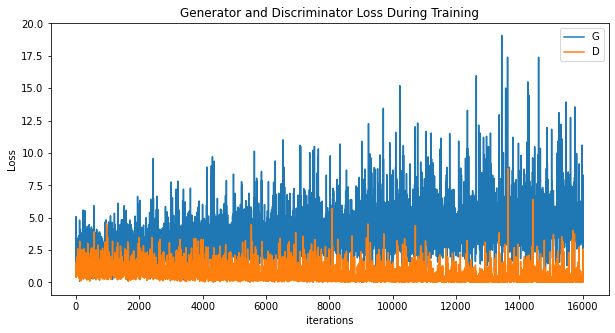

In [19]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()